# Convolutional Neural Networks using Tensorflow and Keras

We will work through creating a convolutional neural network from scratch.

## Step 1 - Import the data

We will use `image_dataset_from_directory` to build our training and validation sets. This function expects our images to be in folders separated by class, and the classifcation values are inferred from the folder names.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# You can mess with batch size
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 1

# This sets up a training and validation set from our ../data/ directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=SEED)

# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=SEED)

Found 1622 files belonging to 2 classes.
Using 1298 files for training.
Found 1622 files belonging to 2 classes.
Using 324 files for validation.


## Step 2 - Set up the image augmentation and preprocessing

This [tutorial](https://www.tensorflow.org/guide/keras/preprocessing_layers) provides some of the preprocessing and image augmentation option using Keras layers. We will be integrating the preprocessing and augmentation into our model, which streamlines the process and makes the model more portable. But the tutorial also presents an alternate way that may be more efficient if you are training using your CPU (which we are unless you do some extra setup to utilize a GPU).

You can experiment with some of the other image augmentation layers such as:
* tf.keras.layers.RandomCrop
* tf.keras.layers.RandomFlip
* tf.keras.layers.RandomTranslation
* tf.keras.layers.RandomRotation
* tf.keras.layers.RandomZoom
* tf.keras.layers.RandomContrast

We will also be applying some preprocessing to rescale the images to have color values in [0,1] instead of [0,255] and to crop/resize the images down to (224,224). We don't need the cropping for the images that we processed last class period, but this will allow us to use our model on any size image without worrying about processing it first.

In [4]:
from tensorflow.keras import layers

image_preprocess = tf.keras.Sequential([
    tf.keras.Input((None,None,3)),
    layers.Resizing(224,224, crop_to_aspect_ratio = True),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

image_preprocess.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Test out our image augmentation:

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of d

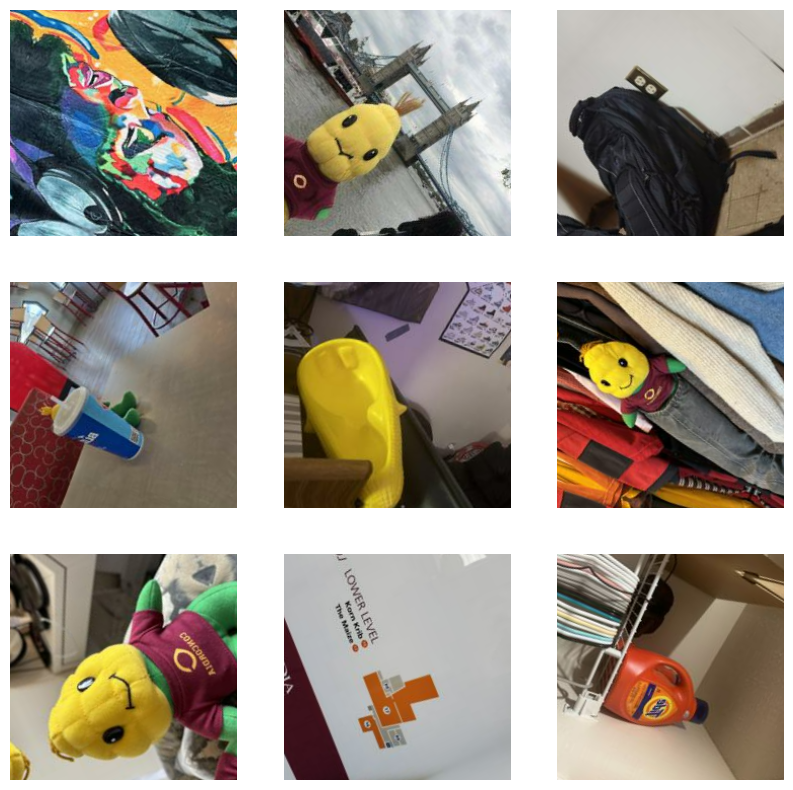

In [5]:
iterator = iter(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
  image = tf.cast(tf.expand_dims(next(iterator)[0][0], 0), tf.float32)
  augmented_image = image_preprocess(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Step 3 - Sequential Layers

The main layers we will use are:
* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) - Convolutional layer
* [AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) - Pooling layers
* [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - After all the convolutions are done, this flattens the 2D image to a vector.
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) - Fully connected layer
* [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - Randomly masks a portion of the previous layer during training.

You can experiment with the parameters in these layers.

In [6]:
nnet_layers = tf.keras.Sequential([
    tf.keras.Input((224,224,3)),
    layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Flatten(),
    #fully connected layer
    layers.Dense(1024, activation = 'relu'),
    #dropout helps prevent overfitting
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])
#less pooling more parameters
nnet_layers.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Put the model together:

In [7]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = image_preprocess(inputs)
outputs = nnet_layers(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │     1,729,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model:

In [8]:
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
          #Area Under the Curve AUC
           tf.keras.metrics.AUC(),
           #Predict Niblet and actually Niblet
           tf.keras.metrics.TruePositives(),
           #Predict Not_Niblet and actually Not_Niblet
           tf.keras.metrics.TrueNegatives(),
           #Predict Niblet but Not_Niblet
           tf.keras.metrics.FalsePositives(),
           #Predict Not_Niblet but Niblet
           tf.keras.metrics.FalseNegatives()]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

## Step 4 - Train the Model

Time for some popcorn

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=15, monitor='val_loss')

model.fit(train_dataset, epochs=100,
          validation_data=val_dataset,
          callbacks=[es])

Epoch 1/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5972 - auc: 0.5179 - false_negatives: 0.0000e+00 - false_positives: 13.3333 - loss: 0.6963 - true_negatives: 0.0000e+00 - true_positives: 18.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5535 - auc: 0.4611 - false_negatives: 2.8571 - false_positives: 26.8571 - loss: 0.7144 - true_negatives: 3.2857 - true_positives: 31.0000      

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5545 - auc: 0.4843 - false_negatives: 11.4545 - false_positives: 32.0000 - loss: 0.7125 - true_negatives: 16.8182 - true_positives: 35.7273

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5571 - auc: 0.4981 - false_negatives: 25.6250 - false_positives: 34.8125 - loss: 0.7088 - true_negatives: 37.2500 - true_positives: 38.3125

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5557 - auc: 0.5030 - false_negatives: 38.9500 - false_positives: 36.0500 - loss: 0.7068 - true_negatives: 53.5500 - true_positives: 39.4500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5560 - auc: 0.5083 - false_negatives: 52.1667 - false_positives: 36.8750 - loss: 0.7047 - true_negatives: 70.7500 - true_positives: 40.2083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5566 - auc: 0.5137 - false_negatives: 72.3333 - false_positives: 37.7000 - loss: 0.7023 - true_negatives: 97.0000 - true_positives: 40.9667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5574 - auc: 0.5176 - false_negatives: 89.1429 - false_positives: 38.1714 - loss: 0.7005 - true_negatives: 119.2857 - true_positives: 41.4000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5579 - auc: 0.5192 - false_negatives: 109.6829 - false_positives: 38.5854 - loss: 0.6991 - true_negatives: 145.9512 - true_positives: 41.7805

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5587 - auc: 0.5223 - false_negatives: 130.1064 - false_positives: 38.8936 - loss: 0.6977 - true_negatives: 172.9362 - true_positives: 42.0638

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5589 - auc: 0.5256 - false_negatives: 147.3846 - false_positives: 39.0962 - loss: 0.6966 - true_negatives: 195.2692 - true_positives: 42.2500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5591 - auc: 0.5299 - false_negatives: 168.2241 - false_positives: 39.2931 - loss: 0.6953 - true_negatives: 222.0517 - true_positives: 42.4310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5597 - auc: 0.5417 - false_negatives: 216.7500 - false_positives: 39.6389 - loss: 0.6919 - true_negatives: 284.8750 - true_positives: 42.7361

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5602 - auc: 0.5481 - false_negatives: 246.5679 - false_positives: 41.0247 - loss: 0.6901 - true_negatives: 323.5803 - true_positives: 44.8272

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5604 - auc: 0.5494 - false_negatives: 252.6265 - false_positives: 41.5060 - loss: 0.6897 - true_negatives: 331.7590 - true_positives: 45.5783 - val_accuracy: 0.1975 - val_auc: 0.0000e+00 - val_false_negatives: 260.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.8391 - val_true_negatives: 0.0000e+00 - val_true_positives: 64.0000
Epoch 2/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6146 - auc: 0.6735 - false_negatives: 12.3333 - false_positives: 0.0000e+00 - loss: 0.6612 - true_negatives: 18.6667 - true_positives: 1.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6171 - auc: 0.6740 - false_negatives: 24.7143 - false_positives: 0.0000e+00 - loss: 0.6594 - true_negatives: 38.2857 - true_positives: 1.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5973 - auc: 0.6805 - false_negatives: 38.7273 - false_positives: 1.1818 - loss: 0.6629 - true_negatives: 53.6364 - true_positives: 2.4545 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6002 - auc: 0.6765 - false_negatives: 50.5625 - false_positives: 4.3125 - loss: 0.6634 - true_negatives: 72.1250 - true_positives: 9.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6050 - auc: 0.6707 - false_negatives: 58.1000 - false_positives: 8.0500 - loss: 0.6647 - true_negatives: 85.5500 - true_positives: 16.3000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6103 - auc: 0.6676 - false_negatives: 65.3333 - false_positives: 11.5833 - loss: 0.6654 - true_negatives: 99.3750 - true_positives: 23.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6138 - auc: 0.6642 - false_negatives: 79.0000 - false_positives: 15.2667 - loss: 0.6658 - true_negatives: 122.3667 - true_positives: 31.3667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6144 - auc: 0.6619 - false_negatives: 92.2571 - false_positives: 17.3714 - loss: 0.6659 - true_negatives: 142.5714 - true_positives: 35.8000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6148 - auc: 0.6601 - false_negatives: 107.8049 - false_positives: 20.2927 - loss: 0.6659 - true_negatives: 166.2927 - true_positives: 41.6098

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6170 - auc: 0.6610 - false_negatives: 121.7660 - false_positives: 23.4043 - loss: 0.6652 - true_negatives: 190.0851 - true_positives: 48.7447

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6187 - auc: 0.6625 - false_negatives: 133.6731 - false_positives: 25.6346 - loss: 0.6643 - true_negatives: 210.2500 - true_positives: 54.4423

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6201 - auc: 0.6642 - false_negatives: 147.6724 - false_positives: 28.9310 - loss: 0.6631 - true_negatives: 233.6035 - true_positives: 61.7931

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6245 - auc: 0.6686 - false_negatives: 175.6944 - false_positives: 39.3472 - loss: 0.6599 - true_negatives: 285.6528 - true_positives: 83.3056

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6276 - auc: 0.6721 - false_negatives: 191.6543 - false_positives: 47.0247 - loss: 0.6579 - true_negatives: 317.8889 - true_positives: 99.4321

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6283 - auc: 0.6728 - false_negatives: 194.9398 - false_positives: 48.8072 - loss: 0.6575 - true_negatives: 324.7590 - true_positives: 102.9639 - val_accuracy: 0.5926 - val_auc: 0.0000e+00 - val_false_negatives: 132.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.8489 - val_true_negatives: 0.0000e+00 - val_true_positives: 192.0000
Epoch 3/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5451 - auc: 0.5822 - false_negatives: 8.0000 - false_positives: 5.6667 - loss: 0.7497 - true_negatives: 11.3333 - true_positives: 7.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6031 - auc: 0.6394 - false_negatives: 10.5714 - false_positives: 13.0000 - loss: 0.6851 - true_negatives: 23.7143 - true_positives: 16.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6225 - auc: 0.6554 - false_negatives: 14.8182 - false_positives: 19.1818 - loss: 0.6706 - true_negatives: 36.4545 - true_positives: 25.5455

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6370 - auc: 0.6694 - false_negatives: 22.7500 - false_positives: 23.8125 - loss: 0.6601 - true_negatives: 53.7500 - true_positives: 35.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6408 - auc: 0.6752 - false_negatives: 29.1500 - false_positives: 28.4500 - loss: 0.6552 - true_negatives: 66.6500 - true_positives: 43.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6440 - auc: 0.6795 - false_negatives: 34.8750 - false_positives: 33.5000 - loss: 0.6514 - true_negatives: 79.4167 - true_positives: 52.2083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6501 - auc: 0.6872 - false_negatives: 43.3333 - false_positives: 40.0000 - loss: 0.6458 - true_negatives: 99.4333 - true_positives: 65.2333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6519 - auc: 0.6897 - false_negatives: 50.8286 - false_positives: 46.0571 - loss: 0.6431 - true_negatives: 115.8857 - true_positives: 75.2286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6552 - auc: 0.6950 - false_negatives: 59.0732 - false_positives: 52.9756 - loss: 0.6384 - true_negatives: 136.1707 - true_positives: 87.7805

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6584 - auc: 0.7000 - false_negatives: 67.4894 - false_positives: 59.2979 - loss: 0.6347 - true_negatives: 156.3617 - true_positives: 100.8511

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6609 - auc: 0.7034 - false_negatives: 73.5769 - false_positives: 65.3269 - loss: 0.6320 - true_negatives: 172.3077 - true_positives: 112.7885

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6632 - auc: 0.7063 - false_negatives: 80.3103 - false_positives: 73.3448 - loss: 0.6294 - true_negatives: 190.9138 - true_positives: 127.4310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6685 - auc: 0.7133 - false_negatives: 95.3611 - false_positives: 91.4306 - loss: 0.6234 - true_negatives: 234.3194 - true_positives: 162.8889

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6719 - auc: 0.7177 - false_negatives: 105.0494 - false_positives: 102.1605 - loss: 0.6198 - true_negatives: 263.8271 - true_positives: 184.9630

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6726 - auc: 0.7186 - false_negatives: 107.0482 - false_positives: 104.5422 - loss: 0.6190 - true_negatives: 270.0723 - true_positives: 189.8072 - val_accuracy: 0.9136 - val_auc: 0.0000e+00 - val_false_negatives: 28.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.4250 - val_true_negatives: 0.0000e+00 - val_true_positives: 296.0000
Epoch 4/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6667 - auc: 0.7338 - false_negatives: 1.0000 - false_positives: 9.6667 - loss: 0.6772 - true_negatives: 7.3333 - true_positives: 14.0000  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6931 - auc: 0.7474 - false_negatives: 2.5714 - false_positives: 16.5714 - loss: 0.6344 - true_negatives: 16.7143 - true_positives: 28.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6940 - auc: 0.7615 - false_negatives: 5.7273 - false_positives: 23.2727 - loss: 0.6147 - true_negatives: 28.1818 - true_positives: 38.8182

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7022 - auc: 0.7727 - false_negatives: 11.1250 - false_positives: 28.3750 - loss: 0.5937 - true_negatives: 47.2500 - true_positives: 49.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7065 - auc: 0.7782 - false_negatives: 16.2500 - false_positives: 31.7000 - loss: 0.5837 - true_negatives: 62.4000 - true_positives: 57.6500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7083 - auc: 0.7814 - false_negatives: 21.4583 - false_positives: 35.4583 - loss: 0.5779 - true_negatives: 76.1667 - true_positives: 66.9167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7100 - auc: 0.7836 - false_negatives: 28.5000 - false_positives: 41.9667 - loss: 0.5729 - true_negatives: 95.7667 - true_positives: 81.7667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7110 - auc: 0.7850 - false_negatives: 33.4000 - false_positives: 48.3143 - loss: 0.5697 - true_negatives: 111.3143 - true_positives: 94.9714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7125 - auc: 0.7864 - false_negatives: 38.6829 - false_positives: 56.1951 - loss: 0.5666 - true_negatives: 129.8293 - true_positives: 111.2927

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7139 - auc: 0.7873 - false_negatives: 44.3404 - false_positives: 63.5532 - loss: 0.5649 - true_negatives: 148.7021 - true_positives: 127.4043

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7157 - auc: 0.7887 - false_negatives: 48.8269 - false_positives: 69.2500 - loss: 0.5627 - true_negatives: 165.5000 - true_positives: 140.4231

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7178 - auc: 0.7906 - false_negatives: 54.7586 - false_positives: 75.4138 - loss: 0.5598 - true_negatives: 186.4310 - true_positives: 155.3965

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7223 - auc: 0.7950 - false_negatives: 67.8056 - false_positives: 89.7917 - loss: 0.5536 - true_negatives: 234.6250 - true_positives: 191.7778

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7252 - auc: 0.7981 - false_negatives: 75.2346 - false_positives: 99.3210 - loss: 0.5493 - true_negatives: 265.1975 - true_positives: 216.2469

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7258 - auc: 0.7988 - false_negatives: 76.8916 - false_positives: 101.2651 - loss: 0.5484 - true_negatives: 271.9156 - true_positives: 221.3976 - val_accuracy: 0.3056 - val_auc: 0.0000e+00 - val_false_negatives: 225.0000 - val_false_positives: 0.0000e+00 - val_loss: 1.8270 - val_true_negatives: 0.0000e+00 - val_true_positives: 99.0000
Epoch 5/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6319 - auc: 0.8526 - false_negatives: 9.3333 - false_positives: 1.6667 - loss: 0.7725 - true_negatives: 14.0000 - true_positives: 7.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6757 - auc: 0.8253 - false_negatives: 14.0000 - false_positives: 5.2857 - loss: 0.6747 - true_negatives: 26.8571 - true_positives: 17.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6950 - auc: 0.8113 - false_negatives: 16.4545 - false_positives: 10.8182 - loss: 0.6368 - true_negatives: 40.0000 - true_positives: 28.7273

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7015 - auc: 0.7991 - false_negatives: 18.3750 - false_positives: 20.2500 - loss: 0.6162 - true_negatives: 55.5625 - true_positives: 41.8125

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7075 - auc: 0.7979 - false_negatives: 20.2500 - false_positives: 26.5000 - loss: 0.6044 - true_negatives: 68.1000 - true_positives: 53.1500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7129 - auc: 0.7978 - false_negatives: 22.2500 - false_positives: 32.3333 - loss: 0.5963 - true_negatives: 80.7917 - true_positives: 64.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7192 - auc: 0.7990 - false_negatives: 25.1333 - false_positives: 41.0333 - loss: 0.5867 - true_negatives: 99.2333 - true_positives: 82.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7233 - auc: 0.8004 - false_negatives: 28.1143 - false_positives: 47.5714 - loss: 0.5802 - true_negatives: 114.9143 - true_positives: 97.4000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7282 - auc: 0.8031 - false_negatives: 32.2439 - false_positives: 54.3171 - loss: 0.5727 - true_negatives: 133.9268 - true_positives: 115.5122

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7325 - auc: 0.8059 - false_negatives: 36.1489 - false_positives: 60.9574 - loss: 0.5660 - true_negatives: 153.1064 - true_positives: 133.7872

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7360 - auc: 0.8084 - false_negatives: 39.3846 - false_positives: 66.1923 - loss: 0.5607 - true_negatives: 169.6538 - true_positives: 148.7692

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7397 - auc: 0.8109 - false_negatives: 43.3621 - false_positives: 72.2586 - loss: 0.5554 - true_negatives: 190.2414 - true_positives: 166.1379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7470 - auc: 0.8164 - false_negatives: 53.2639 - false_positives: 85.2639 - loss: 0.5446 - true_negatives: 240.0556 - true_positives: 205.4167

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7509 - auc: 0.8192 - false_negatives: 59.7037 - false_positives: 93.2346 - loss: 0.5387 - true_negatives: 272.3210 - true_positives: 230.7407

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7516 - auc: 0.8197 - false_negatives: 61.2289 - false_positives: 94.8434 - loss: 0.5376 - true_negatives: 279.3494 - true_positives: 236.0482 - val_accuracy: 0.7716 - val_auc: 0.0000e+00 - val_false_negatives: 74.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.4700 - val_true_negatives: 0.0000e+00 - val_true_positives: 250.0000
Epoch 6/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8438 - auc: 0.9465 - false_negatives: 2.0000 - false_positives: 2.0000 - loss: 0.3786 - true_negatives: 13.5000 - true_positives: 6.5000    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7986 - auc: 0.8937 - false_negatives: 3.3333 - false_positives: 9.0000 - loss: 0.4531 - true_negatives: 26.0000 - true_positives: 17.6667

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7866 - auc: 0.8743 - false_negatives: 5.8000 - false_positives: 14.2000 - loss: 0.4688 - true_negatives: 37.2000 - true_positives: 30.8000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7835 - auc: 0.8609 - false_negatives: 8.3571 - false_positives: 18.7143 - loss: 0.4796 - true_negatives: 49.7857 - true_positives: 43.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7861 - auc: 0.8589 - false_negatives: 10.1111 - false_positives: 22.9444 - loss: 0.4783 - true_negatives: 63.7222 - true_positives: 55.2222

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7875 - auc: 0.8575 - false_negatives: 13.5217 - false_positives: 27.5217 - loss: 0.4756 - true_negatives: 80.6522 - true_positives: 70.3043

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7898 - auc: 0.8577 - false_negatives: 18.4667 - false_positives: 33.4333 - loss: 0.4712 - true_negatives: 103.9333 - true_positives: 92.1667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7913 - auc: 0.8584 - false_negatives: 21.4571 - false_positives: 38.1143 - loss: 0.4682 - true_negatives: 120.4857 - true_positives: 107.9429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7922 - auc: 0.8590 - false_negatives: 25.9268 - false_positives: 43.1707 - loss: 0.4655 - true_negatives: 141.9024 - true_positives: 125.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7928 - auc: 0.8592 - false_negatives: 31.0000 - false_positives: 47.7021 - loss: 0.4638 - true_negatives: 164.2128 - true_positives: 141.0851

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7938 - auc: 0.8597 - false_negatives: 34.7308 - false_positives: 51.5577 - loss: 0.4624 - true_negatives: 182.4615 - true_positives: 155.2500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7949 - auc: 0.8603 - false_negatives: 39.0690 - false_positives: 56.2414 - loss: 0.4610 - true_negatives: 204.0172 - true_positives: 172.6724

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7972 - auc: 0.8617 - false_negatives: 48.5278 - false_positives: 67.6944 - loss: 0.4584 - true_negatives: 254.9861 - true_positives: 212.7917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7984 - auc: 0.8627 - false_negatives: 54.6667 - false_positives: 74.8642 - loss: 0.4567 - true_negatives: 288.2592 - true_positives: 238.2099

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7987 - auc: 0.8629 - false_negatives: 55.9759 - false_positives: 76.3373 - loss: 0.4563 - true_negatives: 295.4819 - true_positives: 243.6747 - val_accuracy: 0.6636 - val_auc: 0.0000e+00 - val_false_negatives: 109.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6448 - val_true_negatives: 0.0000e+00 - val_true_positives: 215.0000
Epoch 7/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7569 - auc: 0.7878 - false_negatives: 4.6667 - false_positives: 2.6667 - loss: 0.5073 - true_negatives: 13.6667 - true_positives: 11.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7698 - auc: 0.8218 - false_negatives: 8.7143 - false_positives: 5.4286 - loss: 0.4952 - true_negatives: 30.2857 - true_positives: 19.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7807 - auc: 0.8393 - false_negatives: 11.1818 - false_positives: 8.8182 - loss: 0.4775 - true_negatives: 44.9091 - true_positives: 31.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7914 - auc: 0.8541 - false_negatives: 14.3750 - false_positives: 12.3125 - loss: 0.4590 - true_negatives: 64.0625 - true_positives: 45.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7983 - auc: 0.8618 - false_negatives: 16.7500 - false_positives: 14.9000 - loss: 0.4478 - true_negatives: 79.0000 - true_positives: 57.3500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8031 - auc: 0.8654 - false_negatives: 18.8333 - false_positives: 17.9167 - loss: 0.4418 - true_negatives: 93.5417 - true_positives: 69.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8075 - auc: 0.8689 - false_negatives: 21.9667 - false_positives: 22.8667 - loss: 0.4362 - true_negatives: 114.4000 - true_positives: 88.7667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8099 - auc: 0.8701 - false_negatives: 24.3429 - false_positives: 27.2857 - loss: 0.4347 - true_negatives: 131.0857 - true_positives: 105.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8126 - auc: 0.8715 - false_negatives: 27.2195 - false_positives: 32.3659 - loss: 0.4331 - true_negatives: 151.7317 - true_positives: 124.6829

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8151 - auc: 0.8731 - false_negatives: 30.4894 - false_positives: 36.7447 - loss: 0.4308 - true_negatives: 173.3617 - true_positives: 143.4043

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8167 - auc: 0.8741 - false_negatives: 33.5385 - false_positives: 40.1731 - loss: 0.4294 - true_negatives: 191.9615 - true_positives: 158.3269

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8177 - auc: 0.8748 - false_negatives: 37.3448 - false_positives: 44.6724 - loss: 0.4285 - true_negatives: 214.1724 - true_positives: 175.8103

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8194 - auc: 0.8770 - false_negatives: 46.7083 - false_positives: 54.7639 - loss: 0.4256 - true_negatives: 266.6667 - true_positives: 215.8611

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8199 - auc: 0.8780 - false_negatives: 52.8395 - false_positives: 61.4321 - loss: 0.4244 - true_negatives: 300.5309 - true_positives: 241.1975

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8200 - auc: 0.8782 - false_negatives: 54.2892 - false_positives: 62.7711 - loss: 0.4242 - true_negatives: 307.9156 - true_positives: 246.4940 - val_accuracy: 0.7623 - val_auc: 0.0000e+00 - val_false_negatives: 77.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.5298 - val_true_negatives: 0.0000e+00 - val_true_positives: 247.0000
Epoch 8/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7604 - auc: 0.8500 - false_negatives: 3.3333 - false_positives: 4.3333 - loss: 0.4724 - true_negatives: 15.6667 - true_positives: 8.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7587 - auc: 0.8557 - false_negatives: 4.7143 - false_positives: 10.8571 - loss: 0.4654 - true_negatives: 27.8571 - true_positives: 20.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7529 - auc: 0.8554 - false_negatives: 5.6364 - false_positives: 18.4545 - loss: 0.4765 - true_negatives: 38.4545 - true_positives: 33.4545

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7590 - auc: 0.8555 - false_negatives: 7.8125 - false_positives: 24.6250 - loss: 0.4792 - true_negatives: 52.6250 - true_positives: 50.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7629 - auc: 0.8575 - false_negatives: 9.9000 - false_positives: 29.1500 - loss: 0.4770 - true_negatives: 64.7500 - true_positives: 64.2000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7675 - auc: 0.8602 - false_negatives: 12.1250 - false_positives: 33.0000 - loss: 0.4728 - true_negatives: 78.3333 - true_positives: 76.5417

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7731 - auc: 0.8643 - false_negatives: 15.9667 - false_positives: 38.1000 - loss: 0.4656 - true_negatives: 99.3667 - true_positives: 94.5667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7773 - auc: 0.8670 - false_negatives: 18.8571 - false_positives: 42.4000 - loss: 0.4608 - true_negatives: 116.4286 - true_positives: 110.3143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7814 - auc: 0.8695 - false_negatives: 22.0732 - false_positives: 47.7317 - loss: 0.4560 - true_negatives: 136.5854 - true_positives: 129.6098

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7856 - auc: 0.8719 - false_negatives: 25.3617 - false_positives: 52.4468 - loss: 0.4511 - true_negatives: 158.4894 - true_positives: 147.7021

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7884 - auc: 0.8737 - false_negatives: 28.3077 - false_positives: 56.2885 - loss: 0.4474 - true_negatives: 177.0192 - true_positives: 162.3846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7911 - auc: 0.8757 - false_negatives: 31.9310 - false_positives: 60.9310 - loss: 0.4435 - true_negatives: 199.3621 - true_positives: 179.7759

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7968 - auc: 0.8801 - false_negatives: 40.6389 - false_positives: 70.7222 - loss: 0.4351 - true_negatives: 252.6806 - true_positives: 219.9583

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8001 - auc: 0.8828 - false_negatives: 46.3210 - false_positives: 76.3580 - loss: 0.4300 - true_negatives: 287.4445 - true_positives: 245.8765

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8008 - auc: 0.8833 - false_negatives: 47.4940 - false_positives: 77.6024 - loss: 0.4290 - true_negatives: 294.8795 - true_positives: 251.4940 - val_accuracy: 0.7315 - val_auc: 0.0000e+00 - val_false_negatives: 87.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.5147 - val_true_negatives: 0.0000e+00 - val_true_positives: 237.0000
Epoch 9/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8160 - auc: 0.8774 - false_negatives: 2.3333 - false_positives: 4.0000 - loss: 0.4182 - true_negatives: 17.3333 - true_positives: 8.3333  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8241 - auc: 0.8850 - false_negatives: 6.0000 - false_positives: 5.1429 - loss: 0.4065 - true_negatives: 35.1429 - true_positives: 17.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8182 - auc: 0.8883 - false_negatives: 10.3636 - false_positives: 7.3636 - loss: 0.4047 - true_negatives: 50.2727 - true_positives: 28.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8185 - auc: 0.8895 - false_negatives: 14.0625 - false_positives: 10.7500 - loss: 0.4037 - true_negatives: 70.1875 - true_positives: 41.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8210 - auc: 0.8917 - false_negatives: 16.6000 - false_positives: 13.2500 - loss: 0.3999 - true_negatives: 85.9000 - true_positives: 52.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8226 - auc: 0.8933 - false_negatives: 19.3333 - false_positives: 15.7083 - loss: 0.3981 - true_negatives: 101.4167 - true_positives: 63.5417

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8241 - auc: 0.8947 - false_negatives: 23.2000 - false_positives: 19.7667 - loss: 0.3965 - true_negatives: 123.9667 - true_positives: 81.0667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8245 - auc: 0.8952 - false_negatives: 27.1143 - false_positives: 22.8000 - loss: 0.3964 - true_negatives: 142.5714 - true_positives: 95.5143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8252 - auc: 0.8960 - false_negatives: 31.6829 - false_positives: 26.3171 - loss: 0.3961 - true_negatives: 164.8293 - true_positives: 113.1707

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8262 - auc: 0.8970 - false_negatives: 35.8511 - false_positives: 29.9149 - loss: 0.3952 - true_negatives: 187.3192 - true_positives: 130.9149

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8271 - auc: 0.8975 - false_negatives: 39.1923 - false_positives: 32.9231 - loss: 0.3948 - true_negatives: 206.6731 - true_positives: 145.2115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8276 - auc: 0.8981 - false_negatives: 43.3793 - false_positives: 36.6379 - loss: 0.3942 - true_negatives: 229.2931 - true_positives: 162.6897

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8295 - auc: 0.8996 - false_negatives: 52.5972 - false_positives: 44.9722 - loss: 0.3921 - true_negatives: 282.3611 - true_positives: 204.0694

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8306 - auc: 0.9005 - false_negatives: 58.6420 - false_positives: 50.1728 - loss: 0.3908 - true_negatives: 316.8148 - true_positives: 230.3704

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8307 - auc: 0.9007 - false_negatives: 60.0241 - false_positives: 51.2530 - loss: 0.3905 - true_negatives: 324.3373 - true_positives: 235.8554 - val_accuracy: 0.7654 - val_auc: 0.0000e+00 - val_false_negatives: 76.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.4002 - val_true_negatives: 0.0000e+00 - val_true_positives: 248.0000
Epoch 10/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8715 - auc: 0.9401 - false_negatives: 3.3333 - false_positives: 1.3333 - loss: 0.2884 - true_negatives: 19.0000 - true_positives: 8.3333  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8271 - auc: 0.9104 - false_negatives: 6.2857 - false_positives: 6.2857 - loss: 0.3594 - true_negatives: 32.1429 - true_positives: 19.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8046 - auc: 0.8968 - false_negatives: 10.2727 - false_positives: 10.6364 - loss: 0.3903 - true_negatives: 46.0000 - true_positives: 29.0909

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7971 - auc: 0.8913 - false_negatives: 15.6875 - false_positives: 14.0625 - loss: 0.4020 - true_negatives: 64.8750 - true_positives: 41.3750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7921 - auc: 0.8867 - false_negatives: 20.4500 - false_positives: 16.8500 - loss: 0.4116 - true_negatives: 80.5000 - true_positives: 50.2000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7900 - auc: 0.8839 - false_negatives: 24.1667 - false_positives: 20.1250 - loss: 0.4170 - true_negatives: 95.2917 - true_positives: 60.4167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7891 - auc: 0.8816 - false_negatives: 29.2667 - false_positives: 25.0333 - loss: 0.4219 - true_negatives: 118.2333 - true_positives: 75.4667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7900 - auc: 0.8812 - false_negatives: 33.3714 - false_positives: 28.6286 - loss: 0.4234 - true_negatives: 137.5143 - true_positives: 88.4857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7921 - auc: 0.8820 - false_negatives: 37.6098 - false_positives: 32.9268 - loss: 0.4225 - true_negatives: 160.0488 - true_positives: 105.4146

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7939 - auc: 0.8830 - false_negatives: 41.5319 - false_positives: 37.5957 - loss: 0.4210 - true_negatives: 182.0638 - true_positives: 122.8085

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7957 - auc: 0.8839 - false_negatives: 44.8654 - false_positives: 41.1154 - loss: 0.4193 - true_negatives: 200.7115 - true_positives: 137.3077

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7969 - auc: 0.8844 - false_negatives: 48.3793 - false_positives: 46.3966 - loss: 0.4186 - true_negatives: 221.6897 - true_positives: 155.5345

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8003 - auc: 0.8857 - false_negatives: 56.2778 - false_positives: 57.9167 - loss: 0.4166 - true_negatives: 270.6250 - true_positives: 199.1806

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8023 - auc: 0.8869 - false_negatives: 61.0617 - false_positives: 65.2963 - loss: 0.4148 - true_negatives: 302.8148 - true_positives: 226.8272

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8027 - auc: 0.8871 - false_negatives: 62.1687 - false_positives: 66.7831 - loss: 0.4143 - true_negatives: 309.9036 - true_positives: 232.6145 - val_accuracy: 0.5617 - val_auc: 0.0000e+00 - val_false_negatives: 142.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.7330 - val_true_negatives: 0.0000e+00 - val_true_positives: 182.0000
Epoch 11/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8125 - auc: 0.9518 - false_negatives: 5.3333 - false_positives: 0.6667 - loss: 0.3519 - true_negatives: 13.0000 - true_positives: 13.0000   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8284 - auc: 0.9422 - false_negatives: 8.8571 - false_positives: 1.7143 - loss: 0.3476 - true_negatives: 29.5714 - true_positives: 23.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8372 - auc: 0.9344 - false_negatives: 10.8182 - false_positives: 4.0909 - loss: 0.3462 - true_negatives: 47.5455 - true_positives: 33.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8402 - auc: 0.9281 - false_negatives: 12.8750 - false_positives: 8.0625 - loss: 0.3490 - true_negatives: 66.9375 - true_positives: 48.1250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8413 - auc: 0.9249 - false_negatives: 15.1000 - false_positives: 10.8000 - loss: 0.3517 - true_negatives: 81.4000 - true_positives: 60.7000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8415 - auc: 0.9222 - false_negatives: 17.3333 - false_positives: 13.7083 - loss: 0.3560 - true_negatives: 95.9583 - true_positives: 73.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8418 - auc: 0.9194 - false_negatives: 20.3333 - false_positives: 18.3000 - loss: 0.3603 - true_negatives: 118.5667 - true_positives: 90.8000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8422 - auc: 0.9180 - false_negatives: 23.0571 - false_positives: 21.8000 - loss: 0.3624 - true_negatives: 137.8286 - true_positives: 105.3143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8423 - auc: 0.9170 - false_negatives: 26.1707 - false_positives: 26.2439 - loss: 0.3636 - true_negatives: 160.8049 - true_positives: 122.7805

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8431 - auc: 0.9171 - false_negatives: 29.4681 - false_positives: 30.0426 - loss: 0.3627 - true_negatives: 183.6596 - true_positives: 140.8298

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8439 - auc: 0.9173 - false_negatives: 32.1731 - false_positives: 33.0192 - loss: 0.3615 - true_negatives: 202.4423 - true_positives: 156.3654

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8444 - auc: 0.9170 - false_negatives: 35.3103 - false_positives: 37.0345 - loss: 0.3611 - true_negatives: 224.4655 - true_positives: 175.1897

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8459 - auc: 0.9171 - false_negatives: 42.1944 - false_positives: 46.2361 - loss: 0.3594 - true_negatives: 276.0000 - true_positives: 219.5694

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8470 - auc: 0.9175 - false_negatives: 46.4444 - false_positives: 51.8395 - loss: 0.3577 - true_negatives: 310.6173 - true_positives: 247.0988

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8473 - auc: 0.9176 - false_negatives: 47.3976 - false_positives: 53.0000 - loss: 0.3573 - true_negatives: 318.1687 - true_positives: 252.9036 - val_accuracy: 0.8395 - val_auc: 0.0000e+00 - val_false_negatives: 52.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.4322 - val_true_negatives: 0.0000e+00 - val_true_positives: 272.0000
Epoch 12/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7778 - auc: 0.8476 - false_negatives: 2.0000 - false_positives: 5.3333 - loss: 0.4298 - true_negatives: 12.0000 - true_positives: 12.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7661 - auc: 0.8557 - false_negatives: 4.5714 - false_positives: 11.0000 - loss: 0.4409 - true_negatives: 26.0000 - true_positives: 22.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7630 - auc: 0.8620 - false_negatives: 6.2727 - false_positives: 17.0000 - loss: 0.4446 - true_negatives: 37.9091 - true_positives: 34.8182

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7655 - auc: 0.8673 - false_negatives: 8.5000 - false_positives: 23.5000 - loss: 0.4426 - true_negatives: 54.0625 - true_positives: 49.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7704 - auc: 0.8719 - false_negatives: 10.5000 - false_positives: 27.5000 - loss: 0.4369 - true_negatives: 68.3000 - true_positives: 61.7000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7769 - auc: 0.8769 - false_negatives: 12.4167 - false_positives: 30.6667 - loss: 0.4302 - true_negatives: 83.0833 - true_positives: 73.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7856 - auc: 0.8825 - false_negatives: 14.9667 - false_positives: 35.3000 - loss: 0.4220 - true_negatives: 105.4000 - true_positives: 92.3333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7896 - auc: 0.8849 - false_negatives: 18.0857 - false_positives: 39.0571 - loss: 0.4184 - true_negatives: 123.5714 - true_positives: 107.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7929 - auc: 0.8865 - false_negatives: 21.9756 - false_positives: 43.7317 - loss: 0.4159 - true_negatives: 145.5854 - true_positives: 124.7073

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7964 - auc: 0.8884 - false_negatives: 25.8511 - false_positives: 47.8298 - loss: 0.4128 - true_negatives: 167.8723 - true_positives: 142.4468

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7988 - auc: 0.8898 - false_negatives: 29.1538 - false_positives: 51.1923 - loss: 0.4107 - true_negatives: 186.5577 - true_positives: 157.0962

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8018 - auc: 0.8917 - false_negatives: 33.0000 - false_positives: 54.8621 - loss: 0.4075 - true_negatives: 209.5862 - true_positives: 174.5517

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8085 - auc: 0.8962 - false_negatives: 40.9722 - false_positives: 63.0833 - loss: 0.3996 - true_negatives: 262.9167 - true_positives: 217.0278

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8118 - auc: 0.8988 - false_negatives: 46.4568 - false_positives: 68.2469 - loss: 0.3949 - true_negatives: 297.9136 - true_positives: 243.3827

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8124 - auc: 0.8993 - false_negatives: 47.6024 - false_positives: 69.3735 - loss: 0.3939 - true_negatives: 305.4096 - true_positives: 249.0843 - val_accuracy: 0.8611 - val_auc: 0.0000e+00 - val_false_negatives: 45.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3673 - val_true_negatives: 0.0000e+00 - val_true_positives: 279.0000
Epoch 13/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7326 - auc: 0.8562 - false_negatives: 5.0000 - false_positives: 3.3333 - loss: 0.4612 - true_negatives: 13.6667 - true_positives: 10.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7799 - auc: 0.8988 - false_negatives: 8.5714 - false_positives: 4.1429 - loss: 0.3874 - true_negatives: 31.1429 - true_positives: 20.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8001 - auc: 0.9131 - false_negatives: 10.7273 - false_positives: 6.4545 - loss: 0.3611 - true_negatives: 46.2727 - true_positives: 32.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8084 - auc: 0.9181 - false_negatives: 13.5625 - false_positives: 10.3750 - loss: 0.3524 - true_negatives: 65.8750 - true_positives: 46.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8135 - auc: 0.9205 - false_negatives: 16.1500 - false_positives: 12.8500 - loss: 0.3477 - true_negatives: 82.2000 - true_positives: 56.8000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8164 - auc: 0.9200 - false_negatives: 18.9583 - false_positives: 15.3333 - loss: 0.3513 - true_negatives: 96.8750 - true_positives: 68.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8201 - auc: 0.9187 - false_negatives: 22.0667 - false_positives: 19.9000 - loss: 0.3558 - true_negatives: 117.6000 - true_positives: 88.4333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8213 - auc: 0.9170 - false_negatives: 24.8000 - false_positives: 24.1429 - loss: 0.3600 - true_negatives: 135.3143 - true_positives: 103.7429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8222 - auc: 0.9152 - false_negatives: 28.6585 - false_positives: 28.6829 - loss: 0.3640 - true_negatives: 156.8049 - true_positives: 121.8537

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8237 - auc: 0.9146 - false_negatives: 32.6170 - false_positives: 32.4894 - loss: 0.3656 - true_negatives: 179.2979 - true_positives: 139.5957

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8251 - auc: 0.9145 - false_negatives: 35.8077 - false_positives: 35.4423 - loss: 0.3659 - true_negatives: 198.6346 - true_positives: 154.1154

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8264 - auc: 0.9143 - false_negatives: 39.4310 - false_positives: 39.3448 - loss: 0.3665 - true_negatives: 221.5517 - true_positives: 171.6724

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8291 - auc: 0.9138 - false_negatives: 47.1667 - false_positives: 48.8889 - loss: 0.3669 - true_negatives: 275.4722 - true_positives: 212.4722

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8305 - auc: 0.9138 - false_negatives: 52.3333 - false_positives: 54.6667 - loss: 0.3664 - true_negatives: 309.7901 - true_positives: 239.2099

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8308 - auc: 0.9138 - false_negatives: 53.3855 - false_positives: 55.9036 - loss: 0.3662 - true_negatives: 317.2169 - true_positives: 244.9639 - val_accuracy: 0.8920 - val_auc: 0.0000e+00 - val_false_negatives: 35.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2968 - val_true_negatives: 0.0000e+00 - val_true_positives: 289.0000
Epoch 14/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8681 - auc: 0.9679 - false_negatives: 1.6667 - false_positives: 2.6667 - loss: 0.2724 - true_negatives: 17.6667 - true_positives: 10.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8509 - auc: 0.9463 - false_negatives: 5.7143 - false_positives: 4.2857 - loss: 0.3110 - true_negatives: 33.1429 - true_positives: 20.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8483 - auc: 0.9390 - false_negatives: 8.5455 - false_positives: 6.4545 - loss: 0.3235 - true_negatives: 49.6364 - true_positives: 31.3636

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8514 - auc: 0.9354 - false_negatives: 10.7500 - false_positives: 9.4375 - loss: 0.3261 - true_negatives: 69.1250 - true_positives: 46.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8560 - auc: 0.9352 - false_negatives: 12.3500 - false_positives: 11.2500 - loss: 0.3236 - true_negatives: 83.5500 - true_positives: 60.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8588 - auc: 0.9356 - false_negatives: 13.4583 - false_positives: 13.8333 - loss: 0.3211 - true_negatives: 96.8750 - true_positives: 75.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8624 - auc: 0.9370 - false_negatives: 15.0333 - false_positives: 17.6333 - loss: 0.3172 - true_negatives: 117.2000 - true_positives: 98.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8628 - auc: 0.9372 - false_negatives: 16.8857 - false_positives: 21.2857 - loss: 0.3167 - true_negatives: 134.8571 - true_positives: 114.9714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8629 - auc: 0.9375 - false_negatives: 19.7317 - false_positives: 25.1707 - loss: 0.3163 - true_negatives: 157.1951 - true_positives: 133.9024

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8633 - auc: 0.9375 - false_negatives: 22.4681 - false_positives: 28.8298 - loss: 0.3161 - true_negatives: 180.2979 - true_positives: 152.4043

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8640 - auc: 0.9376 - false_negatives: 24.4808 - false_positives: 31.8846 - loss: 0.3155 - true_negatives: 199.8462 - true_positives: 167.7885

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8644 - auc: 0.9375 - false_negatives: 26.9483 - false_positives: 35.7069 - loss: 0.3156 - true_negatives: 222.8793 - true_positives: 186.4655

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8653 - auc: 0.9375 - false_negatives: 32.8611 - false_positives: 44.2639 - loss: 0.3155 - true_negatives: 277.1250 - true_positives: 229.7500

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8654 - auc: 0.9376 - false_negatives: 37.1235 - false_positives: 49.7160 - loss: 0.3155 - true_negatives: 312.2592 - true_positives: 256.9012

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8654 - auc: 0.9376 - false_negatives: 38.0361 - false_positives: 50.9518 - loss: 0.3155 - true_negatives: 319.7470 - true_positives: 262.7350 - val_accuracy: 0.7778 - val_auc: 0.0000e+00 - val_false_negatives: 72.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.5802 - val_true_negatives: 0.0000e+00 - val_true_positives: 252.0000
Epoch 15/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8403 - auc: 0.9641 - false_negatives: 4.6667 - false_positives: 0.6667 - loss: 0.3477 - true_negatives: 17.0000 - true_positives: 9.6667 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8226 - auc: 0.9430 - false_negatives: 9.4286 - false_positives: 2.4286 - loss: 0.3759 - true_negatives: 31.7143 - true_positives: 20.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8203 - auc: 0.9345 - false_negatives: 12.4545 - false_positives: 5.2727 - loss: 0.3711 - true_negatives: 48.0000 - true_positives: 30.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8236 - auc: 0.9313 - false_negatives: 15.3125 - false_positives: 8.6875 - loss: 0.3626 - true_negatives: 67.9375 - true_positives: 44.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8265 - auc: 0.9286 - false_negatives: 17.2000 - false_positives: 11.6000 - loss: 0.3601 - true_negatives: 81.6000 - true_positives: 57.6000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8286 - auc: 0.9273 - false_negatives: 18.8333 - false_positives: 14.7917 - loss: 0.3574 - true_negatives: 95.4583 - true_positives: 70.9167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8335 - auc: 0.9277 - false_negatives: 21.0667 - false_positives: 18.7333 - loss: 0.3522 - true_negatives: 117.8333 - true_positives: 90.3667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8366 - auc: 0.9281 - false_negatives: 23.7143 - false_positives: 21.3429 - loss: 0.3503 - true_negatives: 137.1429 - true_positives: 105.8000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8387 - auc: 0.9267 - false_negatives: 26.6829 - false_positives: 25.1951 - loss: 0.3516 - true_negatives: 159.4390 - true_positives: 124.6829

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8400 - auc: 0.9243 - false_negatives: 28.9787 - false_positives: 30.0638 - loss: 0.3547 - true_negatives: 181.2979 - true_positives: 143.6596

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8404 - auc: 0.9227 - false_negatives: 31.3654 - false_positives: 33.9423 - loss: 0.3570 - true_negatives: 199.7115 - true_positives: 158.9808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8408 - auc: 0.9211 - false_negatives: 34.7069 - false_positives: 38.1379 - loss: 0.3597 - true_negatives: 222.3276 - true_positives: 176.8276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8426 - auc: 0.9192 - false_negatives: 41.5000 - false_positives: 47.7361 - loss: 0.3623 - true_negatives: 275.4028 - true_positives: 219.3611

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8439 - auc: 0.9189 - false_negatives: 45.7778 - false_positives: 53.4444 - loss: 0.3622 - true_negatives: 310.4815 - true_positives: 246.2963

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8441 - auc: 0.9188 - false_negatives: 46.8193 - false_positives: 54.6145 - loss: 0.3622 - true_negatives: 317.9879 - true_positives: 252.0482 - val_accuracy: 0.8673 - val_auc: 0.0000e+00 - val_false_negatives: 43.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3099 - val_true_negatives: 0.0000e+00 - val_true_positives: 281.0000
Epoch 16/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8819 - auc: 0.9347 - false_negatives: 2.3333 - false_positives: 1.3333 - loss: 0.3178 - true_negatives: 15.6667 - true_positives: 12.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8771 - auc: 0.9363 - false_negatives: 3.4286 - false_positives: 4.5714 - loss: 0.3163 - true_negatives: 28.4286 - true_positives: 27.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8765 - auc: 0.9375 - false_negatives: 4.0909 - false_positives: 7.9091 - loss: 0.3163 - true_negatives: 41.5455 - true_positives: 42.4545

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8760 - auc: 0.9364 - false_negatives: 5.5625 - false_positives: 11.4375 - loss: 0.3187 - true_negatives: 60.8125 - true_positives: 58.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8750 - auc: 0.9357 - false_negatives: 7.6500 - false_positives: 13.6000 - loss: 0.3194 - true_negatives: 76.4000 - true_positives: 70.3500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8743 - auc: 0.9344 - false_negatives: 9.8750 - false_positives: 15.5833 - loss: 0.3203 - true_negatives: 91.9167 - true_positives: 82.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8735 - auc: 0.9334 - false_negatives: 13.2667 - false_positives: 18.5333 - loss: 0.3209 - true_negatives: 115.9333 - true_positives: 100.2667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8728 - auc: 0.9328 - false_negatives: 15.9429 - false_positives: 21.2286 - loss: 0.3211 - true_negatives: 135.8857 - true_positives: 114.9429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8727 - auc: 0.9328 - false_negatives: 18.9024 - false_positives: 24.3659 - loss: 0.3200 - true_negatives: 159.5610 - true_positives: 133.1707

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8729 - auc: 0.9332 - false_negatives: 21.9149 - false_positives: 27.2340 - loss: 0.3185 - true_negatives: 183.6383 - true_positives: 151.2128

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8729 - auc: 0.9334 - false_negatives: 24.7885 - false_positives: 29.4038 - loss: 0.3176 - true_negatives: 203.6923 - true_positives: 166.1154

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8724 - auc: 0.9330 - false_negatives: 27.9138 - false_positives: 32.8448 - loss: 0.3178 - true_negatives: 227.1897 - true_positives: 184.0517

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8717 - auc: 0.9330 - false_negatives: 35.0278 - false_positives: 40.6111 - loss: 0.3167 - true_negatives: 282.4861 - true_positives: 225.8750

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8716 - auc: 0.9333 - false_negatives: 39.2469 - false_positives: 45.7160 - loss: 0.3157 - true_negatives: 317.6790 - true_positives: 253.3580

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8715 - auc: 0.9334 - false_negatives: 40.1566 - false_positives: 46.8313 - loss: 0.3155 - true_negatives: 325.2530 - true_positives: 259.2289 - val_accuracy: 0.9228 - val_auc: 0.0000e+00 - val_false_negatives: 25.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2481 - val_true_negatives: 0.0000e+00 - val_true_positives: 299.0000
Epoch 17/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8681 - auc: 0.8835 - false_negatives: 1.0000 - false_positives: 2.6667 - loss: 0.3989 - true_negatives: 16.3333 - true_positives: 12.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8795 - auc: 0.9076 - false_negatives: 1.5714 - false_positives: 5.7143 - loss: 0.3636 - true_negatives: 31.4286 - true_positives: 25.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8779 - auc: 0.9136 - false_negatives: 2.6364 - false_positives: 8.9091 - loss: 0.3524 - true_negatives: 45.2727 - true_positives: 39.1818

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8770 - auc: 0.9191 - false_negatives: 4.3750 - false_positives: 12.3125 - loss: 0.3406 - true_negatives: 64.8125 - true_positives: 54.5000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8733 - auc: 0.9206 - false_negatives: 6.7000 - false_positives: 15.0500 - loss: 0.3375 - true_negatives: 79.4000 - true_positives: 66.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8706 - auc: 0.9219 - false_negatives: 8.9167 - false_positives: 17.7500 - loss: 0.3347 - true_negatives: 93.7083 - true_positives: 79.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8698 - auc: 0.9253 - false_negatives: 11.6333 - false_positives: 21.4333 - loss: 0.3284 - true_negatives: 115.6667 - true_positives: 99.2667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8696 - auc: 0.9273 - false_negatives: 14.1143 - false_positives: 24.1714 - loss: 0.3247 - true_negatives: 134.8571 - true_positives: 114.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8689 - auc: 0.9285 - false_negatives: 17.1707 - false_positives: 27.6829 - loss: 0.3231 - true_negatives: 157.3415 - true_positives: 133.8049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8698 - auc: 0.9301 - false_negatives: 19.6383 - false_positives: 30.7660 - loss: 0.3198 - true_negatives: 180.6596 - true_positives: 152.9362

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8706 - auc: 0.9312 - false_negatives: 21.6346 - false_positives: 33.2885 - loss: 0.3179 - true_negatives: 199.8654 - true_positives: 169.2115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8711 - auc: 0.9320 - false_negatives: 23.7586 - false_positives: 36.9138 - loss: 0.3164 - true_negatives: 222.0172 - true_positives: 189.3103

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8722 - auc: 0.9337 - false_negatives: 29.4306 - false_positives: 44.6389 - loss: 0.3130 - true_negatives: 277.0417 - true_positives: 232.8889

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8729 - auc: 0.9347 - false_negatives: 33.1481 - false_positives: 49.2716 - loss: 0.3108 - true_negatives: 312.8395 - true_positives: 260.7408

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8731 - auc: 0.9349 - false_negatives: 33.9157 - false_positives: 50.2771 - loss: 0.3105 - true_negatives: 320.5542 - true_positives: 266.7229 - val_accuracy: 0.9043 - val_auc: 0.0000e+00 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2350 - val_true_negatives: 0.0000e+00 - val_true_positives: 293.0000
Epoch 18/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8333 - auc: 0.9170 - false_negatives: 1.3333 - false_positives: 4.3333 - loss: 0.3904 - true_negatives: 14.0000 - true_positives: 12.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8211 - auc: 0.9211 - false_negatives: 3.0000 - false_positives: 9.0000 - loss: 0.3803 - true_negatives: 27.4286 - true_positives: 24.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8232 - auc: 0.9194 - false_negatives: 4.9091 - false_positives: 12.2727 - loss: 0.3760 - true_negatives: 43.7273 - true_positives: 35.0909

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8248 - auc: 0.9144 - false_negatives: 8.6875 - false_positives: 15.1250 - loss: 0.3831 - true_negatives: 64.1875 - true_positives: 48.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8259 - auc: 0.9123 - false_negatives: 11.9500 - false_positives: 17.1500 - loss: 0.3854 - true_negatives: 79.7500 - true_positives: 59.1500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8288 - auc: 0.9118 - false_negatives: 14.4583 - false_positives: 19.1667 - loss: 0.3843 - true_negatives: 94.5417 - true_positives: 71.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8310 - auc: 0.9101 - false_negatives: 17.2333 - false_positives: 23.7667 - loss: 0.3841 - true_negatives: 116.4000 - true_positives: 90.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8330 - auc: 0.9094 - false_negatives: 19.1429 - false_positives: 27.7143 - loss: 0.3826 - true_negatives: 135.3143 - true_positives: 105.8286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8356 - auc: 0.9094 - false_negatives: 21.8537 - false_positives: 31.5610 - loss: 0.3805 - true_negatives: 158.6098 - true_positives: 123.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8382 - auc: 0.9098 - false_negatives: 24.0851 - false_positives: 35.6383 - loss: 0.3778 - true_negatives: 181.2553 - true_positives: 143.0213

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8402 - auc: 0.9104 - false_negatives: 25.8846 - false_positives: 38.8846 - loss: 0.3750 - true_negatives: 200.1923 - true_positives: 159.0385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8429 - auc: 0.9116 - false_negatives: 27.8966 - false_positives: 42.4483 - loss: 0.3710 - true_negatives: 223.2069 - true_positives: 178.4483

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8484 - auc: 0.9146 - false_negatives: 32.8056 - false_positives: 50.1389 - loss: 0.3625 - true_negatives: 277.0555 - true_positives: 224.0000

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8510 - auc: 0.9165 - false_negatives: 35.8272 - false_positives: 55.3704 - loss: 0.3578 - true_negatives: 311.5555 - true_positives: 253.2469

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8515 - auc: 0.9170 - false_negatives: 36.4819 - false_positives: 56.5181 - loss: 0.3568 - true_negatives: 319.0121 - true_positives: 259.4578 - val_accuracy: 0.7778 - val_auc: 0.0000e+00 - val_false_negatives: 72.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.5500 - val_true_negatives: 0.0000e+00 - val_true_positives: 252.0000
Epoch 19/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9028 - auc: 0.9175 - false_negatives: 2.3333 - false_positives: 1.3333 - loss: 0.3548 - true_negatives: 17.0000 - true_positives: 11.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8701 - auc: 0.9129 - false_negatives: 6.2857 - false_positives: 3.0000 - loss: 0.3828 - true_negatives: 33.8571 - true_positives: 20.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8689 - auc: 0.9170 - false_negatives: 8.6364 - false_positives: 4.6364 - loss: 0.3753 - true_negatives: 49.3636 - true_positives: 33.3636

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8688 - auc: 0.9192 - false_negatives: 10.3125 - false_positives: 8.0000 - loss: 0.3676 - true_negatives: 67.4375 - true_positives: 50.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8693 - auc: 0.9199 - false_negatives: 11.5000 - false_positives: 10.7500 - loss: 0.3633 - true_negatives: 81.9000 - true_positives: 63.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8696 - auc: 0.9201 - false_negatives: 13.0833 - false_positives: 13.2083 - loss: 0.3618 - true_negatives: 97.0000 - true_positives: 76.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8697 - auc: 0.9209 - false_negatives: 15.2333 - false_positives: 17.2333 - loss: 0.3583 - true_negatives: 119.2333 - true_positives: 96.3000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8681 - auc: 0.9203 - false_negatives: 17.3429 - false_positives: 21.2000 - loss: 0.3590 - true_negatives: 137.8000 - true_positives: 111.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8667 - auc: 0.9201 - false_negatives: 20.2927 - false_positives: 25.3659 - loss: 0.3588 - true_negatives: 160.8781 - true_positives: 129.4634

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8661 - auc: 0.9206 - false_negatives: 23.3830 - false_positives: 28.9787 - loss: 0.3569 - true_negatives: 183.6808 - true_positives: 147.9574

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8662 - auc: 0.9213 - false_negatives: 25.8077 - false_positives: 31.7115 - loss: 0.3546 - true_negatives: 203.2692 - true_positives: 163.2115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8665 - auc: 0.9224 - false_negatives: 28.7069 - false_positives: 34.9310 - loss: 0.3515 - true_negatives: 227.0345 - true_positives: 181.3276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8671 - auc: 0.9246 - false_negatives: 35.4306 - false_positives: 42.3333 - loss: 0.3449 - true_negatives: 281.9305 - true_positives: 224.3056

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8681 - auc: 0.9261 - false_negatives: 39.4074 - false_positives: 46.6914 - loss: 0.3412 - true_negatives: 317.6913 - true_positives: 252.2099

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8683 - auc: 0.9264 - false_negatives: 40.2651 - false_positives: 47.6386 - loss: 0.3404 - true_negatives: 325.4096 - true_positives: 258.1566 - val_accuracy: 0.9136 - val_auc: 0.0000e+00 - val_false_negatives: 28.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2639 - val_true_negatives: 0.0000e+00 - val_true_positives: 296.0000
Epoch 20/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8403 - auc: 0.9314 - false_negatives: 2.3333 - false_positives: 2.6667 - loss: 0.3432 - true_negatives: 14.3333 - true_positives: 12.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8465 - auc: 0.9342 - false_negatives: 4.2857 - false_positives: 5.4286 - loss: 0.3295 - true_negatives: 27.8571 - true_positives: 26.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8485 - auc: 0.9319 - false_negatives: 5.2727 - false_positives: 9.0000 - loss: 0.3331 - true_negatives: 43.1818 - true_positives: 38.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8556 - auc: 0.9332 - false_negatives: 6.6875 - false_positives: 12.1250 - loss: 0.3262 - true_negatives: 62.7500 - true_positives: 54.4375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8585 - auc: 0.9346 - false_negatives: 8.7000 - false_positives: 14.0500 - loss: 0.3211 - true_negatives: 78.1500 - true_positives: 67.1000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8612 - auc: 0.9357 - false_negatives: 10.5417 - false_positives: 15.9167 - loss: 0.3176 - true_negatives: 93.3750 - true_positives: 80.1667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8641 - auc: 0.9361 - false_negatives: 12.7333 - false_positives: 19.4000 - loss: 0.3154 - true_negatives: 115.8333 - true_positives: 100.0333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8654 - auc: 0.9365 - false_negatives: 15.0000 - false_positives: 22.0857 - loss: 0.3147 - true_negatives: 135.2000 - true_positives: 115.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8668 - auc: 0.9372 - false_negatives: 17.9756 - false_positives: 24.9512 - loss: 0.3126 - true_negatives: 159.3415 - true_positives: 133.7317

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8685 - auc: 0.9379 - false_negatives: 20.7660 - false_positives: 27.5957 - loss: 0.3104 - true_negatives: 183.3617 - true_positives: 152.2766

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8702 - auc: 0.9388 - false_negatives: 22.8077 - false_positives: 29.6154 - loss: 0.3077 - true_negatives: 203.6923 - true_positives: 167.8846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8718 - auc: 0.9397 - false_negatives: 25.2069 - false_positives: 32.2931 - loss: 0.3051 - true_negatives: 227.6724 - true_positives: 186.8276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8746 - auc: 0.9410 - false_negatives: 30.5833 - false_positives: 38.8889 - loss: 0.3012 - true_negatives: 284.2361 - true_positives: 230.2917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8763 - auc: 0.9419 - false_negatives: 33.6543 - false_positives: 43.1975 - loss: 0.2987 - true_negatives: 320.5555 - true_positives: 258.5926

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8766 - auc: 0.9420 - false_negatives: 34.4096 - false_positives: 44.0843 - loss: 0.2983 - true_negatives: 328.3494 - true_positives: 264.6265 - val_accuracy: 0.9105 - val_auc: 0.0000e+00 - val_false_negatives: 29.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2153 - val_true_negatives: 0.0000e+00 - val_true_positives: 295.0000
Epoch 21/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8889 - auc: 0.9729 - false_negatives: 0.0000e+00 - false_positives: 3.6667 - loss: 0.3079 - true_negatives: 15.3333 - true_positives: 13.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8251 - auc: 0.9068 - false_negatives: 0.5714 - false_positives: 12.4286 - loss: 0.4444 - true_negatives: 22.2857 - true_positives: 28.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7876 - auc: 0.8758 - false_negatives: 1.0909 - false_positives: 22.5455 - loss: 0.5026 - true_negatives: 28.8182 - true_positives: 43.5455

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7713 - auc: 0.8574 - false_negatives: 2.0625 - false_positives: 32.6250 - loss: 0.5264 - true_negatives: 41.4375 - true_positives: 59.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7649 - auc: 0.8460 - false_negatives: 5.5000 - false_positives: 37.6500 - loss: 0.5342 - true_negatives: 53.9000 - true_positives: 70.9500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7627 - auc: 0.8393 - false_negatives: 8.4583 - false_positives: 42.4167 - loss: 0.5364 - true_negatives: 66.2917 - true_positives: 82.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7617 - auc: 0.8349 - false_negatives: 13.1000 - false_positives: 48.9000 - loss: 0.5346 - true_negatives: 86.5000 - true_positives: 99.5000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7624 - auc: 0.8342 - false_negatives: 16.9143 - false_positives: 53.8000 - loss: 0.5304 - true_negatives: 104.1714 - true_positives: 113.1143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7633 - auc: 0.8345 - false_negatives: 20.9268 - false_positives: 60.2927 - loss: 0.5251 - true_negatives: 125.4146 - true_positives: 129.3659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7656 - auc: 0.8365 - false_negatives: 24.8936 - false_positives: 65.8085 - loss: 0.5182 - true_negatives: 147.5957 - true_positives: 145.7021

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7679 - auc: 0.8387 - false_negatives: 28.3462 - false_positives: 69.8269 - loss: 0.5124 - true_negatives: 166.5000 - true_positives: 159.3269

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7706 - auc: 0.8412 - false_negatives: 32.0000 - false_positives: 74.9138 - loss: 0.5058 - true_negatives: 188.5517 - true_positives: 176.5345

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7775 - auc: 0.8477 - false_negatives: 39.4306 - false_positives: 86.1250 - loss: 0.4907 - true_negatives: 239.6806 - true_positives: 218.7639

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7823 - auc: 0.8525 - false_negatives: 44.0988 - false_positives: 92.0617 - loss: 0.4808 - true_negatives: 274.1358 - true_positives: 245.7037

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7834 - auc: 0.8535 - false_negatives: 45.0602 - false_positives: 93.2892 - loss: 0.4787 - true_negatives: 281.5301 - true_positives: 251.5904 - val_accuracy: 0.9537 - val_auc: 0.0000e+00 - val_false_negatives: 15.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1863 - val_true_negatives: 0.0000e+00 - val_true_positives: 309.0000
Epoch 22/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8576 - auc: 0.9268 - false_negatives: 0.0000e+00 - false_positives: 4.6667 - loss: 0.3770 - true_negatives: 15.0000 - true_positives: 12.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8656 - auc: 0.9232 - false_negatives: 0.2857 - false_positives: 8.1429 - loss: 0.3683 - true_negatives: 31.1429 - true_positives: 24.4286   

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8702 - auc: 0.9271 - false_negatives: 1.0909 - false_positives: 11.0000 - loss: 0.3543 - true_negatives: 46.6364 - true_positives: 37.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8725 - auc: 0.9301 - false_negatives: 2.8125 - false_positives: 14.0625 - loss: 0.3418 - true_negatives: 66.2500 - true_positives: 52.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8730 - auc: 0.9309 - false_negatives: 4.6500 - false_positives: 16.2500 - loss: 0.3367 - true_negatives: 81.6000 - true_positives: 65.5000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8745 - auc: 0.9323 - false_negatives: 6.3750 - false_positives: 18.1250 - loss: 0.3313 - true_negatives: 96.6250 - true_positives: 78.8750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8776 - auc: 0.9345 - false_negatives: 8.7000 - false_positives: 20.5667 - loss: 0.3233 - true_negatives: 119.8000 - true_positives: 98.9333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8787 - auc: 0.9353 - false_negatives: 10.2000 - false_positives: 23.5429 - loss: 0.3202 - true_negatives: 138.5429 - true_positives: 115.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8794 - auc: 0.9359 - false_negatives: 12.5854 - false_positives: 26.7073 - loss: 0.3177 - true_negatives: 161.4390 - true_positives: 135.2683

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8797 - auc: 0.9367 - false_negatives: 15.3617 - false_positives: 29.6596 - loss: 0.3151 - true_negatives: 184.9362 - true_positives: 154.0426

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8803 - auc: 0.9376 - false_negatives: 17.6346 - false_positives: 31.8269 - loss: 0.3123 - true_negatives: 204.7500 - true_positives: 169.7885

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8811 - auc: 0.9387 - false_negatives: 20.1034 - false_positives: 34.5000 - loss: 0.3090 - true_negatives: 228.7069 - true_positives: 188.6897

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8833 - auc: 0.9407 - false_negatives: 25.0694 - false_positives: 40.8889 - loss: 0.3025 - true_negatives: 283.9028 - true_positives: 234.1389

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8841 - auc: 0.9416 - false_negatives: 28.3333 - false_positives: 45.2099 - loss: 0.2996 - true_negatives: 319.8271 - true_positives: 262.6296

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8843 - auc: 0.9418 - false_negatives: 29.0241 - false_positives: 46.1687 - loss: 0.2991 - true_negatives: 327.5181 - true_positives: 268.7590 - val_accuracy: 0.8549 - val_auc: 0.0000e+00 - val_false_negatives: 47.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3538 - val_true_negatives: 0.0000e+00 - val_true_positives: 277.0000
Epoch 23/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9271 - auc: 0.9468 - false_negatives: 1.0000 - false_positives: 2.0000 - loss: 0.2665 - true_negatives: 14.3333 - true_positives: 14.6667     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8971 - auc: 0.9318 - false_negatives: 3.7143 - false_positives: 3.8571 - loss: 0.3147 - true_negatives: 30.4286 - true_positives: 26.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8879 - auc: 0.9305 - false_negatives: 6.1818 - false_positives: 5.8182 - loss: 0.3245 - true_negatives: 48.4545 - true_positives: 35.5455

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8825 - auc: 0.9312 - false_negatives: 9.0000 - false_positives: 8.3125 - loss: 0.3296 - true_negatives: 69.1250 - true_positives: 49.5625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8788 - auc: 0.9315 - false_negatives: 10.8500 - false_positives: 11.0500 - loss: 0.3321 - true_negatives: 84.2500 - true_positives: 61.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8769 - auc: 0.9316 - false_negatives: 12.5833 - false_positives: 13.6250 - loss: 0.3331 - true_negatives: 99.0833 - true_positives: 74.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8760 - auc: 0.9318 - false_negatives: 14.8667 - false_positives: 17.3333 - loss: 0.3343 - true_negatives: 121.8333 - true_positives: 93.9667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8756 - auc: 0.9320 - false_negatives: 17.2286 - false_positives: 19.9143 - loss: 0.3357 - true_negatives: 141.3428 - true_positives: 109.5143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8749 - auc: 0.9313 - false_negatives: 19.7561 - false_positives: 23.5854 - loss: 0.3373 - true_negatives: 164.5610 - true_positives: 128.0976

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8739 - auc: 0.9307 - false_negatives: 22.5957 - false_positives: 27.3404 - loss: 0.3381 - true_negatives: 187.6808 - true_positives: 146.3830

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8726 - auc: 0.9301 - false_negatives: 25.6346 - false_positives: 30.2692 - loss: 0.3390 - true_negatives: 206.7692 - true_positives: 161.3269

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8712 - auc: 0.9298 - false_negatives: 29.2241 - false_positives: 33.8448 - loss: 0.3394 - true_negatives: 229.5690 - true_positives: 179.3621

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8698 - auc: 0.9300 - false_negatives: 36.6111 - false_positives: 41.7917 - loss: 0.3378 - true_negatives: 283.8333 - true_positives: 221.7639

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8698 - auc: 0.9307 - false_negatives: 41.2840 - false_positives: 46.2840 - loss: 0.3356 - true_negatives: 319.4815 - true_positives: 248.9506

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8698 - auc: 0.9309 - false_negatives: 42.2410 - false_positives: 47.2169 - loss: 0.3350 - true_negatives: 327.1807 - true_positives: 254.8313 - val_accuracy: 0.8549 - val_auc: 0.0000e+00 - val_false_negatives: 47.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3209 - val_true_negatives: 0.0000e+00 - val_true_positives: 277.0000
Epoch 24/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8368 - auc: 0.9626 - false_negatives: 3.3333 - false_positives: 1.6667 - loss: 0.2812 - true_negatives: 12.6667 - true_positives: 14.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8629 - auc: 0.9678 - false_negatives: 5.4286 - false_positives: 2.5714 - loss: 0.2540 - true_negatives: 28.4286 - true_positives: 27.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8724 - auc: 0.9626 - false_negatives: 6.4545 - false_positives: 4.7273 - loss: 0.2586 - true_negatives: 45.7273 - true_positives: 39.0909

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8818 - auc: 0.9612 - false_negatives: 8.1250 - false_positives: 6.3750 - loss: 0.2567 - true_negatives: 65.9375 - true_positives: 55.5625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8849 - auc: 0.9591 - false_negatives: 9.6500 - false_positives: 8.0500 - loss: 0.2593 - true_negatives: 81.7000 - true_positives: 68.6000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8850 - auc: 0.9563 - false_negatives: 11.7917 - false_positives: 9.8333 - loss: 0.2647 - true_negatives: 97.4167 - true_positives: 80.9583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8849 - auc: 0.9535 - false_negatives: 14.0667 - false_positives: 13.3667 - loss: 0.2695 - true_negatives: 120.8333 - true_positives: 99.7333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8854 - auc: 0.9522 - false_negatives: 16.0000 - false_positives: 15.9714 - loss: 0.2714 - true_negatives: 141.5143 - true_positives: 114.5143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8853 - auc: 0.9507 - false_negatives: 18.5854 - false_positives: 19.0976 - loss: 0.2741 - true_negatives: 165.7317 - true_positives: 132.5854

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8852 - auc: 0.9497 - false_negatives: 21.3191 - false_positives: 22.0213 - loss: 0.2760 - true_negatives: 189.5957 - true_positives: 151.0638

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8855 - auc: 0.9493 - false_negatives: 23.2692 - false_positives: 24.5192 - loss: 0.2766 - true_negatives: 209.7885 - true_positives: 166.4231

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8858 - auc: 0.9490 - false_negatives: 25.6724 - false_positives: 27.4138 - loss: 0.2771 - true_negatives: 233.5862 - true_positives: 185.3276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8867 - auc: 0.9486 - false_negatives: 31.2222 - false_positives: 33.8472 - loss: 0.2776 - true_negatives: 288.9445 - true_positives: 229.9861

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8873 - auc: 0.9486 - false_negatives: 34.5185 - false_positives: 38.0370 - loss: 0.2773 - true_negatives: 325.0988 - true_positives: 258.3457

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8875 - auc: 0.9486 - false_negatives: 35.2289 - false_positives: 38.9036 - loss: 0.2772 - true_negatives: 332.9277 - true_positives: 264.4096 - val_accuracy: 0.7685 - val_auc: 0.0000e+00 - val_false_negatives: 75.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6109 - val_true_negatives: 0.0000e+00 - val_true_positives: 249.0000
Epoch 25/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8299 - auc: 0.8797 - false_negatives: 3.3333 - false_positives: 2.0000 - loss: 0.4467 - true_negatives: 19.0000 - true_positives: 7.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8520 - auc: 0.9109 - false_negatives: 6.0000 - false_positives: 2.7143 - loss: 0.3890 - true_negatives: 35.4286 - true_positives: 19.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8633 - auc: 0.9244 - false_negatives: 7.5455 - false_positives: 4.4545 - loss: 0.3546 - true_negatives: 50.7273 - true_positives: 33.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8700 - auc: 0.9314 - false_negatives: 9.2500 - false_positives: 7.0000 - loss: 0.3344 - true_negatives: 70.8125 - true_positives: 48.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8748 - auc: 0.9354 - false_negatives: 10.5500 - false_positives: 8.7000 - loss: 0.3235 - true_negatives: 87.5000 - true_positives: 61.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8796 - auc: 0.9391 - false_negatives: 11.7917 - false_positives: 10.0417 - loss: 0.3128 - true_negatives: 104.3750 - true_positives: 73.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8832 - auc: 0.9426 - false_negatives: 14.3000 - false_positives: 12.2000 - loss: 0.3030 - true_negatives: 128.0000 - true_positives: 93.5000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8841 - auc: 0.9436 - false_negatives: 16.1714 - false_positives: 14.8857 - loss: 0.2998 - true_negatives: 147.1143 - true_positives: 109.8286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8846 - auc: 0.9446 - false_negatives: 18.9268 - false_positives: 17.7317 - loss: 0.2968 - true_negatives: 170.2927 - true_positives: 129.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8851 - auc: 0.9456 - false_negatives: 21.7021 - false_positives: 20.4255 - loss: 0.2937 - true_negatives: 193.4894 - true_positives: 148.3830

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8856 - auc: 0.9463 - false_negatives: 23.7692 - false_positives: 22.7115 - loss: 0.2913 - true_negatives: 212.8462 - true_positives: 164.6731

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8862 - auc: 0.9470 - false_negatives: 26.0690 - false_positives: 25.5345 - loss: 0.2891 - true_negatives: 236.5517 - true_positives: 183.8448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8879 - auc: 0.9479 - false_negatives: 31.0139 - false_positives: 31.9722 - loss: 0.2853 - true_negatives: 292.3889 - true_positives: 228.6250

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8888 - auc: 0.9485 - false_negatives: 34.2963 - false_positives: 35.9506 - loss: 0.2831 - true_negatives: 328.3704 - true_positives: 257.3827

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8890 - auc: 0.9487 - false_negatives: 35.0120 - false_positives: 36.7711 - loss: 0.2827 - true_negatives: 336.2169 - true_positives: 263.4699 - val_accuracy: 0.9414 - val_auc: 0.0000e+00 - val_false_negatives: 19.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1914 - val_true_negatives: 0.0000e+00 - val_true_positives: 305.0000
Epoch 26/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9688 - auc: 0.9940 - false_negatives: 1.0000 - false_positives: 0.3333 - loss: 0.1533 - true_negatives: 17.0000 - true_positives: 13.6667     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9278 - auc: 0.9693 - false_negatives: 2.5714 - false_positives: 3.1429 - loss: 0.2290 - true_negatives: 32.7143 - true_positives: 25.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9165 - auc: 0.9626 - false_negatives: 3.8182 - false_positives: 5.5455 - loss: 0.2431 - true_negatives: 48.6364 - true_positives: 38.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9067 - auc: 0.9567 - false_negatives: 6.0000 - false_positives: 8.5000 - loss: 0.2548 - true_negatives: 67.5625 - true_positives: 53.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9029 - auc: 0.9547 - false_negatives: 7.8000 - false_positives: 10.4500 - loss: 0.2583 - true_negatives: 83.1500 - true_positives: 66.6000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9009 - auc: 0.9534 - false_negatives: 9.2917 - false_positives: 12.4583 - loss: 0.2614 - true_negatives: 99.3750 - true_positives: 78.8750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8981 - auc: 0.9520 - false_negatives: 11.2667 - false_positives: 16.0667 - loss: 0.2651 - true_negatives: 123.0667 - true_positives: 97.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8966 - auc: 0.9513 - false_negatives: 12.9143 - false_positives: 19.0000 - loss: 0.2668 - true_negatives: 142.2571 - true_positives: 113.8286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8948 - auc: 0.9506 - false_negatives: 14.9024 - false_positives: 22.8049 - loss: 0.2690 - true_negatives: 164.9268 - true_positives: 133.3659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8936 - auc: 0.9504 - false_negatives: 16.9787 - false_positives: 26.3191 - loss: 0.2698 - true_negatives: 187.1915 - true_positives: 153.5106

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8930 - auc: 0.9505 - false_negatives: 18.5962 - false_positives: 29.2115 - loss: 0.2698 - true_negatives: 206.1538 - true_positives: 170.0385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8925 - auc: 0.9506 - false_negatives: 20.4310 - false_positives: 32.7241 - loss: 0.2698 - true_negatives: 229.1724 - true_positives: 189.6724

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8929 - auc: 0.9514 - false_negatives: 24.9028 - false_positives: 39.3889 - loss: 0.2677 - true_negatives: 284.5278 - true_positives: 235.1806

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8931 - auc: 0.9520 - false_negatives: 27.8395 - false_positives: 43.7037 - loss: 0.2664 - true_negatives: 320.4321 - true_positives: 264.0247

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8931 - auc: 0.9521 - false_negatives: 28.5181 - false_positives: 44.6024 - loss: 0.2661 - true_negatives: 328.2048 - true_positives: 270.1446 - val_accuracy: 0.8735 - val_auc: 0.0000e+00 - val_false_negatives: 41.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3185 - val_true_negatives: 0.0000e+00 - val_true_positives: 283.0000
Epoch 27/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8750 - auc: 0.8989 - false_negatives: 1.6667 - false_positives: 2.3333 - loss: 0.4017 - true_negatives: 13.0000 - true_positives: 15.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8768 - auc: 0.9177 - false_negatives: 2.5714 - false_positives: 5.1429 - loss: 0.3528 - true_negatives: 28.8571 - true_positives: 27.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8804 - auc: 0.9242 - false_negatives: 3.9091 - false_positives: 7.2727 - loss: 0.3373 - true_negatives: 46.1818 - true_positives: 38.6364

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8829 - auc: 0.9269 - false_negatives: 5.2500 - false_positives: 10.2500 - loss: 0.3322 - true_negatives: 64.8125 - true_positives: 55.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8837 - auc: 0.9291 - false_negatives: 6.1500 - false_positives: 12.9500 - loss: 0.3282 - true_negatives: 80.1500 - true_positives: 68.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8835 - auc: 0.9306 - false_negatives: 7.2500 - false_positives: 15.7083 - loss: 0.3251 - true_negatives: 95.0417 - true_positives: 82.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8843 - auc: 0.9325 - false_negatives: 9.4000 - false_positives: 18.8667 - loss: 0.3206 - true_negatives: 117.9667 - true_positives: 101.7667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8843 - auc: 0.9338 - false_negatives: 11.4000 - false_positives: 21.5714 - loss: 0.3177 - true_negatives: 137.3714 - true_positives: 117.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8844 - auc: 0.9351 - false_negatives: 13.7317 - false_positives: 24.7561 - loss: 0.3141 - true_negatives: 160.7805 - true_positives: 136.7317

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8849 - auc: 0.9364 - false_negatives: 16.0000 - false_positives: 27.7447 - loss: 0.3106 - true_negatives: 184.7021 - true_positives: 155.5532

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8857 - auc: 0.9375 - false_negatives: 17.9808 - false_positives: 29.7885 - loss: 0.3075 - true_negatives: 205.0000 - true_positives: 171.2308

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8863 - auc: 0.9386 - false_negatives: 20.1724 - false_positives: 32.5517 - loss: 0.3045 - true_negatives: 229.1207 - true_positives: 190.1552

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8879 - auc: 0.9410 - false_negatives: 24.9444 - false_positives: 39.0000 - loss: 0.2976 - true_negatives: 285.6250 - true_positives: 234.4306

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8890 - auc: 0.9425 - false_negatives: 28.0370 - false_positives: 42.7778 - loss: 0.2933 - true_negatives: 321.9012 - true_positives: 263.2839

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8892 - auc: 0.9428 - false_negatives: 28.6867 - false_positives: 43.6506 - loss: 0.2924 - true_negatives: 329.6867 - true_positives: 269.4458 - val_accuracy: 0.9043 - val_auc: 0.0000e+00 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2817 - val_true_negatives: 0.0000e+00 - val_true_positives: 293.0000
Epoch 28/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8924 - auc: 0.9690 - false_negatives: 2.6667 - false_positives: 0.6667 - loss: 0.2748 - true_negatives: 16.3333 - true_positives: 12.3333   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8812 - auc: 0.9490 - false_negatives: 5.0000 - false_positives: 2.8571 - loss: 0.3047 - true_negatives: 34.7143 - true_positives: 21.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8814 - auc: 0.9465 - false_negatives: 6.3636 - false_positives: 5.1818 - loss: 0.3012 - true_negatives: 52.1818 - true_positives: 32.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8815 - auc: 0.9466 - false_negatives: 8.5000 - false_positives: 7.7500 - loss: 0.2954 - true_negatives: 73.5000 - true_positives: 46.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8812 - auc: 0.9475 - false_negatives: 10.5500 - false_positives: 9.5500 - loss: 0.2911 - true_negatives: 89.4500 - true_positives: 58.4500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8820 - auc: 0.9484 - false_negatives: 12.2917 - false_positives: 11.2917 - loss: 0.2872 - true_negatives: 104.9583 - true_positives: 71.4583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8841 - auc: 0.9496 - false_negatives: 14.3667 - false_positives: 13.9667 - loss: 0.2831 - true_negatives: 127.7333 - true_positives: 91.9333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8833 - auc: 0.9492 - false_negatives: 16.1714 - false_positives: 17.2857 - loss: 0.2842 - true_negatives: 146.1714 - true_positives: 108.3714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8824 - auc: 0.9487 - false_negatives: 18.4390 - false_positives: 21.1707 - loss: 0.2852 - true_negatives: 167.9512 - true_positives: 128.4390

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8826 - auc: 0.9488 - false_negatives: 20.7447 - false_positives: 24.3830 - loss: 0.2845 - true_negatives: 190.8723 - true_positives: 148.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8828 - auc: 0.9489 - false_negatives: 22.7308 - false_positives: 26.9231 - loss: 0.2838 - true_negatives: 210.2500 - true_positives: 164.0962

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8832 - auc: 0.9491 - false_negatives: 24.9655 - false_positives: 29.9483 - loss: 0.2827 - true_negatives: 233.5690 - true_positives: 183.5172

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8854 - auc: 0.9501 - false_negatives: 29.5139 - false_positives: 36.1528 - loss: 0.2786 - true_negatives: 290.2500 - true_positives: 228.0833

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8868 - auc: 0.9506 - false_negatives: 32.4938 - false_positives: 39.8519 - loss: 0.2765 - true_negatives: 327.1975 - true_positives: 256.4568

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8871 - auc: 0.9507 - false_negatives: 33.1807 - false_positives: 40.6265 - loss: 0.2762 - true_negatives: 335.0241 - true_positives: 262.6385 - val_accuracy: 0.9321 - val_auc: 0.0000e+00 - val_false_negatives: 22.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2210 - val_true_negatives: 0.0000e+00 - val_true_positives: 302.0000
Epoch 29/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8576 - auc: 0.9579 - false_negatives: 1.3333 - false_positives: 3.3333 - loss: 0.2568 - true_negatives: 18.3333 - true_positives: 9.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8608 - auc: 0.9533 - false_negatives: 1.8571 - false_positives: 7.0000 - loss: 0.2842 - true_negatives: 34.4286 - true_positives: 20.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8543 - auc: 0.9442 - false_negatives: 4.7273 - false_positives: 9.5455 - loss: 0.3082 - true_negatives: 49.1818 - true_positives: 32.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8594 - auc: 0.9435 - false_negatives: 7.0000 - false_positives: 11.8125 - loss: 0.3087 - true_negatives: 69.0625 - true_positives: 48.1250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8649 - auc: 0.9445 - false_negatives: 8.3500 - false_positives: 13.4000 - loss: 0.3045 - true_negatives: 84.9500 - true_positives: 61.3000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8684 - auc: 0.9457 - false_negatives: 9.9167 - false_positives: 15.0417 - loss: 0.2999 - true_negatives: 101.3333 - true_positives: 73.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8725 - auc: 0.9475 - false_negatives: 12.0333 - false_positives: 17.7000 - loss: 0.2933 - true_negatives: 125.2333 - true_positives: 93.0333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8741 - auc: 0.9483 - false_negatives: 14.1143 - false_positives: 20.1714 - loss: 0.2905 - true_negatives: 144.3428 - true_positives: 109.3714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8750 - auc: 0.9489 - false_negatives: 16.8780 - false_positives: 23.1951 - loss: 0.2881 - true_negatives: 166.8293 - true_positives: 129.0976

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8757 - auc: 0.9491 - false_negatives: 19.4043 - false_positives: 26.4255 - loss: 0.2864 - true_negatives: 188.7660 - true_positives: 149.4043

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8760 - auc: 0.9490 - false_negatives: 21.4231 - false_positives: 29.2692 - loss: 0.2859 - true_negatives: 207.3269 - true_positives: 165.9808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8769 - auc: 0.9491 - false_negatives: 23.4828 - false_positives: 32.5690 - loss: 0.2846 - true_negatives: 230.3793 - true_positives: 185.5690

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8786 - auc: 0.9493 - false_negatives: 28.5000 - false_positives: 40.0000 - loss: 0.2826 - true_negatives: 284.1389 - true_positives: 231.3611

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8796 - auc: 0.9498 - false_negatives: 31.5185 - false_positives: 44.7160 - loss: 0.2809 - true_negatives: 319.1111 - true_positives: 260.6543

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segm

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8799 - auc: 0.9500 - false_negatives: 32.1566 - false_positives: 45.6386 - loss: 0.2804 - true_negatives: 326.8675 - true_positives: 266.8072 - val_accuracy: 0.8519 - val_auc: 0.0000e+00 - val_false_negatives: 48.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3642 - val_true_negatives: 0.0000e+00 - val_true_positives: 276.0000
Epoch 30/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8924 - auc: 0.9709 - false_negatives: 3.3333 - false_positives: 0.0000e+00 - loss: 0.2659 - true_negatives: 20.0000 - true_positives: 8.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9086 - auc: 0.9720 - false_negatives: 4.7143 - false_positives: 0.7143 - loss: 0.2364 - true_negatives: 39.5714 - true_positives: 19.0000   

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9076 - auc: 0.9662 - false_negatives: 6.6364 - false_positives: 2.0909 - loss: 0.2428 - true_negatives: 58.8182 - true_positives: 28.4545

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8999 - auc: 0.9611 - false_negatives: 9.6250 - false_positives: 4.6250 - loss: 0.2556 - true_negatives: 79.7500 - true_positives: 42.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8946 - auc: 0.9581 - false_negatives: 11.8000 - false_positives: 7.1000 - loss: 0.2637 - true_negatives: 94.4500 - true_positives: 54.6500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8916 - auc: 0.9564 - false_negatives: 13.9583 - false_positives: 9.1667 - loss: 0.2680 - true_negatives: 109.2917 - true_positives: 67.5833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8893 - auc: 0.9549 - false_negatives: 16.8333 - false_positives: 12.2333 - loss: 0.2722 - true_negatives: 132.3333 - true_positives: 86.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8878 - auc: 0.9540 - false_negatives: 19.2857 - false_positives: 14.7714 - loss: 0.2745 - true_negatives: 152.0000 - true_positives: 101.9429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8868 - auc: 0.9534 - false_negatives: 21.6829 - false_positives: 18.0976 - loss: 0.2756 - true_negatives: 175.0244 - true_positives: 121.1951

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8863 - auc: 0.9528 - false_negatives: 23.9574 - false_positives: 21.4043 - loss: 0.2768 - true_negatives: 197.9787 - true_positives: 140.6596

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8858 - auc: 0.9523 - false_negatives: 26.1731 - false_positives: 23.9423 - loss: 0.2777 - true_negatives: 217.3269 - true_positives: 156.5577

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8853 - auc: 0.9515 - false_negatives: 28.5345 - false_positives: 27.3793 - loss: 0.2789 - true_negatives: 240.4310 - true_positives: 175.6552

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8851 - auc: 0.9509 - false_negatives: 33.6806 - false_positives: 34.9444 - loss: 0.2789 - true_negatives: 294.6111 - true_positives: 220.7639

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8855 - auc: 0.9511 - false_negatives: 36.9630 - false_positives: 39.2099 - loss: 0.2775 - true_negatives: 329.9012 - true_positives: 249.9259

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8857 - auc: 0.9512 - false_negatives: 37.6386 - false_positives: 40.0964 - loss: 0.2772 - true_negatives: 337.5663 - true_positives: 256.1687 - val_accuracy: 0.9444 - val_auc: 0.0000e+00 - val_false_negatives: 18.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1813 - val_true_negatives: 0.0000e+00 - val_true_positives: 306.0000
Epoch 31/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8854 - auc: 0.9755 - false_negatives: 1.3333 - false_positives: 2.3333 - loss: 0.1853 - true_negatives: 15.3333 - true_positives: 13.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8689 - auc: 0.9615 - false_negatives: 2.7143 - false_positives: 6.1429 - loss: 0.2332 - true_negatives: 31.0000 - true_positives: 24.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8662 - auc: 0.9572 - false_negatives: 4.4545 - false_positives: 8.8182 - loss: 0.2485 - true_negatives: 46.9091 - true_positives: 35.8182

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8616 - auc: 0.9525 - false_negatives: 6.4375 - false_positives: 13.0625 - loss: 0.2627 - true_negatives: 64.8125 - true_positives: 51.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8610 - auc: 0.9498 - false_negatives: 8.1500 - false_positives: 15.8000 - loss: 0.2704 - true_negatives: 79.8000 - true_positives: 64.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8621 - auc: 0.9485 - false_negatives: 9.6250 - false_positives: 18.2917 - loss: 0.2738 - true_negatives: 94.4583 - true_positives: 77.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8643 - auc: 0.9476 - false_negatives: 11.4333 - false_positives: 22.0667 - loss: 0.2755 - true_negatives: 116.3667 - true_positives: 98.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8658 - auc: 0.9472 - false_negatives: 12.8571 - false_positives: 25.2571 - loss: 0.2764 - true_negatives: 135.4000 - true_positives: 114.4857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8677 - auc: 0.9469 - false_negatives: 14.7561 - false_positives: 28.7561 - loss: 0.2772 - true_negatives: 157.3659 - true_positives: 135.1219

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8693 - auc: 0.9465 - false_negatives: 16.7234 - false_positives: 32.0851 - loss: 0.2784 - true_negatives: 179.9574 - true_positives: 155.2340

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8706 - auc: 0.9463 - false_negatives: 18.3846 - false_positives: 34.7115 - loss: 0.2788 - true_negatives: 199.5577 - true_positives: 171.3462

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8724 - auc: 0.9463 - false_negatives: 20.2931 - false_positives: 37.5862 - loss: 0.2788 - true_negatives: 223.6379 - true_positives: 190.4828

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8762 - auc: 0.9468 - false_negatives: 24.2500 - false_positives: 44.3750 - loss: 0.2771 - true_negatives: 279.6111 - true_positives: 235.7639

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8782 - auc: 0.9473 - false_negatives: 26.7654 - false_positives: 48.7037 - loss: 0.2763 - true_negatives: 316.0741 - true_positives: 264.4568

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8787 - auc: 0.9475 - false_negatives: 27.3253 - false_positives: 49.6024 - loss: 0.2761 - true_negatives: 323.8313 - true_positives: 270.7108 - val_accuracy: 0.9198 - val_auc: 0.0000e+00 - val_false_negatives: 26.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2010 - val_true_negatives: 0.0000e+00 - val_true_positives: 298.0000
Epoch 32/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8785 - auc: 0.9525 - false_negatives: 2.0000 - false_positives: 2.3333 - loss: 0.2659 - true_negatives: 17.6667 - true_positives: 10.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8825 - auc: 0.9508 - false_negatives: 2.7143 - false_positives: 4.8571 - loss: 0.2775 - true_negatives: 32.8571 - true_positives: 23.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8832 - auc: 0.9508 - false_negatives: 4.4545 - false_positives: 6.7273 - loss: 0.2778 - true_negatives: 48.0909 - true_positives: 36.7273

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8857 - auc: 0.9535 - false_negatives: 6.5625 - false_positives: 8.6875 - loss: 0.2692 - true_negatives: 67.5625 - true_positives: 53.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8888 - auc: 0.9545 - false_negatives: 7.8500 - false_positives: 10.2000 - loss: 0.2659 - true_negatives: 83.6500 - true_positives: 66.3000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8918 - auc: 0.9549 - false_negatives: 8.9167 - false_positives: 11.7083 - loss: 0.2640 - true_negatives: 99.4583 - true_positives: 79.9167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8935 - auc: 0.9553 - false_negatives: 10.8667 - false_positives: 14.4333 - loss: 0.2626 - true_negatives: 121.9333 - true_positives: 100.7667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8926 - auc: 0.9549 - false_negatives: 12.8286 - false_positives: 17.3714 - loss: 0.2641 - true_negatives: 140.7714 - true_positives: 117.0286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8919 - auc: 0.9546 - false_negatives: 15.2927 - false_positives: 20.5854 - loss: 0.2647 - true_negatives: 164.1463 - true_positives: 135.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8927 - auc: 0.9549 - false_negatives: 17.3404 - false_positives: 23.1915 - loss: 0.2635 - true_negatives: 188.0851 - true_positives: 155.3830

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8933 - auc: 0.9551 - false_negatives: 19.1154 - false_positives: 25.3269 - loss: 0.2627 - true_negatives: 208.1154 - true_positives: 171.4423

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8934 - auc: 0.9550 - false_negatives: 20.9483 - false_positives: 28.5517 - loss: 0.2624 - true_negatives: 231.9138 - true_positives: 190.5862

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8942 - auc: 0.9552 - false_negatives: 25.4028 - false_positives: 35.4167 - loss: 0.2610 - true_negatives: 287.6945 - true_positives: 235.4861

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8943 - auc: 0.9551 - false_negatives: 28.3580 - false_positives: 39.9753 - loss: 0.2609 - true_negatives: 323.3704 - true_positives: 264.2963

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8944 - auc: 0.9551 - false_negatives: 28.9518 - false_positives: 40.9639 - loss: 0.2609 - true_negatives: 331.0723 - true_positives: 270.4819 - val_accuracy: 0.9043 - val_auc: 0.0000e+00 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3202 - val_true_negatives: 0.0000e+00 - val_true_positives: 293.0000
Epoch 33/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8854 - auc: 0.9385 - false_negatives: 3.3333 - false_positives: 0.3333 - loss: 0.3953 - true_negatives: 18.0000 - true_positives: 10.3333   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8862 - auc: 0.9443 - false_negatives: 5.2857 - false_positives: 2.0000 - loss: 0.3544 - true_negatives: 36.0000 - true_positives: 20.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8814 - auc: 0.9455 - false_negatives: 8.3636 - false_positives: 3.3636 - loss: 0.3410 - true_negatives: 52.7273 - true_positives: 31.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8787 - auc: 0.9468 - false_negatives: 11.6875 - false_positives: 5.2500 - loss: 0.3272 - true_negatives: 74.3750 - true_positives: 44.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8781 - auc: 0.9484 - false_negatives: 13.6000 - false_positives: 7.3000 - loss: 0.3169 - true_negatives: 90.2000 - true_positives: 56.9000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8787 - auc: 0.9500 - false_negatives: 15.2917 - false_positives: 9.2083 - loss: 0.3080 - true_negatives: 105.6250 - true_positives: 69.8750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8797 - auc: 0.9513 - false_negatives: 17.8667 - false_positives: 11.9667 - loss: 0.3007 - true_negatives: 128.4333 - true_positives: 89.7333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8796 - auc: 0.9514 - false_negatives: 20.3714 - false_positives: 14.3143 - loss: 0.2979 - true_negatives: 147.5143 - true_positives: 105.8000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8804 - auc: 0.9520 - false_negatives: 23.3415 - false_positives: 16.6585 - loss: 0.2937 - true_negatives: 170.9512 - true_positives: 125.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8813 - auc: 0.9525 - false_negatives: 26.0213 - false_positives: 19.1064 - loss: 0.2901 - true_negatives: 194.8936 - true_positives: 143.9787

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8821 - auc: 0.9529 - false_negatives: 28.1923 - false_positives: 21.0962 - loss: 0.2878 - true_negatives: 214.8269 - true_positives: 159.8846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8830 - auc: 0.9533 - false_negatives: 30.7241 - false_positives: 23.5000 - loss: 0.2848 - true_negatives: 238.8448 - true_positives: 178.9310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8850 - auc: 0.9543 - false_negatives: 36.1667 - false_positives: 29.2500 - loss: 0.2790 - true_negatives: 295.6667 - true_positives: 222.9167

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8859 - auc: 0.9549 - false_negatives: 39.5309 - false_positives: 33.1481 - loss: 0.2759 - true_negatives: 332.0000 - true_positives: 251.3210

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8862 - auc: 0.9550 - false_negatives: 40.1928 - false_positives: 34.0120 - loss: 0.2752 - true_negatives: 339.7831 - true_positives: 257.4819 - val_accuracy: 0.9228 - val_auc: 0.0000e+00 - val_false_negatives: 25.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1943 - val_true_negatives: 0.0000e+00 - val_true_positives: 299.0000
Epoch 34/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6840 - auc: 0.8132 - false_negatives: 4.6667 - false_positives: 5.0000 - loss: 0.5846 - true_negatives: 15.6667 - true_positives: 6.6667  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7432 - auc: 0.8586 - false_negatives: 7.1429 - false_positives: 7.4286 - loss: 0.4817 - true_negatives: 31.4286 - true_positives: 18.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7801 - auc: 0.8846 - false_negatives: 8.7273 - false_positives: 9.0909 - loss: 0.4225 - true_negatives: 48.7273 - true_positives: 29.4545

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8049 - auc: 0.9013 - false_negatives: 10.7500 - false_positives: 11.3125 - loss: 0.3841 - true_negatives: 68.7500 - true_positives: 45.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8191 - auc: 0.9102 - false_negatives: 12.2500 - false_positives: 12.7500 - loss: 0.3628 - true_negatives: 84.7000 - true_positives: 58.3000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8300 - auc: 0.9172 - false_negatives: 13.5417 - false_positives: 14.2083 - loss: 0.3457 - true_negatives: 100.5833 - true_positives: 71.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8432 - auc: 0.9253 - false_negatives: 14.9667 - false_positives: 16.3667 - loss: 0.3257 - true_negatives: 124.2667 - true_positives: 92.4000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8510 - auc: 0.9300 - false_negatives: 16.4571 - false_positives: 18.1143 - loss: 0.3145 - true_negatives: 144.4286 - true_positives: 109.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8575 - auc: 0.9339 - false_negatives: 18.0488 - false_positives: 20.8780 - loss: 0.3054 - true_negatives: 168.1219 - true_positives: 128.9512

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8625 - auc: 0.9367 - false_negatives: 19.6596 - false_positives: 23.7021 - loss: 0.2991 - true_negatives: 191.4255 - true_positives: 149.2128

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8659 - auc: 0.9385 - false_negatives: 21.1731 - false_positives: 25.8846 - loss: 0.2948 - true_negatives: 210.7500 - true_positives: 166.1923

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8693 - auc: 0.9403 - false_negatives: 22.8966 - false_positives: 28.5862 - loss: 0.2907 - true_negatives: 233.8793 - true_positives: 186.6379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8752 - auc: 0.9430 - false_negatives: 26.7639 - false_positives: 35.1667 - loss: 0.2845 - true_negatives: 289.3889 - true_positives: 232.6806

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8780 - auc: 0.9443 - false_negatives: 29.1481 - false_positives: 39.5432 - loss: 0.2814 - true_negatives: 325.1358 - true_positives: 262.1729

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8784 - auc: 0.9445 - false_negatives: 29.7711 - false_positives: 40.5181 - loss: 0.2810 - true_negatives: 332.8193 - true_positives: 268.3615 - val_accuracy: 0.9105 - val_auc: 0.0000e+00 - val_false_negatives: 29.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2641 - val_true_negatives: 0.0000e+00 - val_true_positives: 295.0000
Epoch 35/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7986 - auc: 0.8432 - false_negatives: 0.6667 - false_positives: 5.3333 - loss: 0.4612 - true_negatives: 10.0000 - true_positives: 16.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8385 - auc: 0.8771 - false_negatives: 0.8571 - false_positives: 8.2857 - loss: 0.4003 - true_negatives: 25.2857 - true_positives: 29.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8507 - auc: 0.8954 - false_negatives: 1.0909 - false_positives: 11.8182 - loss: 0.3717 - true_negatives: 40.3636 - true_positives: 42.7273

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8589 - auc: 0.9080 - false_negatives: 2.2500 - false_positives: 15.2500 - loss: 0.3510 - true_negatives: 59.8125 - true_positives: 58.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8627 - auc: 0.9132 - false_negatives: 3.9500 - false_positives: 17.2500 - loss: 0.3425 - true_negatives: 75.7500 - true_positives: 71.0500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8667 - auc: 0.9179 - false_negatives: 5.5833 - false_positives: 18.8750 - loss: 0.3336 - true_negatives: 92.2917 - true_positives: 83.2500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8710 - auc: 0.9240 - false_negatives: 7.7667 - false_positives: 21.6667 - loss: 0.3227 - true_negatives: 116.4000 - true_positives: 102.1667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8717 - auc: 0.9266 - false_negatives: 9.8000 - false_positives: 24.7714 - loss: 0.3188 - true_negatives: 136.7429 - true_positives: 116.6857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8724 - auc: 0.9294 - false_negatives: 12.9268 - false_positives: 27.7317 - loss: 0.3143 - true_negatives: 160.2439 - true_positives: 135.0976

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8734 - auc: 0.9318 - false_negatives: 15.7872 - false_positives: 30.5745 - loss: 0.3101 - true_negatives: 182.7021 - true_positives: 154.9362

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8746 - auc: 0.9337 - false_negatives: 17.7308 - false_positives: 32.9808 - loss: 0.3067 - true_negatives: 201.7500 - true_positives: 171.5385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8763 - auc: 0.9357 - false_negatives: 19.8966 - false_positives: 35.5862 - loss: 0.3026 - true_negatives: 225.2069 - true_positives: 191.3103

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8794 - auc: 0.9388 - false_negatives: 25.0278 - false_positives: 41.5833 - loss: 0.2969 - true_negatives: 282.3472 - true_positives: 235.0417

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8813 - auc: 0.9403 - false_negatives: 28.0617 - false_positives: 45.2840 - loss: 0.2940 - true_negatives: 319.1605 - true_positives: 263.4938

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8817 - auc: 0.9406 - false_negatives: 28.6627 - false_positives: 46.1205 - loss: 0.2933 - true_negatives: 326.9879 - true_positives: 269.6988 - val_accuracy: 0.9444 - val_auc: 0.0000e+00 - val_false_negatives: 18.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1765 - val_true_negatives: 0.0000e+00 - val_true_positives: 306.0000
Epoch 36/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9236 - auc: 0.9171 - false_negatives: 0.6667 - false_positives: 2.0000 - loss: 0.3233 - true_negatives: 15.6667 - true_positives: 13.6667    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8993 - auc: 0.9232 - false_negatives: 3.0000 - false_positives: 4.1429 - loss: 0.3239 - true_negatives: 33.7143 - true_positives: 23.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8886 - auc: 0.9287 - false_negatives: 5.3636 - false_positives: 6.3636 - loss: 0.3155 - true_negatives: 51.7273 - true_positives: 32.5455

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8881 - auc: 0.9355 - false_negatives: 7.5625 - false_positives: 8.3750 - loss: 0.3006 - true_negatives: 74.0000 - true_positives: 46.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8905 - auc: 0.9389 - false_negatives: 9.2000 - false_positives: 9.4500 - loss: 0.2933 - true_negatives: 90.1500 - true_positives: 59.2000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8937 - auc: 0.9423 - false_negatives: 10.4583 - false_positives: 10.5000 - loss: 0.2852 - true_negatives: 106.2500 - true_positives: 72.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8962 - auc: 0.9459 - false_negatives: 12.5333 - false_positives: 12.5000 - loss: 0.2777 - true_negatives: 130.0667 - true_positives: 92.9000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8972 - auc: 0.9482 - false_negatives: 14.2286 - false_positives: 14.5143 - loss: 0.2731 - true_negatives: 149.3714 - true_positives: 109.8857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8972 - auc: 0.9498 - false_negatives: 16.4390 - false_positives: 17.3902 - loss: 0.2704 - true_negatives: 172.6585 - true_positives: 129.5122

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8974 - auc: 0.9509 - false_negatives: 18.6170 - false_positives: 20.0851 - loss: 0.2682 - true_negatives: 196.4468 - true_positives: 148.8511

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8973 - auc: 0.9515 - false_negatives: 20.6346 - false_positives: 22.3462 - loss: 0.2669 - true_negatives: 216.4038 - true_positives: 164.6154

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8975 - auc: 0.9524 - false_negatives: 22.9483 - false_positives: 24.8276 - loss: 0.2651 - true_negatives: 240.1035 - true_positives: 184.1207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8984 - auc: 0.9539 - false_negatives: 27.8056 - false_positives: 30.6250 - loss: 0.2613 - true_negatives: 296.7778 - true_positives: 228.7917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8992 - auc: 0.9547 - false_negatives: 30.6790 - false_positives: 34.1111 - loss: 0.2590 - true_negatives: 333.5555 - true_positives: 257.6543

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8994 - auc: 0.9548 - false_negatives: 31.2892 - false_positives: 34.8072 - loss: 0.2586 - true_negatives: 341.4458 - true_positives: 263.9277 - val_accuracy: 0.9383 - val_auc: 0.0000e+00 - val_false_negatives: 20.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2347 - val_true_negatives: 0.0000e+00 - val_true_positives: 304.0000
Epoch 37/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7951 - auc: 0.9287 - false_negatives: 1.0000 - false_positives: 4.6667 - loss: 0.4639 - true_negatives: 16.6667 - true_positives: 9.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8322 - auc: 0.9402 - false_negatives: 1.1429 - false_positives: 8.2857 - loss: 0.4037 - true_negatives: 32.8571 - true_positives: 21.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8447 - auc: 0.9414 - false_negatives: 1.8182 - false_positives: 11.5455 - loss: 0.3795 - true_negatives: 45.8182 - true_positives: 36.8182

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8523 - auc: 0.9410 - false_negatives: 2.5625 - false_positives: 15.7500 - loss: 0.3658 - true_negatives: 61.9375 - true_positives: 55.7500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8587 - auc: 0.9420 - false_negatives: 3.1500 - false_positives: 18.3500 - loss: 0.3546 - true_negatives: 76.3000 - true_positives: 70.2000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8623 - auc: 0.9412 - false_negatives: 4.4583 - false_positives: 20.6250 - loss: 0.3513 - true_negatives: 91.5833 - true_positives: 83.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8664 - auc: 0.9406 - false_negatives: 6.9000 - false_positives: 23.5000 - loss: 0.3459 - true_negatives: 114.7000 - true_positives: 102.9000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8687 - auc: 0.9408 - false_negatives: 9.0857 - false_positives: 25.8286 - loss: 0.3407 - true_negatives: 134.7714 - true_positives: 118.3143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8701 - auc: 0.9407 - false_negatives: 11.9268 - false_positives: 28.8537 - loss: 0.3363 - true_negatives: 158.5366 - true_positives: 136.6829

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8724 - auc: 0.9415 - false_negatives: 14.2979 - false_positives: 31.4681 - loss: 0.3302 - true_negatives: 182.4681 - true_positives: 155.7660

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8741 - auc: 0.9422 - false_negatives: 16.2500 - false_positives: 33.5385 - loss: 0.3255 - true_negatives: 202.7500 - true_positives: 171.4615

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8754 - auc: 0.9428 - false_negatives: 18.7586 - false_positives: 36.2586 - loss: 0.3213 - true_negatives: 226.2414 - true_positives: 190.7414

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8781 - auc: 0.9441 - false_negatives: 23.5972 - false_positives: 43.3056 - loss: 0.3136 - true_negatives: 281.6111 - true_positives: 235.4861

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8795 - auc: 0.9448 - false_negatives: 26.8519 - false_positives: 47.6296 - loss: 0.3098 - true_negatives: 316.9506 - true_positives: 264.5679

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8798 - auc: 0.9450 - false_negatives: 27.5542 - false_positives: 48.5301 - loss: 0.3089 - true_negatives: 324.7108 - true_positives: 270.6747 - val_accuracy: 0.9167 - val_auc: 0.0000e+00 - val_false_negatives: 27.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2338 - val_true_negatives: 0.0000e+00 - val_true_positives: 297.0000
Epoch 38/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8299 - auc: 0.9008 - false_negatives: 1.0000 - false_positives: 4.3333 - loss: 0.4235 - true_negatives: 17.0000 - true_positives: 9.6667  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8507 - auc: 0.9193 - false_negatives: 3.5714 - false_positives: 5.2857 - loss: 0.3731 - true_negatives: 33.0000 - true_positives: 22.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8655 - auc: 0.9312 - false_negatives: 5.0000 - false_positives: 6.6364 - loss: 0.3382 - true_negatives: 51.6364 - true_positives: 32.7273

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8733 - auc: 0.9383 - false_negatives: 7.0000 - false_positives: 8.6250 - loss: 0.3173 - true_negatives: 72.5625 - true_positives: 47.8125

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8788 - auc: 0.9426 - false_negatives: 8.4000 - false_positives: 9.9500 - loss: 0.3049 - true_negatives: 88.7000 - true_positives: 60.9500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8838 - auc: 0.9461 - false_negatives: 9.6667 - false_positives: 11.0833 - loss: 0.2944 - true_negatives: 104.9583 - true_positives: 74.2917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8892 - auc: 0.9501 - false_negatives: 11.3667 - false_positives: 13.1000 - loss: 0.2826 - true_negatives: 128.6333 - true_positives: 94.9000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8924 - auc: 0.9526 - false_negatives: 12.5714 - false_positives: 15.0857 - loss: 0.2748 - true_negatives: 148.2571 - true_positives: 112.0857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8947 - auc: 0.9541 - false_negatives: 14.2683 - false_positives: 17.6341 - loss: 0.2693 - true_negatives: 170.9024 - true_positives: 133.1951

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8956 - auc: 0.9547 - false_negatives: 16.7234 - false_positives: 20.0426 - loss: 0.2670 - true_negatives: 193.4468 - true_positives: 153.7872

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8965 - auc: 0.9553 - false_negatives: 18.5769 - false_positives: 21.9423 - loss: 0.2645 - true_negatives: 212.9423 - true_positives: 170.5385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8973 - auc: 0.9558 - false_negatives: 20.6034 - false_positives: 24.4828 - loss: 0.2620 - true_negatives: 236.5690 - true_positives: 190.3448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8995 - auc: 0.9569 - false_negatives: 25.0278 - false_positives: 29.9583 - loss: 0.2571 - true_negatives: 293.9722 - true_positives: 235.0417

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9001 - auc: 0.9571 - false_negatives: 27.7778 - false_positives: 34.0617 - loss: 0.2558 - true_negatives: 329.9876 - true_positives: 264.1729

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9002 - auc: 0.9571 - false_negatives: 28.3614 - false_positives: 35.0000 - loss: 0.2556 - true_negatives: 337.7229 - true_positives: 270.3855 - val_accuracy: 0.8580 - val_auc: 0.0000e+00 - val_false_negatives: 46.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3494 - val_true_negatives: 0.0000e+00 - val_true_positives: 278.0000
Epoch 39/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8993 - auc: 0.9368 - false_negatives: 3.0000 - false_positives: 0.6667 - loss: 0.2686 - true_negatives: 21.0000 - true_positives: 7.3333    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8716 - auc: 0.9500 - false_negatives: 7.5714 - false_positives: 1.5714 - loss: 0.2744 - true_negatives: 37.1429 - true_positives: 17.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8619 - auc: 0.9491 - false_negatives: 11.5455 - false_positives: 2.8182 - loss: 0.2851 - true_negatives: 54.8182 - true_positives: 26.8182

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8585 - auc: 0.9489 - false_negatives: 16.1875 - false_positives: 4.1250 - loss: 0.2928 - true_negatives: 74.6250 - true_positives: 41.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8577 - auc: 0.9482 - false_negatives: 19.1000 - false_positives: 5.7500 - loss: 0.2945 - true_negatives: 89.8000 - true_positives: 53.3500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8578 - auc: 0.9476 - false_negatives: 21.4167 - false_positives: 7.7917 - loss: 0.2952 - true_negatives: 104.6250 - true_positives: 66.1667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8594 - auc: 0.9475 - false_negatives: 24.1333 - false_positives: 11.0333 - loss: 0.2938 - true_negatives: 127.4667 - true_positives: 85.3667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8612 - auc: 0.9479 - false_negatives: 26.2000 - false_positives: 13.5714 - loss: 0.2918 - true_negatives: 146.3143 - true_positives: 101.9143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8631 - auc: 0.9482 - false_negatives: 28.8293 - false_positives: 16.4878 - loss: 0.2901 - true_negatives: 168.7561 - true_positives: 121.9268

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8652 - auc: 0.9489 - false_negatives: 31.2979 - false_positives: 19.1915 - loss: 0.2874 - true_negatives: 191.8298 - true_positives: 141.6808

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8668 - auc: 0.9493 - false_negatives: 33.0962 - false_positives: 21.5962 - loss: 0.2854 - true_negatives: 211.3077 - true_positives: 158.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8688 - auc: 0.9497 - false_negatives: 35.0690 - false_positives: 24.3966 - loss: 0.2831 - true_negatives: 235.1552 - true_positives: 177.3793

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8733 - auc: 0.9510 - false_negatives: 39.6528 - false_positives: 30.3333 - loss: 0.2777 - true_negatives: 292.6805 - true_positives: 221.3333

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8760 - auc: 0.9520 - false_negatives: 42.5432 - false_positives: 33.6790 - loss: 0.2740 - true_negatives: 329.7284 - true_positives: 250.0494

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8765 - auc: 0.9521 - false_negatives: 43.1325 - false_positives: 34.3855 - loss: 0.2733 - true_negatives: 337.7108 - true_positives: 256.2410 - val_accuracy: 0.9475 - val_auc: 0.0000e+00 - val_false_negatives: 17.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1448 - val_true_negatives: 0.0000e+00 - val_true_positives: 307.0000
Epoch 40/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8819 - auc: 0.9285 - false_negatives: 0.6667 - false_positives: 3.0000 - loss: 0.3033 - true_negatives: 14.3333 - true_positives: 14.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8931 - auc: 0.9448 - false_negatives: 1.1667 - false_positives: 4.5000 - loss: 0.2740 - true_negatives: 26.6667 - true_positives: 23.6667

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8968 - auc: 0.9442 - false_negatives: 1.8000 - false_positives: 6.9000 - loss: 0.2818 - true_negatives: 43.1000 - true_positives: 36.2000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8984 - auc: 0.9449 - false_negatives: 2.7857 - false_positives: 9.0000 - loss: 0.2798 - true_negatives: 60.2857 - true_positives: 47.9286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9008 - auc: 0.9462 - false_negatives: 4.0000 - false_positives: 10.5000 - loss: 0.2743 - true_negatives: 76.7778 - true_positives: 60.7222

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9037 - auc: 0.9480 - false_negatives: 5.6087 - false_positives: 12.0000 - loss: 0.2676 - true_negatives: 97.0000 - true_positives: 77.3913

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9040 - auc: 0.9492 - false_negatives: 8.1333 - false_positives: 14.9667 - loss: 0.2652 - true_negatives: 125.3000 - true_positives: 99.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9033 - auc: 0.9500 - false_negatives: 9.9714 - false_positives: 17.4571 - loss: 0.2636 - true_negatives: 145.1143 - true_positives: 115.4571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9024 - auc: 0.9508 - false_negatives: 12.1951 - false_positives: 20.4878 - loss: 0.2620 - true_negatives: 169.2439 - true_positives: 134.0732

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9024 - auc: 0.9517 - false_negatives: 14.1064 - false_positives: 23.2553 - loss: 0.2601 - true_negatives: 193.0851 - true_positives: 153.5532

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9027 - auc: 0.9523 - false_negatives: 15.7308 - false_positives: 25.3462 - loss: 0.2584 - true_negatives: 212.7885 - true_positives: 170.1346

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9028 - auc: 0.9530 - false_negatives: 17.7241 - false_positives: 27.9655 - loss: 0.2569 - true_negatives: 236.4655 - true_positives: 189.8448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9033 - auc: 0.9544 - false_negatives: 22.0000 - false_positives: 34.0556 - loss: 0.2534 - true_negatives: 292.5972 - true_positives: 235.3472

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9037 - auc: 0.9552 - false_negatives: 25.1111 - false_positives: 37.4815 - loss: 0.2512 - true_negatives: 329.3333 - true_positives: 264.0741

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9038 - auc: 0.9554 - false_negatives: 25.7590 - false_positives: 38.2169 - loss: 0.2508 - true_negatives: 337.2048 - true_positives: 270.2892 - val_accuracy: 0.9506 - val_auc: 0.0000e+00 - val_false_negatives: 16.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1601 - val_true_negatives: 0.0000e+00 - val_true_positives: 308.0000
Epoch 41/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8594 - auc: 0.9714 - false_negatives: 1.0000 - false_positives: 2.0000 - loss: 0.2378 - true_negatives: 7.5000 - true_positives: 13.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8898 - auc: 0.9741 - false_negatives: 1.3333 - false_positives: 4.5000 - loss: 0.2190 - true_negatives: 21.1667 - true_positives: 29.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8872 - auc: 0.9729 - false_negatives: 2.1000 - false_positives: 7.8000 - loss: 0.2272 - true_negatives: 35.6000 - true_positives: 42.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8872 - auc: 0.9725 - false_negatives: 3.3571 - false_positives: 10.1429 - loss: 0.2288 - true_negatives: 52.3571 - true_positives: 54.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8887 - auc: 0.9713 - false_negatives: 4.9444 - false_positives: 11.7778 - loss: 0.2307 - true_negatives: 68.3889 - true_positives: 66.8889

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8900 - auc: 0.9695 - false_negatives: 6.6957 - false_positives: 14.0870 - loss: 0.2336 - true_negatives: 88.5217 - true_positives: 82.6957

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8899 - auc: 0.9665 - false_negatives: 9.4000 - false_positives: 17.6667 - loss: 0.2409 - true_negatives: 115.8667 - true_positives: 105.0667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8900 - auc: 0.9650 - false_negatives: 11.3429 - false_positives: 20.1143 - loss: 0.2446 - true_negatives: 135.5143 - true_positives: 121.0286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8901 - auc: 0.9639 - false_negatives: 13.8049 - false_positives: 22.8780 - loss: 0.2472 - true_negatives: 160.0976 - true_positives: 139.2195

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8909 - auc: 0.9632 - false_negatives: 16.1277 - false_positives: 25.3404 - loss: 0.2486 - true_negatives: 184.7872 - true_positives: 157.7447

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8919 - auc: 0.9629 - false_negatives: 17.6923 - false_positives: 27.3846 - loss: 0.2489 - true_negatives: 205.2308 - true_positives: 173.6923

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8932 - auc: 0.9626 - false_negatives: 19.3966 - false_positives: 29.7414 - loss: 0.2489 - true_negatives: 229.5172 - true_positives: 193.3448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8963 - auc: 0.9625 - false_negatives: 23.0556 - false_positives: 35.0833 - loss: 0.2475 - true_negatives: 287.5695 - true_positives: 238.2917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8975 - auc: 0.9626 - false_negatives: 25.5309 - false_positives: 38.8642 - loss: 0.2466 - true_negatives: 324.4321 - true_positives: 267.1729

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8977 - auc: 0.9626 - false_negatives: 26.0964 - false_positives: 39.6867 - loss: 0.2464 - true_negatives: 332.3012 - true_positives: 273.3855 - val_accuracy: 0.9321 - val_auc: 0.0000e+00 - val_false_negatives: 22.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2173 - val_true_negatives: 0.0000e+00 - val_true_positives: 302.0000
Epoch 42/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9167 - auc: 0.9576 - false_negatives: 0.6667 - false_positives: 2.3333 - loss: 0.2394 - true_negatives: 11.3333 - true_positives: 17.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9141 - auc: 0.9632 - false_negatives: 1.4286 - false_positives: 4.1429 - loss: 0.2290 - true_negatives: 28.1429 - true_positives: 30.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9199 - auc: 0.9684 - false_negatives: 2.1818 - false_positives: 5.2727 - loss: 0.2130 - true_negatives: 48.2727 - true_positives: 40.2727

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9184 - auc: 0.9694 - false_negatives: 3.8125 - false_positives: 7.2500 - loss: 0.2102 - true_negatives: 71.4375 - true_positives: 53.5000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9175 - auc: 0.9684 - false_negatives: 4.9000 - false_positives: 9.0500 - loss: 0.2132 - true_negatives: 88.0500 - true_positives: 66.0000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9179 - auc: 0.9687 - false_negatives: 5.7917 - false_positives: 10.6250 - loss: 0.2122 - true_negatives: 104.0833 - true_positives: 79.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9166 - auc: 0.9681 - false_negatives: 7.2000 - false_positives: 13.7667 - loss: 0.2151 - true_negatives: 127.0333 - true_positives: 100.0000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9150 - auc: 0.9672 - false_negatives: 8.8857 - false_positives: 16.2286 - loss: 0.2192 - true_negatives: 146.2857 - true_positives: 116.6000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9138 - auc: 0.9664 - false_negatives: 10.5122 - false_positives: 19.2927 - loss: 0.2228 - true_negatives: 168.2683 - true_positives: 137.9268

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9131 - auc: 0.9661 - false_negatives: 11.8723 - false_positives: 22.4468 - loss: 0.2247 - true_negatives: 190.2553 - true_positives: 159.4255

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9127 - auc: 0.9659 - false_negatives: 13.1731 - false_positives: 24.9038 - loss: 0.2256 - true_negatives: 209.5192 - true_positives: 176.4038

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9122 - auc: 0.9657 - false_negatives: 15.1207 - false_positives: 27.4138 - loss: 0.2268 - true_negatives: 233.0000 - true_positives: 196.4655

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9110 - auc: 0.9653 - false_negatives: 19.7778 - false_positives: 33.6667 - loss: 0.2288 - true_negatives: 289.4583 - true_positives: 241.0972

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9106 - auc: 0.9652 - false_negatives: 22.6296 - false_positives: 37.5185 - loss: 0.2293 - true_negatives: 326.1234 - true_positives: 269.7284

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9106 - auc: 0.9652 - false_negatives: 23.2169 - false_positives: 38.3253 - loss: 0.2294 - true_negatives: 334.0000 - true_positives: 275.9277 - val_accuracy: 0.9506 - val_auc: 0.0000e+00 - val_false_negatives: 16.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1665 - val_true_negatives: 0.0000e+00 - val_true_positives: 308.0000
Epoch 43/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9271 - auc: 0.9834 - false_negatives: 0.6667 - false_positives: 1.6667 - loss: 0.2214 - true_negatives: 16.3333 - true_positives: 13.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9038 - auc: 0.9719 - false_negatives: 1.2857 - false_positives: 5.5714 - loss: 0.2622 - true_negatives: 33.8571 - true_positives: 23.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8992 - auc: 0.9684 - false_negatives: 2.7273 - false_positives: 7.6364 - loss: 0.2608 - true_negatives: 48.9091 - true_positives: 36.7273

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8972 - auc: 0.9653 - false_negatives: 4.6250 - false_positives: 10.0000 - loss: 0.2586 - true_negatives: 68.4375 - true_positives: 52.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8963 - auc: 0.9643 - false_negatives: 5.8500 - false_positives: 12.2000 - loss: 0.2563 - true_negatives: 83.9500 - true_positives: 66.0000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8975 - auc: 0.9647 - false_negatives: 6.8750 - false_positives: 13.9583 - loss: 0.2513 - true_negatives: 99.9583 - true_positives: 79.2083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8983 - auc: 0.9647 - false_negatives: 8.6000 - false_positives: 16.7333 - loss: 0.2472 - true_negatives: 123.5000 - true_positives: 99.1667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8984 - auc: 0.9643 - false_negatives: 10.2571 - false_positives: 19.0571 - loss: 0.2463 - true_negatives: 142.9429 - true_positives: 115.7429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8983 - auc: 0.9637 - false_negatives: 12.3902 - false_positives: 21.8780 - loss: 0.2460 - true_negatives: 165.9268 - true_positives: 135.8049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8984 - auc: 0.9634 - false_negatives: 14.6170 - false_positives: 24.4255 - loss: 0.2458 - true_negatives: 188.9787 - true_positives: 155.9787

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8989 - auc: 0.9635 - false_negatives: 16.3269 - false_positives: 26.4231 - loss: 0.2445 - true_negatives: 208.9038 - true_positives: 172.3462

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8993 - auc: 0.9637 - false_negatives: 18.2414 - false_positives: 28.9828 - loss: 0.2432 - true_negatives: 232.8448 - true_positives: 191.9310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9000 - auc: 0.9636 - false_negatives: 22.6250 - false_positives: 35.1806 - loss: 0.2415 - true_negatives: 289.3055 - true_positives: 236.8889

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9002 - auc: 0.9635 - false_negatives: 25.5802 - false_positives: 39.3086 - loss: 0.2411 - true_negatives: 325.4445 - true_positives: 265.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9002 - auc: 0.9635 - false_negatives: 26.1928 - false_positives: 40.1928 - loss: 0.2410 - true_negatives: 333.2169 - true_positives: 271.8675 - val_accuracy: 0.8920 - val_auc: 0.0000e+00 - val_false_negatives: 35.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2975 - val_true_negatives: 0.0000e+00 - val_true_positives: 289.0000
Epoch 44/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8889 - auc: 0.9145 - false_negatives: 2.0000 - false_positives: 2.0000 - loss: 0.3389 - true_negatives: 16.6667 - true_positives: 11.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8835 - auc: 0.9373 - false_negatives: 4.2857 - false_positives: 3.4286 - loss: 0.3015 - true_negatives: 34.0000 - true_positives: 22.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8914 - auc: 0.9488 - false_negatives: 5.7273 - false_positives: 4.3636 - loss: 0.2757 - true_negatives: 50.9091 - true_positives: 35.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9005 - auc: 0.9560 - false_negatives: 6.8125 - false_positives: 5.6875 - loss: 0.2576 - true_negatives: 71.0000 - true_positives: 52.5000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


19/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9041 - auc: 0.9586 - false_negatives: 7.3158 - false_positives: 6.6842 - loss: 0.2510 - true_negatives: 81.6842 - true_positives: 64.3158

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9072 - auc: 0.9605 - false_negatives: 8.3043 - false_positives: 7.9565 - loss: 0.2475 - true_negatives: 96.4783 - true_positives: 79.2609

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9092 - auc: 0.9621 - false_negatives: 10.8667 - false_positives: 10.1000 - loss: 0.2438 - true_negatives: 124.4667 - true_positives: 102.5667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9092 - auc: 0.9627 - false_negatives: 12.6857 - false_positives: 12.1143 - loss: 0.2427 - true_negatives: 144.6572 - true_positives: 118.5429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9094 - auc: 0.9633 - false_negatives: 14.9268 - false_positives: 14.3171 - loss: 0.2415 - true_negatives: 168.7073 - true_positives: 138.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9095 - auc: 0.9636 - false_negatives: 17.2128 - false_positives: 16.4468 - loss: 0.2405 - true_negatives: 193.3404 - true_positives: 157.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9095 - auc: 0.9636 - false_negatives: 19.2308 - false_positives: 18.1923 - loss: 0.2405 - true_negatives: 213.8077 - true_positives: 172.7692

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9096 - auc: 0.9637 - false_negatives: 21.3621 - false_positives: 20.3793 - loss: 0.2401 - true_negatives: 238.5172 - true_positives: 191.7414

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9097 - auc: 0.9637 - false_negatives: 25.9583 - false_positives: 25.9722 - loss: 0.2393 - true_negatives: 295.9861 - true_positives: 236.0833

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9096 - auc: 0.9637 - false_negatives: 29.3333 - false_positives: 29.2840 - loss: 0.2393 - true_negatives: 333.4691 - true_positives: 263.9136

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9096 - auc: 0.9636 - false_negatives: 30.0241 - false_positives: 30.0482 - loss: 0.2394 - true_negatives: 341.4096 - true_positives: 269.9879 - val_accuracy: 0.9290 - val_auc: 0.0000e+00 - val_false_negatives: 23.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1934 - val_true_negatives: 0.0000e+00 - val_true_positives: 301.0000
Epoch 45/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9549 - auc: 0.9960 - false_negatives: 0.0000e+00 - false_positives: 1.3333 - loss: 0.1618 - true_negatives: 19.3333 - true_positives: 11.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9346 - auc: 0.9813 - false_negatives: 2.2857 - false_positives: 2.4286 - loss: 0.1940 - true_negatives: 34.8571 - true_positives: 24.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9234 - auc: 0.9745 - false_negatives: 4.9091 - false_positives: 3.4545 - loss: 0.2107 - true_negatives: 52.4545 - true_positives: 35.1818

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9135 - auc: 0.9684 - false_negatives: 8.0000 - false_positives: 5.3125 - loss: 0.2271 - true_negatives: 73.3125 - true_positives: 49.3750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9108 - auc: 0.9665 - false_negatives: 9.9000 - false_positives: 6.6500 - loss: 0.2314 - true_negatives: 90.4500 - true_positives: 61.0000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9087 - auc: 0.9648 - false_negatives: 11.7917 - false_positives: 8.1250 - loss: 0.2356 - true_negatives: 106.2917 - true_positives: 73.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9055 - auc: 0.9622 - false_negatives: 14.4333 - false_positives: 10.9667 - loss: 0.2420 - true_negatives: 129.4333 - true_positives: 93.1667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9033 - auc: 0.9606 - false_negatives: 16.7143 - false_positives: 13.3143 - loss: 0.2460 - true_negatives: 148.4000 - true_positives: 109.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9016 - auc: 0.9587 - false_negatives: 19.2683 - false_positives: 16.1220 - loss: 0.2507 - true_negatives: 171.0976 - true_positives: 129.5122

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9000 - auc: 0.9573 - false_negatives: 22.1702 - false_positives: 18.7872 - loss: 0.2545 - true_negatives: 194.6383 - true_positives: 148.4043

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8987 - auc: 0.9562 - false_negatives: 24.8462 - false_positives: 20.8846 - loss: 0.2572 - true_negatives: 214.3846 - true_positives: 163.8846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8976 - auc: 0.9551 - false_negatives: 27.7586 - false_positives: 23.5345 - loss: 0.2601 - true_negatives: 237.6897 - true_positives: 183.0172

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8967 - auc: 0.9538 - false_negatives: 33.4028 - false_positives: 29.7222 - loss: 0.2634 - true_negatives: 294.1667 - true_positives: 226.7083

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8969 - auc: 0.9537 - false_negatives: 36.7778 - false_positives: 33.2593 - loss: 0.2635 - true_negatives: 330.7654 - true_positives: 255.1975

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8969 - auc: 0.9537 - false_negatives: 37.5060 - false_positives: 34.0723 - loss: 0.2636 - true_negatives: 338.6265 - true_positives: 261.2650 - val_accuracy: 0.8920 - val_auc: 0.0000e+00 - val_false_negatives: 35.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2614 - val_true_negatives: 0.0000e+00 - val_true_positives: 289.0000
Epoch 46/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8021 - auc: 0.9206 - false_negatives: 1.0000 - false_positives: 5.3333 - loss: 0.3958 - true_negatives: 14.0000 - true_positives: 11.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8252 - auc: 0.9253 - false_negatives: 3.5714 - false_positives: 6.8571 - loss: 0.3652 - true_negatives: 29.2857 - true_positives: 24.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8468 - auc: 0.9340 - false_negatives: 4.8182 - false_positives: 8.1818 - loss: 0.3344 - true_negatives: 46.7273 - true_positives: 36.2727

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8621 - auc: 0.9418 - false_negatives: 6.3125 - false_positives: 9.9375 - loss: 0.3076 - true_negatives: 69.7500 - true_positives: 50.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8682 - auc: 0.9465 - false_negatives: 8.6000 - false_positives: 10.7500 - loss: 0.2923 - true_negatives: 88.1000 - true_positives: 60.5500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8716 - auc: 0.9493 - false_negatives: 11.0833 - false_positives: 11.7500 - loss: 0.2842 - true_negatives: 105.5417 - true_positives: 71.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8738 - auc: 0.9515 - false_negatives: 14.1667 - false_positives: 14.4333 - loss: 0.2782 - true_negatives: 129.0000 - true_positives: 90.4000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8744 - auc: 0.9522 - false_negatives: 16.2000 - false_positives: 17.5143 - loss: 0.2763 - true_negatives: 148.1714 - true_positives: 106.1143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8748 - auc: 0.9527 - false_negatives: 18.7073 - false_positives: 21.1220 - loss: 0.2748 - true_negatives: 171.0488 - true_positives: 125.1219

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8758 - auc: 0.9530 - false_negatives: 21.0638 - false_positives: 24.3404 - loss: 0.2732 - true_negatives: 193.8298 - true_positives: 144.7660

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8770 - auc: 0.9535 - false_negatives: 22.9231 - false_positives: 26.7692 - loss: 0.2712 - true_negatives: 213.2692 - true_positives: 161.0385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8781 - auc: 0.9541 - false_negatives: 25.3621 - false_positives: 29.4828 - loss: 0.2686 - true_negatives: 236.8793 - true_positives: 180.2759

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8810 - auc: 0.9552 - false_negatives: 29.7778 - false_positives: 36.2083 - loss: 0.2640 - true_negatives: 291.8889 - true_positives: 226.1250

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8828 - auc: 0.9558 - false_negatives: 32.4444 - false_positives: 40.2346 - loss: 0.2616 - true_negatives: 327.5432 - true_positives: 255.7778

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8832 - auc: 0.9560 - false_negatives: 33.0120 - false_positives: 41.0482 - loss: 0.2611 - true_negatives: 335.3133 - true_positives: 262.0964 - val_accuracy: 0.9506 - val_auc: 0.0000e+00 - val_false_negatives: 16.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1479 - val_true_negatives: 0.0000e+00 - val_true_positives: 308.0000
Epoch 47/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9583 - auc: 0.9882 - false_negatives: 0.6667 - false_positives: 1.0000 - loss: 0.1623 - true_negatives: 17.3333 - true_positives: 13.0000      

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9288 - auc: 0.9712 - false_negatives: 1.2857 - false_positives: 4.1429 - loss: 0.2185 - true_negatives: 33.5714 - true_positives: 25.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9169 - auc: 0.9640 - false_negatives: 1.9091 - false_positives: 7.2727 - loss: 0.2417 - true_negatives: 49.2727 - true_positives: 37.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9141 - auc: 0.9626 - false_negatives: 2.3125 - false_positives: 10.4375 - loss: 0.2470 - true_negatives: 69.7500 - true_positives: 53.5000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9132 - auc: 0.9617 - false_negatives: 3.2500 - false_positives: 12.3000 - loss: 0.2475 - true_negatives: 85.7000 - true_positives: 66.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9127 - auc: 0.9613 - false_negatives: 4.7083 - false_positives: 13.6250 - loss: 0.2463 - true_negatives: 101.7917 - true_positives: 79.8750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9110 - auc: 0.9610 - false_negatives: 7.4000 - false_positives: 15.7333 - loss: 0.2458 - true_negatives: 125.4667 - true_positives: 99.4000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9094 - auc: 0.9606 - false_negatives: 9.4571 - false_positives: 17.9143 - loss: 0.2465 - true_negatives: 144.9143 - true_positives: 115.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9086 - auc: 0.9601 - false_negatives: 11.3659 - false_positives: 20.6829 - loss: 0.2470 - true_negatives: 168.5610 - true_positives: 135.3902

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9086 - auc: 0.9602 - false_negatives: 13.4468 - false_positives: 22.7660 - loss: 0.2461 - true_negatives: 192.3617 - true_positives: 155.4255

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9091 - auc: 0.9606 - false_negatives: 14.9808 - false_positives: 24.3654 - loss: 0.2445 - true_negatives: 212.7885 - true_positives: 171.8654

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9095 - auc: 0.9606 - false_negatives: 16.6034 - false_positives: 26.6897 - loss: 0.2437 - true_negatives: 237.5690 - true_positives: 191.1379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9102 - auc: 0.9609 - false_negatives: 19.9444 - false_positives: 32.6111 - loss: 0.2417 - true_negatives: 294.4028 - true_positives: 237.0417

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9108 - auc: 0.9613 - false_negatives: 22.4074 - false_positives: 35.9136 - loss: 0.2398 - true_negatives: 331.3333 - true_positives: 266.3457

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9109 - auc: 0.9614 - false_negatives: 22.9759 - false_positives: 36.5663 - loss: 0.2393 - true_negatives: 339.2771 - true_positives: 272.6506 - val_accuracy: 0.9506 - val_auc: 0.0000e+00 - val_false_negatives: 16.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1603 - val_true_negatives: 0.0000e+00 - val_true_positives: 308.0000
Epoch 48/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9375 - auc: 0.9585 - false_negatives: 0.0000e+00 - false_positives: 2.0000 - loss: 0.2589 - true_negatives: 19.3333 - true_positives: 10.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9470 - auc: 0.9743 - false_negatives: 0.4286 - false_positives: 2.7143 - loss: 0.2106 - true_negatives: 35.0000 - true_positives: 25.8571  

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9432 - auc: 0.9772 - false_negatives: 0.8182 - false_positives: 4.7273 - loss: 0.2066 - true_negatives: 52.0909 - true_positives: 38.3636

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9368 - auc: 0.9761 - false_negatives: 1.9375 - false_positives: 7.3125 - loss: 0.2097 - true_negatives: 73.5625 - true_positives: 53.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9341 - auc: 0.9753 - false_negatives: 3.0000 - false_positives: 8.9500 - loss: 0.2101 - true_negatives: 89.6000 - true_positives: 66.4500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9320 - auc: 0.9746 - false_negatives: 4.1250 - false_positives: 10.5417 - loss: 0.2103 - true_negatives: 105.0417 - true_positives: 80.2917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9279 - auc: 0.9731 - false_negatives: 6.6667 - false_positives: 12.8667 - loss: 0.2136 - true_negatives: 128.0333 - true_positives: 100.4333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9241 - auc: 0.9716 - false_negatives: 8.2857 - false_positives: 15.9143 - loss: 0.2181 - true_negatives: 146.5714 - true_positives: 117.2286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9205 - auc: 0.9699 - false_negatives: 10.1707 - false_positives: 19.5610 - loss: 0.2228 - true_negatives: 168.4634 - true_positives: 137.8049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9174 - auc: 0.9686 - false_negatives: 12.3617 - false_positives: 23.0000 - loss: 0.2267 - true_negatives: 190.6383 - true_positives: 158.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9154 - auc: 0.9678 - false_negatives: 14.2500 - false_positives: 25.6538 - loss: 0.2288 - true_negatives: 209.7692 - true_positives: 174.3269

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9136 - auc: 0.9669 - false_negatives: 16.4483 - false_positives: 28.7414 - loss: 0.2312 - true_negatives: 233.4828 - true_positives: 193.3276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9109 - auc: 0.9650 - false_negatives: 20.8750 - false_positives: 35.9583 - loss: 0.2356 - true_negatives: 289.2500 - true_positives: 237.9167

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9098 - auc: 0.9642 - false_negatives: 23.6173 - false_positives: 40.4198 - loss: 0.2373 - true_negatives: 325.2099 - true_positives: 266.7531

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9096 - auc: 0.9640 - false_negatives: 24.2048 - false_positives: 41.3735 - loss: 0.2377 - true_negatives: 332.8916 - true_positives: 273.0000 - val_accuracy: 0.9198 - val_auc: 0.0000e+00 - val_false_negatives: 26.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2528 - val_true_negatives: 0.0000e+00 - val_true_positives: 298.0000
Epoch 49/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9097 - auc: 0.9680 - false_negatives: 1.3333 - false_positives: 2.3333 - loss: 0.1949 - true_negatives: 19.6667 - true_positives: 8.6667      

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8997 - auc: 0.9701 - false_negatives: 3.1429 - false_positives: 3.8571 - loss: 0.2061 - true_negatives: 34.8571 - true_positives: 22.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8963 - auc: 0.9702 - false_negatives: 5.1818 - false_positives: 5.3636 - loss: 0.2093 - true_negatives: 51.6364 - true_positives: 33.8182

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8945 - auc: 0.9682 - false_negatives: 7.4375 - false_positives: 7.4375 - loss: 0.2178 - true_negatives: 70.2500 - true_positives: 50.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8967 - auc: 0.9680 - false_negatives: 8.6500 - false_positives: 8.8500 - loss: 0.2186 - true_negatives: 85.2000 - true_positives: 65.3000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8988 - auc: 0.9683 - false_negatives: 9.7083 - false_positives: 10.2917 - loss: 0.2177 - true_negatives: 100.0833 - true_positives: 79.9167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9016 - auc: 0.9687 - false_negatives: 11.0667 - false_positives: 12.6000 - loss: 0.2165 - true_negatives: 122.6000 - true_positives: 101.7333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9035 - auc: 0.9690 - false_negatives: 12.1714 - false_positives: 14.5714 - loss: 0.2158 - true_negatives: 142.2286 - true_positives: 119.0286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9039 - auc: 0.9691 - false_negatives: 13.5366 - false_positives: 17.7073 - loss: 0.2164 - true_negatives: 165.8781 - true_positives: 138.8781

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9046 - auc: 0.9692 - false_negatives: 14.9149 - false_positives: 20.5745 - loss: 0.2164 - true_negatives: 189.9149 - true_positives: 158.5957

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9053 - auc: 0.9694 - false_negatives: 16.0577 - false_positives: 22.8462 - loss: 0.2161 - true_negatives: 210.4231 - true_positives: 174.6731

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9060 - auc: 0.9697 - false_negatives: 17.4655 - false_positives: 25.4310 - loss: 0.2152 - true_negatives: 234.5172 - true_positives: 194.5862

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9076 - auc: 0.9704 - false_negatives: 20.8750 - false_positives: 31.1806 - loss: 0.2130 - true_negatives: 291.0417 - true_positives: 240.9028

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9079 - auc: 0.9706 - false_negatives: 23.4815 - false_positives: 35.0617 - loss: 0.2124 - true_negatives: 327.5926 - true_positives: 269.8642

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9080 - auc: 0.9707 - false_negatives: 24.0482 - false_positives: 35.9036 - loss: 0.2123 - true_negatives: 335.4578 - true_positives: 276.0602 - val_accuracy: 0.9043 - val_auc: 0.0000e+00 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2622 - val_true_negatives: 0.0000e+00 - val_true_positives: 293.0000
Epoch 50/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9861 - auc: 0.9901 - false_negatives: 0.3333 - false_positives: 0.3333 - loss: 0.1599 - true_negatives: 19.6667 - true_positives: 11.6667       

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9339 - auc: 0.9680 - false_negatives: 2.7143 - false_positives: 3.0000 - loss: 0.2204 - true_negatives: 36.2857 - true_positives: 22.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9121 - auc: 0.9590 - false_negatives: 5.3636 - false_positives: 5.1818 - loss: 0.2519 - true_negatives: 50.9091 - true_positives: 34.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9041 - auc: 0.9590 - false_negatives: 7.9375 - false_positives: 7.2500 - loss: 0.2551 - true_negatives: 70.3750 - true_positives: 50.4375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9026 - auc: 0.9603 - false_negatives: 9.6500 - false_positives: 8.6000 - loss: 0.2521 - true_negatives: 85.9500 - true_positives: 63.8000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9032 - auc: 0.9616 - false_negatives: 10.9583 - false_positives: 9.8750 - loss: 0.2477 - true_negatives: 101.5417 - true_positives: 77.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9048 - auc: 0.9631 - false_negatives: 12.6667 - false_positives: 11.8333 - loss: 0.2420 - true_negatives: 124.6333 - true_positives: 98.8667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9058 - auc: 0.9635 - false_negatives: 13.9143 - false_positives: 13.7143 - loss: 0.2399 - true_negatives: 144.2000 - true_positives: 116.1714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9055 - auc: 0.9635 - false_negatives: 15.8049 - false_positives: 16.4390 - loss: 0.2399 - true_negatives: 167.5122 - true_positives: 136.2439

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9056 - auc: 0.9636 - false_negatives: 17.6383 - false_positives: 19.0213 - loss: 0.2392 - true_negatives: 191.8936 - true_positives: 155.4468

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9059 - auc: 0.9637 - false_negatives: 19.0962 - false_positives: 21.0962 - loss: 0.2386 - true_negatives: 212.4231 - true_positives: 171.3846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9062 - auc: 0.9637 - false_negatives: 20.8621 - false_positives: 23.5000 - loss: 0.2379 - true_negatives: 237.1379 - true_positives: 190.5000

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9072 - auc: 0.9638 - false_negatives: 24.7778 - false_positives: 29.0694 - loss: 0.2366 - true_negatives: 294.5695 - true_positives: 235.5833

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9080 - auc: 0.9641 - false_negatives: 27.0494 - false_positives: 32.5062 - loss: 0.2351 - true_negatives: 331.3580 - true_positives: 265.0864

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9082 - auc: 0.9642 - false_negatives: 27.5060 - false_positives: 33.1928 - loss: 0.2347 - true_negatives: 339.3494 - true_positives: 271.4217 - val_accuracy: 0.8981 - val_auc: 0.0000e+00 - val_false_negatives: 33.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2532 - val_true_negatives: 0.0000e+00 - val_true_positives: 291.0000
Epoch 51/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9583 - auc: 0.9900 - false_negatives: 0.6667 - false_positives: 1.0000 - loss: 0.1722 - true_negatives: 19.6667 - true_positives: 10.6667     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9256 - auc: 0.9796 - false_negatives: 2.7143 - false_positives: 3.0000 - loss: 0.1966 - true_negatives: 33.5714 - true_positives: 24.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9157 - auc: 0.9735 - false_negatives: 4.1818 - false_positives: 5.0909 - loss: 0.2183 - true_negatives: 49.2727 - true_positives: 37.4545

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9094 - auc: 0.9691 - false_negatives: 5.4375 - false_positives: 8.2500 - loss: 0.2321 - true_negatives: 68.3125 - true_positives: 54.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9057 - auc: 0.9672 - false_negatives: 6.6500 - false_positives: 10.7500 - loss: 0.2373 - true_negatives: 83.5000 - true_positives: 67.1000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9047 - auc: 0.9665 - false_negatives: 7.9167 - false_positives: 12.5833 - loss: 0.2380 - true_negatives: 98.7083 - true_positives: 80.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9035 - auc: 0.9651 - false_negatives: 10.3000 - false_positives: 15.0333 - loss: 0.2409 - true_negatives: 122.7667 - true_positives: 99.9000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9019 - auc: 0.9643 - false_negatives: 12.0857 - false_positives: 17.7429 - loss: 0.2428 - true_negatives: 142.8000 - true_positives: 115.3714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9006 - auc: 0.9633 - false_negatives: 14.1220 - false_positives: 21.0000 - loss: 0.2451 - true_negatives: 165.9024 - true_positives: 134.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9004 - auc: 0.9628 - false_negatives: 16.2553 - false_positives: 23.5745 - loss: 0.2459 - true_negatives: 189.7234 - true_positives: 154.4468

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9001 - auc: 0.9623 - false_negatives: 18.1731 - false_positives: 25.7115 - loss: 0.2469 - true_negatives: 209.6923 - true_positives: 170.4231

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9000 - auc: 0.9618 - false_negatives: 20.3448 - false_positives: 28.2414 - loss: 0.2478 - true_negatives: 233.7414 - true_positives: 189.6724

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9007 - auc: 0.9612 - false_negatives: 24.6806 - false_positives: 34.1111 - loss: 0.2483 - true_negatives: 289.7222 - true_positives: 235.4861

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9011 - auc: 0.9611 - false_negatives: 27.4198 - false_positives: 37.9012 - loss: 0.2487 - true_negatives: 326.1482 - true_positives: 264.5309

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9013 - auc: 0.9610 - false_negatives: 27.9880 - false_positives: 38.6988 - loss: 0.2486 - true_negatives: 334.0241 - true_positives: 270.7590 - val_accuracy: 0.8673 - val_auc: 0.0000e+00 - val_false_negatives: 43.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3122 - val_true_negatives: 0.0000e+00 - val_true_positives: 281.0000
Epoch 52/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9826 - auc: 0.9950 - false_negatives: 0.0000e+00 - false_positives: 0.6667 - loss: 0.1127 - true_negatives: 21.3333 - true_positives: 10.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9433 - auc: 0.9678 - false_negatives: 2.1429 - false_positives: 2.5714 - loss: 0.2055 - true_negatives: 37.8571 - true_positives: 21.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9299 - auc: 0.9637 - false_negatives: 3.5455 - false_positives: 4.6364 - loss: 0.2293 - true_negatives: 52.9091 - true_positives: 34.9091

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9271 - auc: 0.9626 - false_negatives: 4.8125 - false_positives: 6.3125 - loss: 0.2360 - true_negatives: 72.6250 - true_positives: 52.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9251 - auc: 0.9624 - false_negatives: 6.5500 - false_positives: 7.2500 - loss: 0.2383 - true_negatives: 88.9500 - true_positives: 65.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9242 - auc: 0.9628 - false_negatives: 8.2083 - false_positives: 8.1250 - loss: 0.2380 - true_negatives: 105.4583 - true_positives: 78.2083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9223 - auc: 0.9634 - false_negatives: 10.6667 - false_positives: 9.9000 - loss: 0.2373 - true_negatives: 129.2333 - true_positives: 98.2000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9199 - auc: 0.9636 - false_negatives: 12.6857 - false_positives: 12.0857 - loss: 0.2375 - true_negatives: 148.5714 - true_positives: 114.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9173 - auc: 0.9635 - false_negatives: 14.8293 - false_positives: 15.1707 - loss: 0.2383 - true_negatives: 172.0244 - true_positives: 133.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9156 - auc: 0.9635 - false_negatives: 16.9149 - false_positives: 17.9787 - loss: 0.2383 - true_negatives: 195.5745 - true_positives: 153.5319

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9145 - auc: 0.9637 - false_negatives: 18.6731 - false_positives: 20.2308 - loss: 0.2374 - true_negatives: 215.6154 - true_positives: 169.4808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9133 - auc: 0.9640 - false_negatives: 21.0172 - false_positives: 22.7241 - loss: 0.2365 - true_negatives: 239.8103 - true_positives: 188.4483

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9110 - auc: 0.9643 - false_negatives: 26.1944 - false_positives: 29.1944 - loss: 0.2356 - true_negatives: 295.0833 - true_positives: 233.5278

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9102 - auc: 0.9645 - false_negatives: 29.5926 - false_positives: 32.7778 - loss: 0.2349 - true_negatives: 331.3704 - true_positives: 262.2592

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9101 - auc: 0.9646 - false_negatives: 30.2530 - false_positives: 33.5060 - loss: 0.2347 - true_negatives: 339.3133 - true_positives: 268.3976 - val_accuracy: 0.9537 - val_auc: 0.0000e+00 - val_false_negatives: 15.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1401 - val_true_negatives: 0.0000e+00 - val_true_positives: 309.0000
Epoch 53/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8958 - auc: 0.9734 - false_negatives: 1.3333 - false_positives: 2.3333 - loss: 0.2115 - true_negatives: 12.0000 - true_positives: 16.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8897 - auc: 0.9713 - false_negatives: 2.5714 - false_positives: 4.7143 - loss: 0.2244 - true_negatives: 28.4286 - true_positives: 28.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8983 - auc: 0.9735 - false_negatives: 3.4545 - false_positives: 6.0000 - loss: 0.2135 - true_negatives: 44.6364 - true_positives: 41.9091

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8991 - auc: 0.9731 - false_negatives: 5.4375 - false_positives: 8.0000 - loss: 0.2123 - true_negatives: 65.3125 - true_positives: 57.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9000 - auc: 0.9731 - false_negatives: 7.2000 - false_positives: 9.2500 - loss: 0.2109 - true_negatives: 82.1500 - true_positives: 69.4000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9020 - auc: 0.9736 - false_negatives: 8.6667 - false_positives: 10.3333 - loss: 0.2077 - true_negatives: 99.6667 - true_positives: 81.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9031 - auc: 0.9735 - false_negatives: 10.6333 - false_positives: 12.7000 - loss: 0.2065 - true_negatives: 124.4333 - true_positives: 100.2333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9037 - auc: 0.9734 - false_negatives: 12.4286 - false_positives: 14.5429 - loss: 0.2064 - true_negatives: 144.6857 - true_positives: 116.3429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9036 - auc: 0.9729 - false_negatives: 14.8293 - false_positives: 16.9756 - loss: 0.2072 - true_negatives: 168.7805 - true_positives: 135.4146

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9034 - auc: 0.9727 - false_negatives: 17.1702 - false_positives: 19.4894 - loss: 0.2079 - true_negatives: 192.7872 - true_positives: 154.5532

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9033 - auc: 0.9723 - false_negatives: 18.9231 - false_positives: 21.7115 - loss: 0.2089 - true_negatives: 213.2885 - true_positives: 170.0769

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9037 - auc: 0.9720 - false_negatives: 20.7759 - false_positives: 24.1552 - loss: 0.2095 - true_negatives: 237.6379 - true_positives: 189.4310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9051 - auc: 0.9718 - false_negatives: 25.1389 - false_positives: 29.1528 - loss: 0.2093 - true_negatives: 294.7778 - true_positives: 234.9306

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9058 - auc: 0.9719 - false_negatives: 28.1605 - false_positives: 32.2593 - loss: 0.2086 - true_negatives: 331.7531 - true_positives: 263.8271

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9059 - auc: 0.9719 - false_negatives: 28.8554 - false_positives: 32.9277 - loss: 0.2084 - true_negatives: 339.7590 - true_positives: 269.9277 - val_accuracy: 0.9290 - val_auc: 0.0000e+00 - val_false_negatives: 23.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1935 - val_true_negatives: 0.0000e+00 - val_true_positives: 301.0000
Epoch 54/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9219 - auc: 0.9682 - false_negatives: 0.0000e+00 - false_positives: 2.0000 - loss: 0.1802 - true_negatives: 12.0000 - true_positives: 10.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9250 - auc: 0.9624 - false_negatives: 1.0000 - false_positives: 3.1667 - loss: 0.2082 - true_negatives: 29.6667 - true_positives: 22.1667

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9301 - auc: 0.9666 - false_negatives: 1.7000 - false_positives: 4.2000 - loss: 0.1970 - true_negatives: 45.7000 - true_positives: 36.4000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9330 - auc: 0.9697 - false_negatives: 2.2857 - false_positives: 5.3571 - loss: 0.1885 - true_negatives: 61.2857 - true_positives: 51.0714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9330 - auc: 0.9708 - false_negatives: 3.1111 - false_positives: 6.7778 - loss: 0.1881 - true_negatives: 77.0556 - true_positives: 65.0556

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9316 - auc: 0.9708 - false_negatives: 4.2609 - false_positives: 8.8696 - loss: 0.1912 - true_negatives: 96.6087 - true_positives: 82.2609

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9290 - auc: 0.9701 - false_negatives: 6.1333 - false_positives: 11.9667 - loss: 0.1969 - true_negatives: 125.1333 - true_positives: 104.7667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9272 - auc: 0.9695 - false_negatives: 7.5429 - false_positives: 14.2857 - loss: 0.2011 - true_negatives: 145.6000 - true_positives: 120.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9262 - auc: 0.9693 - false_negatives: 8.9512 - false_positives: 16.8780 - loss: 0.2036 - true_negatives: 169.3415 - true_positives: 140.8293

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9256 - auc: 0.9694 - false_negatives: 10.3191 - false_positives: 19.3404 - loss: 0.2044 - true_negatives: 193.2766 - true_positives: 161.0638

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9254 - auc: 0.9696 - false_negatives: 11.3462 - false_positives: 21.2885 - loss: 0.2045 - true_negatives: 213.5192 - true_positives: 177.8462

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9253 - auc: 0.9699 - false_negatives: 12.5862 - false_positives: 23.6379 - loss: 0.2044 - true_negatives: 237.1207 - true_positives: 198.6552

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9250 - auc: 0.9703 - false_negatives: 15.5278 - false_positives: 29.1389 - loss: 0.2047 - true_negatives: 294.5833 - true_positives: 244.7500

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9248 - auc: 0.9704 - false_negatives: 17.8889 - false_positives: 32.4198 - loss: 0.2048 - true_negatives: 332.0247 - true_positives: 273.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9247 - auc: 0.9704 - false_negatives: 18.4940 - false_positives: 33.0602 - loss: 0.2049 - true_negatives: 340.0482 - true_positives: 279.8675 - val_accuracy: 0.9259 - val_auc: 0.0000e+00 - val_false_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2211 - val_true_negatives: 0.0000e+00 - val_true_positives: 300.0000
Epoch 55/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9861 - auc: 0.9906 - false_negatives: 0.0000e+00 - false_positives: 0.6667 - loss: 0.1645 - true_negatives: 17.0000 - true_positives: 14.3333    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9417 - auc: 0.9752 - false_negatives: 1.0000 - false_positives: 3.8571 - loss: 0.2073 - true_negatives: 31.7143 - true_positives: 27.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9256 - auc: 0.9720 - false_negatives: 1.7273 - false_positives: 7.0909 - loss: 0.2178 - true_negatives: 44.5455 - true_positives: 42.6364

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9180 - auc: 0.9701 - false_negatives: 2.9375 - false_positives: 10.0000 - loss: 0.2213 - true_negatives: 63.3750 - true_positives: 59.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9173 - auc: 0.9699 - false_negatives: 3.9000 - false_positives: 11.5000 - loss: 0.2203 - true_negatives: 79.9000 - true_positives: 72.7000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9180 - auc: 0.9703 - false_negatives: 4.8750 - false_positives: 12.6667 - loss: 0.2179 - true_negatives: 97.2500 - true_positives: 85.2083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9185 - auc: 0.9708 - false_negatives: 6.3667 - false_positives: 14.6667 - loss: 0.2151 - true_negatives: 122.5333 - true_positives: 104.4333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9176 - auc: 0.9702 - false_negatives: 7.6571 - false_positives: 17.0000 - loss: 0.2174 - true_negatives: 142.6000 - true_positives: 120.7429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9170 - auc: 0.9694 - false_negatives: 9.1220 - false_positives: 19.7561 - loss: 0.2198 - true_negatives: 166.1219 - true_positives: 141.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9166 - auc: 0.9689 - false_negatives: 10.4468 - false_positives: 22.5745 - loss: 0.2210 - true_negatives: 190.1064 - true_positives: 160.8723

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9164 - auc: 0.9687 - false_negatives: 11.6538 - false_positives: 24.7885 - loss: 0.2213 - true_negatives: 210.6731 - true_positives: 176.8846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9160 - auc: 0.9685 - false_negatives: 13.2759 - false_positives: 27.3793 - loss: 0.2217 - true_negatives: 235.3448 - true_positives: 196.0000

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9149 - auc: 0.9683 - false_negatives: 17.5833 - false_positives: 33.5000 - loss: 0.2218 - true_negatives: 293.1805 - true_positives: 239.7361

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9143 - auc: 0.9683 - false_negatives: 20.5926 - false_positives: 37.1358 - loss: 0.2217 - true_negatives: 329.4938 - true_positives: 268.7778

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9142 - auc: 0.9683 - false_negatives: 21.2771 - false_positives: 37.8795 - loss: 0.2216 - true_negatives: 337.3615 - true_positives: 274.9518 - val_accuracy: 0.9074 - val_auc: 0.0000e+00 - val_false_negatives: 30.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2431 - val_true_negatives: 0.0000e+00 - val_true_positives: 294.0000
Epoch 56/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9618 - auc: 0.9606 - false_negatives: 0.0000e+00 - false_positives: 1.0000 - loss: 0.1990 - true_negatives: 17.3333 - true_positives: 13.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9645 - auc: 0.9730 - false_negatives: 0.0000e+00 - false_positives: 2.1429 - loss: 0.1817 - true_negatives: 34.8571 - true_positives: 27.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9592 - auc: 0.9760 - false_negatives: 1.0000 - false_positives: 3.1818 - loss: 0.1793 - true_negatives: 51.0000 - true_positives: 40.8182 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9491 - auc: 0.9767 - false_negatives: 2.5625 - false_positives: 5.4375 - loss: 0.1846 - true_negatives: 70.5000 - true_positives: 57.5000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9454 - auc: 0.9770 - false_negatives: 3.9500 - false_positives: 6.5500 - loss: 0.1853 - true_negatives: 86.0500 - true_positives: 71.4500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9426 - auc: 0.9767 - false_negatives: 5.4583 - false_positives: 7.5833 - loss: 0.1873 - true_negatives: 101.5000 - true_positives: 85.4583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9379 - auc: 0.9756 - false_negatives: 7.2667 - false_positives: 10.3000 - loss: 0.1927 - true_negatives: 124.7333 - true_positives: 105.7000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9350 - auc: 0.9750 - false_negatives: 8.7429 - false_positives: 12.5429 - loss: 0.1956 - true_negatives: 144.4000 - true_positives: 122.3143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9315 - auc: 0.9741 - false_negatives: 11.0488 - false_positives: 15.0976 - loss: 0.1996 - true_negatives: 168.9268 - true_positives: 140.9268

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9288 - auc: 0.9734 - false_negatives: 13.4894 - false_positives: 17.5106 - loss: 0.2023 - true_negatives: 193.2553 - true_positives: 159.7447

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9273 - auc: 0.9733 - false_negatives: 15.3654 - false_positives: 19.3269 - loss: 0.2031 - true_negatives: 213.7692 - true_positives: 175.5385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9257 - auc: 0.9730 - false_negatives: 17.5172 - false_positives: 21.6724 - loss: 0.2044 - true_negatives: 238.4138 - true_positives: 194.3965

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9237 - auc: 0.9726 - false_negatives: 21.9028 - false_positives: 26.9028 - loss: 0.2058 - true_negatives: 295.0139 - true_positives: 240.1806

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9227 - auc: 0.9726 - false_negatives: 24.9259 - false_positives: 30.1481 - loss: 0.2059 - true_negatives: 332.0741 - true_positives: 268.8518

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9225 - auc: 0.9726 - false_negatives: 25.6265 - false_positives: 30.7952 - loss: 0.2059 - true_negatives: 340.1446 - true_positives: 274.9036 - val_accuracy: 0.8765 - val_auc: 0.0000e+00 - val_false_negatives: 40.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2886 - val_true_negatives: 0.0000e+00 - val_true_positives: 284.0000
Epoch 57/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9062 - auc: 0.9552 - false_negatives: 0.6667 - false_positives: 2.6667 - loss: 0.2551 - true_negatives: 17.6667 - true_positives: 11.0000   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9108 - auc: 0.9622 - false_negatives: 2.1429 - false_positives: 3.5714 - loss: 0.2411 - true_negatives: 34.5714 - true_positives: 23.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9116 - auc: 0.9663 - false_negatives: 3.1818 - false_positives: 5.2727 - loss: 0.2291 - true_negatives: 51.2727 - true_positives: 36.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9078 - auc: 0.9676 - false_negatives: 4.3750 - false_positives: 8.5000 - loss: 0.2266 - true_negatives: 70.1250 - true_positives: 53.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9051 - auc: 0.9679 - false_negatives: 5.7500 - false_positives: 10.8000 - loss: 0.2257 - true_negatives: 85.0500 - true_positives: 66.4000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9041 - auc: 0.9686 - false_negatives: 7.3750 - false_positives: 12.4583 - loss: 0.2228 - true_negatives: 100.7500 - true_positives: 79.4167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9037 - auc: 0.9697 - false_negatives: 9.8667 - false_positives: 14.6333 - loss: 0.2187 - true_negatives: 124.4333 - true_positives: 99.0667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9039 - auc: 0.9704 - false_negatives: 12.0286 - false_positives: 16.1143 - loss: 0.2162 - true_negatives: 144.6286 - true_positives: 115.2286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9040 - auc: 0.9709 - false_negatives: 14.2683 - false_positives: 18.3659 - loss: 0.2146 - true_negatives: 169.4878 - true_positives: 133.8781

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9042 - auc: 0.9711 - false_negatives: 16.4043 - false_positives: 20.6170 - loss: 0.2137 - true_negatives: 193.7660 - true_positives: 153.2128

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9046 - auc: 0.9714 - false_negatives: 18.2885 - false_positives: 22.2115 - loss: 0.2127 - true_negatives: 214.2500 - true_positives: 169.2500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9046 - auc: 0.9714 - false_negatives: 20.4310 - false_positives: 24.6552 - loss: 0.2128 - true_negatives: 238.0690 - true_positives: 188.8448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9052 - auc: 0.9715 - false_negatives: 25.2917 - false_positives: 29.8472 - loss: 0.2124 - true_negatives: 294.6528 - true_positives: 234.2083

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9057 - auc: 0.9715 - false_negatives: 28.0988 - false_positives: 33.2963 - loss: 0.2123 - true_negatives: 331.4568 - true_positives: 263.1482

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9058 - auc: 0.9715 - false_negatives: 28.6747 - false_positives: 34.0120 - loss: 0.2122 - true_negatives: 339.3976 - true_positives: 269.3855 - val_accuracy: 0.8426 - val_auc: 0.0000e+00 - val_false_negatives: 51.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3733 - val_true_negatives: 0.0000e+00 - val_true_positives: 273.0000
Epoch 58/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9757 - auc: 0.9988 - false_negatives: 1.0000 - false_positives: 0.0000e+00 - loss: 0.0928 - true_negatives: 21.6667 - true_positives: 9.3333  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9566 - auc: 0.9953 - false_negatives: 2.7143 - false_positives: 0.5714 - loss: 0.1243 - true_negatives: 38.8571 - true_positives: 21.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9425 - auc: 0.9864 - false_negatives: 4.3636 - false_positives: 2.3636 - loss: 0.1550 - true_negatives: 56.7273 - true_positives: 32.5455

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9287 - auc: 0.9803 - false_negatives: 6.9375 - false_positives: 4.8125 - loss: 0.1760 - true_negatives: 78.5000 - true_positives: 45.7500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9219 - auc: 0.9780 - false_negatives: 9.4000 - false_positives: 6.2500 - loss: 0.1849 - true_negatives: 94.4500 - true_positives: 57.9000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9187 - auc: 0.9764 - false_negatives: 11.4167 - false_positives: 7.4583 - loss: 0.1907 - true_negatives: 110.5417 - true_positives: 70.5833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9145 - auc: 0.9746 - false_negatives: 14.4667 - false_positives: 9.6333 - loss: 0.1977 - true_negatives: 133.7667 - true_positives: 90.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9121 - auc: 0.9727 - false_negatives: 16.8000 - false_positives: 11.6000 - loss: 0.2043 - true_negatives: 153.2000 - true_positives: 106.4000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9098 - auc: 0.9704 - false_negatives: 19.2439 - false_positives: 14.3415 - loss: 0.2118 - true_negatives: 176.6585 - true_positives: 125.7561

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9083 - auc: 0.9688 - false_negatives: 21.2979 - false_positives: 17.2553 - loss: 0.2169 - true_negatives: 199.7447 - true_positives: 145.7021

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9072 - auc: 0.9677 - false_negatives: 23.0577 - false_positives: 19.7500 - loss: 0.2206 - true_negatives: 219.4615 - true_positives: 161.7308

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9062 - auc: 0.9667 - false_negatives: 25.0172 - false_positives: 22.7414 - loss: 0.2240 - true_negatives: 243.2759 - true_positives: 180.9655

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9053 - auc: 0.9653 - false_negatives: 29.1250 - false_positives: 29.3472 - loss: 0.2281 - true_negatives: 298.9167 - true_positives: 226.6111

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9058 - auc: 0.9652 - false_negatives: 31.5432 - false_positives: 32.8272 - loss: 0.2282 - true_negatives: 335.3457 - true_positives: 256.2839

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9059 - auc: 0.9653 - false_negatives: 32.1084 - false_positives: 33.5542 - loss: 0.2282 - true_negatives: 343.1928 - true_positives: 262.6145 - val_accuracy: 0.9383 - val_auc: 0.0000e+00 - val_false_negatives: 20.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1801 - val_true_negatives: 0.0000e+00 - val_true_positives: 304.0000
Epoch 59/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9583 - auc: 0.9773 - false_negatives: 0.3333 - false_positives: 1.3333 - loss: 0.1656 - true_negatives: 16.0000 - true_positives: 14.3333      

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9328 - auc: 0.9627 - false_negatives: 0.7143 - false_positives: 4.4286 - loss: 0.2284 - true_negatives: 31.1429 - true_positives: 27.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9192 - auc: 0.9576 - false_negatives: 1.2727 - false_positives: 7.9091 - loss: 0.2488 - true_negatives: 45.8182 - true_positives: 41.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9051 - auc: 0.9509 - false_negatives: 3.6250 - false_positives: 11.5000 - loss: 0.2692 - true_negatives: 64.2500 - true_positives: 56.6250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8998 - auc: 0.9483 - false_negatives: 5.8000 - false_positives: 13.4500 - loss: 0.2758 - true_negatives: 78.7000 - true_positives: 70.0500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8981 - auc: 0.9482 - false_negatives: 7.7083 - false_positives: 14.9583 - loss: 0.2764 - true_negatives: 94.7083 - true_positives: 82.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8969 - auc: 0.9491 - false_negatives: 10.8000 - false_positives: 16.8333 - loss: 0.2753 - true_negatives: 118.8000 - true_positives: 101.5667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8958 - auc: 0.9499 - false_negatives: 13.6571 - false_positives: 18.4000 - loss: 0.2738 - true_negatives: 139.1143 - true_positives: 116.8286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8949 - auc: 0.9506 - false_negatives: 16.5122 - false_positives: 20.8049 - loss: 0.2724 - true_negatives: 162.8537 - true_positives: 135.8293

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8947 - auc: 0.9514 - false_negatives: 18.9362 - false_positives: 23.2766 - loss: 0.2707 - true_negatives: 187.5957 - true_positives: 154.1915

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8947 - auc: 0.9519 - false_negatives: 21.1154 - false_positives: 25.1538 - loss: 0.2693 - true_negatives: 208.2885 - true_positives: 169.4423

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8948 - auc: 0.9526 - false_negatives: 23.5690 - false_positives: 27.4655 - loss: 0.2675 - true_negatives: 232.9483 - true_positives: 188.0172

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8965 - auc: 0.9545 - false_negatives: 28.2361 - false_positives: 32.5278 - loss: 0.2623 - true_negatives: 290.8195 - true_positives: 232.4167

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8979 - auc: 0.9557 - false_negatives: 30.9259 - false_positives: 35.5309 - loss: 0.2588 - true_negatives: 328.5679 - true_positives: 260.9753

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8983 - auc: 0.9559 - false_negatives: 31.4578 - false_positives: 36.1205 - loss: 0.2580 - true_negatives: 336.6506 - true_positives: 267.2410 - val_accuracy: 0.9228 - val_auc: 0.0000e+00 - val_false_negatives: 25.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2289 - val_true_negatives: 0.0000e+00 - val_true_positives: 299.0000
Epoch 60/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9062 - auc: 0.8962 - false_negatives: 0.0000e+00 - false_positives: 2.6667 - loss: 0.3802 - true_negatives: 15.3333 - true_positives: 14.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9288 - auc: 0.9383 - false_negatives: 0.5714 - false_positives: 3.4286 - loss: 0.2783 - true_negatives: 34.4286 - true_positives: 25.5714   

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9274 - auc: 0.9494 - false_negatives: 1.7273 - false_positives: 5.0000 - loss: 0.2531 - true_negatives: 49.2727 - true_positives: 40.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9278 - auc: 0.9576 - false_negatives: 3.1875 - false_positives: 6.4375 - loss: 0.2319 - true_negatives: 68.9375 - true_positives: 57.4375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9290 - auc: 0.9616 - false_negatives: 4.2500 - false_positives: 7.3500 - loss: 0.2219 - true_negatives: 84.5500 - true_positives: 71.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9299 - auc: 0.9647 - false_negatives: 5.0833 - false_positives: 8.5417 - loss: 0.2136 - true_negatives: 100.5833 - true_positives: 85.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9288 - auc: 0.9672 - false_negatives: 6.6000 - false_positives: 10.9667 - loss: 0.2076 - true_negatives: 124.2000 - true_positives: 106.2333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9270 - auc: 0.9679 - false_negatives: 7.8000 - false_positives: 13.5714 - loss: 0.2070 - true_negatives: 144.6000 - true_positives: 122.0286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9246 - auc: 0.9682 - false_negatives: 9.6341 - false_positives: 16.6585 - loss: 0.2082 - true_negatives: 168.3902 - true_positives: 141.3171

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9226 - auc: 0.9684 - false_negatives: 11.5745 - false_positives: 19.6383 - loss: 0.2095 - true_negatives: 191.8511 - true_positives: 160.9362

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9217 - auc: 0.9685 - false_negatives: 13.0192 - false_positives: 21.8846 - loss: 0.2101 - true_negatives: 212.0000 - true_positives: 177.0962

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9211 - auc: 0.9687 - false_negatives: 14.7586 - false_positives: 24.2586 - loss: 0.2102 - true_negatives: 236.3793 - true_positives: 196.6035

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9213 - auc: 0.9697 - false_negatives: 18.4306 - false_positives: 28.8194 - loss: 0.2081 - true_negatives: 294.3889 - true_positives: 242.3611

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9219 - auc: 0.9705 - false_negatives: 20.7654 - false_positives: 31.2840 - loss: 0.2058 - true_negatives: 332.1605 - true_positives: 271.7901

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9220 - auc: 0.9706 - false_negatives: 21.2771 - false_positives: 31.8072 - loss: 0.2053 - true_negatives: 340.3253 - true_positives: 278.0602 - val_accuracy: 0.9167 - val_auc: 0.0000e+00 - val_false_negatives: 27.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2326 - val_true_negatives: 0.0000e+00 - val_true_positives: 297.0000
Epoch 61/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9236 - auc: 0.9804 - false_negatives: 1.3333 - false_positives: 1.3333 - loss: 0.1639 - true_negatives: 18.3333 - true_positives: 11.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9047 - auc: 0.9725 - false_negatives: 2.8571 - false_positives: 3.7143 - loss: 0.2031 - true_negatives: 33.1429 - true_positives: 24.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9053 - auc: 0.9724 - false_negatives: 4.1818 - false_positives: 5.1818 - loss: 0.2063 - true_negatives: 49.7273 - true_positives: 36.9091

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9072 - auc: 0.9724 - false_negatives: 6.3750 - false_positives: 6.2500 - loss: 0.2109 - true_negatives: 70.7500 - true_positives: 52.6250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9095 - auc: 0.9722 - false_negatives: 7.5000 - false_positives: 7.4000 - loss: 0.2120 - true_negatives: 86.8000 - true_positives: 66.3000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9110 - auc: 0.9720 - false_negatives: 8.2917 - false_positives: 9.0417 - loss: 0.2129 - true_negatives: 103.3333 - true_positives: 79.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9121 - auc: 0.9716 - false_negatives: 9.7000 - false_positives: 11.5000 - loss: 0.2139 - true_negatives: 127.4667 - true_positives: 99.3333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9121 - auc: 0.9711 - false_negatives: 11.2286 - false_positives: 13.6000 - loss: 0.2151 - true_negatives: 147.8286 - true_positives: 115.3429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9126 - auc: 0.9709 - false_negatives: 13.1707 - false_positives: 15.6341 - loss: 0.2152 - true_negatives: 172.7317 - true_positives: 134.4634

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9134 - auc: 0.9709 - false_negatives: 14.8298 - false_positives: 17.6596 - loss: 0.2150 - true_negatives: 197.2979 - true_positives: 154.2128

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9140 - auc: 0.9708 - false_negatives: 16.1538 - false_positives: 19.4231 - loss: 0.2147 - true_negatives: 217.5000 - true_positives: 170.9231

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9145 - auc: 0.9708 - false_negatives: 17.8621 - false_positives: 21.4310 - loss: 0.2142 - true_negatives: 242.1724 - true_positives: 190.5345

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9154 - auc: 0.9709 - false_negatives: 21.5556 - false_positives: 26.5972 - loss: 0.2133 - true_negatives: 299.7361 - true_positives: 236.1111

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9162 - auc: 0.9712 - false_negatives: 23.9506 - false_positives: 29.4198 - loss: 0.2117 - true_negatives: 336.9876 - true_positives: 265.6420

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9164 - auc: 0.9712 - false_negatives: 24.5060 - false_positives: 30.0120 - loss: 0.2114 - true_negatives: 345.0121 - true_positives: 271.9398 - val_accuracy: 0.9167 - val_auc: 0.0000e+00 - val_false_negatives: 27.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2250 - val_true_negatives: 0.0000e+00 - val_true_positives: 297.0000
Epoch 62/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8611 - auc: 0.9620 - false_negatives: 3.0000 - false_positives: 1.0000 - loss: 0.2626 - true_negatives: 15.6667 - true_positives: 12.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8872 - auc: 0.9732 - false_negatives: 5.2857 - false_positives: 1.1429 - loss: 0.2333 - true_negatives: 34.0000 - true_positives: 23.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8857 - auc: 0.9661 - false_negatives: 7.8182 - false_positives: 2.7273 - loss: 0.2491 - true_negatives: 51.0909 - true_positives: 34.3636

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8887 - auc: 0.9631 - false_negatives: 9.8125 - false_positives: 4.7500 - loss: 0.2533 - true_negatives: 71.5625 - true_positives: 49.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8909 - auc: 0.9628 - false_negatives: 11.1000 - false_positives: 6.5000 - loss: 0.2523 - true_negatives: 87.5000 - true_positives: 62.9000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8934 - auc: 0.9635 - false_negatives: 12.2083 - false_positives: 8.0833 - loss: 0.2483 - true_negatives: 103.1667 - true_positives: 76.5417

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8959 - auc: 0.9643 - false_negatives: 13.7667 - false_positives: 10.7667 - loss: 0.2442 - true_negatives: 127.3667 - true_positives: 96.1000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8971 - auc: 0.9644 - false_negatives: 15.3143 - false_positives: 12.9429 - loss: 0.2432 - true_negatives: 147.8000 - true_positives: 111.9429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8976 - auc: 0.9640 - false_negatives: 17.4390 - false_positives: 15.6098 - loss: 0.2440 - true_negatives: 172.0000 - true_positives: 130.9512

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8982 - auc: 0.9638 - false_negatives: 19.2979 - false_positives: 18.4255 - loss: 0.2442 - true_negatives: 195.6596 - true_positives: 150.6170

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8987 - auc: 0.9636 - false_negatives: 20.6731 - false_positives: 20.8269 - loss: 0.2440 - true_negatives: 215.3846 - true_positives: 167.1154

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8997 - auc: 0.9636 - false_negatives: 22.2241 - false_positives: 23.4655 - loss: 0.2433 - true_negatives: 238.9310 - true_positives: 187.3793

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9023 - auc: 0.9639 - false_negatives: 25.3472 - false_positives: 29.0833 - loss: 0.2404 - true_negatives: 295.2917 - true_positives: 234.2778

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9042 - auc: 0.9645 - false_negatives: 27.2716 - false_positives: 32.1605 - loss: 0.2376 - true_negatives: 332.3951 - true_positives: 264.1729

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9045 - auc: 0.9646 - false_negatives: 27.7470 - false_positives: 32.8072 - loss: 0.2371 - true_negatives: 340.4096 - true_positives: 270.5060 - val_accuracy: 0.9414 - val_auc: 0.0000e+00 - val_false_negatives: 19.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1794 - val_true_negatives: 0.0000e+00 - val_true_positives: 305.0000
Epoch 63/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9531 - auc: 0.9727 - false_negatives: 1.0000 - false_positives: 0.0000e+00 - loss: 0.1524 - true_negatives: 16.5000 - true_positives: 6.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9608 - auc: 0.9816 - false_negatives: 1.6667 - false_positives: 0.5000 - loss: 0.1451 - true_negatives: 33.1667 - true_positives: 20.6667   

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9539 - auc: 0.9822 - false_negatives: 2.4000 - false_positives: 2.0000 - loss: 0.1500 - true_negatives: 50.6000 - true_positives: 33.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9464 - auc: 0.9804 - false_negatives: 3.4286 - false_positives: 3.8571 - loss: 0.1604 - true_negatives: 66.8571 - true_positives: 45.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9422 - auc: 0.9801 - false_negatives: 4.6667 - false_positives: 5.2222 - loss: 0.1638 - true_negatives: 82.3889 - true_positives: 59.7222

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9403 - auc: 0.9802 - false_negatives: 6.2174 - false_positives: 6.3913 - loss: 0.1650 - true_negatives: 101.9130 - true_positives: 77.4783

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9370 - auc: 0.9804 - false_negatives: 8.4667 - false_positives: 8.6667 - loss: 0.1662 - true_negatives: 129.1333 - true_positives: 101.7333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9350 - auc: 0.9802 - false_negatives: 10.2571 - false_positives: 10.2571 - loss: 0.1678 - true_negatives: 149.4286 - true_positives: 118.0571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9330 - auc: 0.9799 - false_negatives: 12.5366 - false_positives: 12.0732 - loss: 0.1699 - true_negatives: 174.0244 - true_positives: 137.3659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9316 - auc: 0.9795 - false_negatives: 14.5957 - false_positives: 13.9362 - loss: 0.1720 - true_negatives: 198.5106 - true_positives: 156.9574

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9309 - auc: 0.9792 - false_negatives: 16.2308 - false_positives: 15.3846 - loss: 0.1733 - true_negatives: 219.1731 - true_positives: 173.2115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9299 - auc: 0.9788 - false_negatives: 18.4828 - false_positives: 17.0690 - loss: 0.1752 - true_negatives: 243.8448 - true_positives: 192.6035

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9285 - auc: 0.9782 - false_negatives: 23.0139 - false_positives: 21.4306 - loss: 0.1781 - true_negatives: 302.1250 - true_positives: 237.4306

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9282 - auc: 0.9782 - false_negatives: 25.8519 - false_positives: 23.8025 - loss: 0.1788 - true_negatives: 340.4938 - true_positives: 265.8518

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9281 - auc: 0.9781 - false_negatives: 26.4578 - false_positives: 24.2892 - loss: 0.1789 - true_negatives: 348.6747 - true_positives: 272.0482 - val_accuracy: 0.9475 - val_auc: 0.0000e+00 - val_false_negatives: 17.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1289 - val_true_negatives: 0.0000e+00 - val_true_positives: 307.0000
Epoch 64/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8715 - auc: 0.8985 - false_negatives: 1.0000 - false_positives: 3.3333 - loss: 0.4163 - true_negatives: 16.6667 - true_positives: 11.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8617 - auc: 0.9117 - false_negatives: 2.4286 - false_positives: 6.7143 - loss: 0.3868 - true_negatives: 29.1429 - true_positives: 25.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8651 - auc: 0.9240 - false_negatives: 3.3636 - false_positives: 9.5455 - loss: 0.3561 - true_negatives: 45.2727 - true_positives: 37.8182

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8710 - auc: 0.9317 - false_negatives: 5.0625 - false_positives: 11.8750 - loss: 0.3362 - true_negatives: 65.8750 - true_positives: 53.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8754 - auc: 0.9362 - false_negatives: 6.7500 - false_positives: 13.1500 - loss: 0.3232 - true_negatives: 82.2000 - true_positives: 65.9000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8798 - auc: 0.9401 - false_negatives: 8.2500 - false_positives: 14.2083 - loss: 0.3108 - true_negatives: 98.4583 - true_positives: 79.0833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8862 - auc: 0.9450 - false_negatives: 9.9667 - false_positives: 15.7667 - loss: 0.2950 - true_negatives: 123.4667 - true_positives: 98.8000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8901 - auc: 0.9481 - false_negatives: 11.5143 - false_positives: 17.0571 - loss: 0.2851 - true_negatives: 144.2571 - true_positives: 115.1714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8934 - auc: 0.9509 - false_negatives: 13.4390 - false_positives: 18.8049 - loss: 0.2763 - true_negatives: 168.5610 - true_positives: 135.1951

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8962 - auc: 0.9532 - false_negatives: 15.2766 - false_positives: 20.5319 - loss: 0.2689 - true_negatives: 193.7021 - true_positives: 154.4894

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8981 - auc: 0.9549 - false_negatives: 17.0192 - false_positives: 21.8462 - loss: 0.2635 - true_negatives: 214.9808 - true_positives: 170.1538

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8996 - auc: 0.9565 - false_negatives: 19.2069 - false_positives: 23.6379 - loss: 0.2584 - true_negatives: 240.0000 - true_positives: 189.1552

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9029 - auc: 0.9590 - false_negatives: 23.6528 - false_positives: 27.9167 - loss: 0.2499 - true_negatives: 298.6250 - true_positives: 233.8056

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9047 - auc: 0.9602 - false_negatives: 26.2716 - false_positives: 30.5926 - loss: 0.2455 - true_negatives: 336.0124 - true_positives: 263.1234

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9051 - auc: 0.9605 - false_negatives: 26.7952 - false_positives: 31.2048 - loss: 0.2446 - true_negatives: 344.0121 - true_positives: 269.4578 - val_accuracy: 0.9414 - val_auc: 0.0000e+00 - val_false_negatives: 19.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1997 - val_true_negatives: 0.0000e+00 - val_true_positives: 305.0000
Epoch 65/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9306 - auc: 0.9764 - false_negatives: 0.6667 - false_positives: 2.3333 - loss: 0.1903 - true_negatives: 17.0000 - true_positives: 12.0000     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8961 - auc: 0.9619 - false_negatives: 3.2857 - false_positives: 4.4286 - loss: 0.2657 - true_negatives: 34.5714 - true_positives: 21.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8907 - auc: 0.9579 - false_negatives: 5.5455 - false_positives: 5.9091 - loss: 0.2807 - true_negatives: 51.2727 - true_positives: 33.2727

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8923 - auc: 0.9581 - false_negatives: 7.6875 - false_positives: 7.4375 - loss: 0.2788 - true_negatives: 71.1875 - true_positives: 49.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8930 - auc: 0.9578 - false_negatives: 8.8500 - false_positives: 9.4500 - loss: 0.2785 - true_negatives: 86.2000 - true_positives: 63.5000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8938 - auc: 0.9577 - false_negatives: 9.7917 - false_positives: 11.5833 - loss: 0.2775 - true_negatives: 100.6250 - true_positives: 78.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8951 - auc: 0.9579 - false_negatives: 11.5667 - false_positives: 14.3000 - loss: 0.2758 - true_negatives: 122.5667 - true_positives: 99.5667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8958 - auc: 0.9578 - false_negatives: 13.5429 - false_positives: 16.1714 - loss: 0.2749 - true_negatives: 141.7429 - true_positives: 116.5429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8963 - auc: 0.9579 - false_negatives: 15.9268 - false_positives: 18.5366 - loss: 0.2731 - true_negatives: 164.9024 - true_positives: 136.6341

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8968 - auc: 0.9582 - false_negatives: 18.0851 - false_positives: 21.0638 - loss: 0.2707 - true_negatives: 188.0851 - true_positives: 156.7660

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8974 - auc: 0.9588 - false_negatives: 19.8462 - false_positives: 22.9615 - loss: 0.2679 - true_negatives: 207.8269 - true_positives: 173.3654

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8981 - auc: 0.9593 - false_negatives: 21.9310 - false_positives: 25.2414 - loss: 0.2651 - true_negatives: 232.4483 - true_positives: 192.3793

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8995 - auc: 0.9606 - false_negatives: 27.0972 - false_positives: 30.1944 - loss: 0.2589 - true_negatives: 290.8333 - true_positives: 235.8750

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9002 - auc: 0.9614 - false_negatives: 30.5309 - false_positives: 33.2716 - loss: 0.2553 - true_negatives: 328.0247 - true_positives: 264.1729

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9004 - auc: 0.9615 - false_negatives: 31.2651 - false_positives: 33.9398 - loss: 0.2547 - true_negatives: 336.0964 - true_positives: 270.1687 - val_accuracy: 0.8735 - val_auc: 0.0000e+00 - val_false_negatives: 41.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3286 - val_true_negatives: 0.0000e+00 - val_true_positives: 283.0000
Epoch 66/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9028 - auc: 0.9178 - false_negatives: 1.6667 - false_positives: 1.3333 - loss: 0.3126 - true_negatives: 15.6667 - true_positives: 13.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8968 - auc: 0.9362 - false_negatives: 4.8571 - false_positives: 1.7143 - loss: 0.3064 - true_negatives: 35.2857 - true_positives: 22.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9037 - auc: 0.9466 - false_negatives: 6.8182 - false_positives: 2.0000 - loss: 0.2835 - true_negatives: 52.2727 - true_positives: 34.9091

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9141 - auc: 0.9550 - false_negatives: 8.1250 - false_positives: 2.3125 - loss: 0.2582 - true_negatives: 75.3750 - true_positives: 50.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9213 - auc: 0.9601 - false_negatives: 8.8500 - false_positives: 2.4500 - loss: 0.2413 - true_negatives: 93.9500 - true_positives: 62.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9254 - auc: 0.9630 - false_negatives: 9.7083 - false_positives: 2.9583 - loss: 0.2311 - true_negatives: 111.2500 - true_positives: 76.0833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9273 - auc: 0.9647 - false_negatives: 11.1667 - false_positives: 4.7000 - loss: 0.2246 - true_negatives: 135.6333 - true_positives: 96.5000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9274 - auc: 0.9653 - false_negatives: 12.2571 - false_positives: 6.8000 - loss: 0.2221 - true_negatives: 154.9714 - true_positives: 113.9714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9270 - auc: 0.9655 - false_negatives: 13.5854 - false_positives: 9.4634 - loss: 0.2208 - true_negatives: 177.5854 - true_positives: 135.3659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9263 - auc: 0.9658 - false_negatives: 15.2553 - false_positives: 11.9574 - loss: 0.2193 - true_negatives: 201.4468 - true_positives: 155.3404

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9260 - auc: 0.9661 - false_negatives: 16.7885 - false_positives: 13.7500 - loss: 0.2178 - true_negatives: 222.3846 - true_positives: 171.0769

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9255 - auc: 0.9664 - false_negatives: 18.6207 - false_positives: 16.0000 - loss: 0.2167 - true_negatives: 247.1552 - true_positives: 190.2241

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9255 - auc: 0.9673 - false_negatives: 22.7361 - false_positives: 20.3611 - loss: 0.2136 - true_negatives: 304.9583 - true_positives: 235.9444

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9253 - auc: 0.9678 - false_negatives: 25.4198 - false_positives: 23.3210 - loss: 0.2125 - true_negatives: 342.6543 - true_positives: 264.6049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9253 - auc: 0.9678 - false_negatives: 25.9398 - false_positives: 23.9639 - loss: 0.2123 - true_negatives: 350.6385 - true_positives: 270.9277 - val_accuracy: 0.9444 - val_auc: 0.0000e+00 - val_false_negatives: 18.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1638 - val_true_negatives: 0.0000e+00 - val_true_positives: 306.0000
Epoch 67/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8576 - auc: 0.9696 - false_negatives: 1.0000 - false_positives: 3.6667 - loss: 0.2640 - true_negatives: 16.0000 - true_positives: 11.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8698 - auc: 0.9688 - false_negatives: 2.8571 - false_positives: 5.2857 - loss: 0.2509 - true_negatives: 34.0000 - true_positives: 21.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8751 - auc: 0.9681 - false_negatives: 5.1818 - false_positives: 6.3636 - loss: 0.2440 - true_negatives: 51.0909 - true_positives: 33.3636

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8849 - auc: 0.9702 - false_negatives: 7.0000 - false_positives: 7.4375 - loss: 0.2311 - true_negatives: 70.6875 - true_positives: 50.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8922 - auc: 0.9722 - false_negatives: 7.8500 - false_positives: 8.3500 - loss: 0.2216 - true_negatives: 86.5500 - true_positives: 65.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8971 - auc: 0.9734 - false_negatives: 8.7917 - false_positives: 9.4167 - loss: 0.2158 - true_negatives: 103.0000 - true_positives: 78.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9017 - auc: 0.9741 - false_negatives: 10.1667 - false_positives: 11.4333 - loss: 0.2116 - true_negatives: 128.2333 - true_positives: 98.1667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9041 - auc: 0.9745 - false_negatives: 11.2857 - false_positives: 13.3714 - loss: 0.2093 - true_negatives: 149.2571 - true_positives: 114.0857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9064 - auc: 0.9748 - false_negatives: 12.8049 - false_positives: 15.4878 - loss: 0.2069 - true_negatives: 173.7317 - true_positives: 133.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9086 - auc: 0.9753 - false_negatives: 14.4043 - false_positives: 17.1915 - loss: 0.2044 - true_negatives: 199.1064 - true_positives: 153.2979

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9104 - auc: 0.9757 - false_negatives: 15.7115 - false_positives: 18.4615 - loss: 0.2023 - true_negatives: 220.1154 - true_positives: 169.7115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9120 - auc: 0.9759 - false_negatives: 17.1897 - false_positives: 20.2414 - loss: 0.2007 - true_negatives: 244.9483 - true_positives: 189.6207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9137 - auc: 0.9758 - false_negatives: 20.8056 - false_positives: 25.4861 - loss: 0.1998 - true_negatives: 302.0833 - true_positives: 235.6250

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9143 - auc: 0.9756 - false_negatives: 23.4444 - false_positives: 28.7654 - loss: 0.1995 - true_negatives: 338.9506 - true_positives: 264.8395

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9145 - auc: 0.9756 - false_negatives: 24.0120 - false_positives: 29.4217 - loss: 0.1994 - true_negatives: 346.8795 - true_positives: 271.1566 - val_accuracy: 0.9475 - val_auc: 0.0000e+00 - val_false_negatives: 17.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1763 - val_true_negatives: 0.0000e+00 - val_true_positives: 307.0000
Epoch 68/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8924 - auc: 0.9590 - false_negatives: 0.3333 - false_positives: 3.0000 - loss: 0.3073 - true_negatives: 15.0000 - true_positives: 13.6667    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9024 - auc: 0.9635 - false_negatives: 1.2857 - false_positives: 4.5714 - loss: 0.2686 - true_negatives: 32.4286 - true_positives: 25.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9089 - auc: 0.9670 - false_negatives: 2.1818 - false_positives: 5.9091 - loss: 0.2500 - true_negatives: 50.5455 - true_positives: 37.3636

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9144 - auc: 0.9693 - false_negatives: 3.4375 - false_positives: 7.3125 - loss: 0.2375 - true_negatives: 72.6875 - true_positives: 52.5625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9164 - auc: 0.9704 - false_negatives: 4.6000 - false_positives: 8.4500 - loss: 0.2310 - true_negatives: 90.3500 - true_positives: 64.6000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9191 - auc: 0.9719 - false_negatives: 5.5417 - false_positives: 9.3750 - loss: 0.2239 - true_negatives: 106.7083 - true_positives: 78.3750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9200 - auc: 0.9726 - false_negatives: 6.9333 - false_positives: 11.7667 - loss: 0.2199 - true_negatives: 129.7000 - true_positives: 99.6000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9197 - auc: 0.9731 - false_negatives: 8.1143 - false_positives: 14.0857 - loss: 0.2174 - true_negatives: 149.6286 - true_positives: 116.1714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9195 - auc: 0.9736 - false_negatives: 9.8780 - false_positives: 16.4390 - loss: 0.2145 - true_negatives: 174.0732 - true_positives: 135.6098

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9196 - auc: 0.9743 - false_negatives: 11.5957 - false_positives: 18.6170 - loss: 0.2114 - true_negatives: 198.8085 - true_positives: 154.9787

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9201 - auc: 0.9748 - false_negatives: 12.8269 - false_positives: 20.2500 - loss: 0.2085 - true_negatives: 219.5385 - true_positives: 171.3846

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9207 - auc: 0.9753 - false_negatives: 14.2241 - false_positives: 22.2759 - loss: 0.2061 - true_negatives: 244.3621 - true_positives: 191.1379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9219 - auc: 0.9761 - false_negatives: 17.7222 - false_positives: 26.5000 - loss: 0.2010 - true_negatives: 302.0695 - true_positives: 237.7083

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9224 - auc: 0.9765 - false_negatives: 20.2840 - false_positives: 29.1975 - loss: 0.1990 - true_negatives: 338.9753 - true_positives: 267.5432

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9224 - auc: 0.9766 - false_negatives: 20.8554 - false_positives: 29.8434 - loss: 0.1987 - true_negatives: 346.9036 - true_positives: 273.8675 - val_accuracy: 0.9599 - val_auc: 0.0000e+00 - val_false_negatives: 13.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1449 - val_true_negatives: 0.0000e+00 - val_true_positives: 311.0000
Epoch 69/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9757 - auc: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 1.0000 - loss: 0.1130 - true_negatives: 20.3333 - true_positives: 10.6667 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9511 - auc: 0.9824 - false_negatives: 1.4286 - false_positives: 2.4286 - loss: 0.1658 - true_negatives: 35.7143 - true_positives: 24.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9437 - auc: 0.9779 - false_negatives: 3.0909 - false_positives: 3.1818 - loss: 0.1800 - true_negatives: 52.2727 - true_positives: 37.4545

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9420 - auc: 0.9772 - false_negatives: 4.3125 - false_positives: 4.3125 - loss: 0.1826 - true_negatives: 72.0000 - true_positives: 55.3750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9411 - auc: 0.9775 - false_negatives: 5.0000 - false_positives: 5.6000 - loss: 0.1818 - true_negatives: 87.6000 - true_positives: 69.8000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9402 - auc: 0.9778 - false_negatives: 6.0000 - false_positives: 6.6667 - loss: 0.1814 - true_negatives: 102.8750 - true_positives: 84.4583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9391 - auc: 0.9783 - false_negatives: 7.5667 - false_positives: 8.3333 - loss: 0.1804 - true_negatives: 127.2000 - true_positives: 104.9000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9378 - auc: 0.9785 - false_negatives: 9.0571 - false_positives: 9.8286 - loss: 0.1801 - true_negatives: 147.7143 - true_positives: 121.4000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9365 - auc: 0.9787 - false_negatives: 10.6829 - false_positives: 11.9024 - loss: 0.1801 - true_negatives: 172.0976 - true_positives: 141.3171

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9351 - auc: 0.9786 - false_negatives: 12.4468 - false_positives: 13.9787 - loss: 0.1806 - true_negatives: 196.8936 - true_positives: 160.6808

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9341 - auc: 0.9785 - false_negatives: 14.0192 - false_positives: 15.6731 - loss: 0.1812 - true_negatives: 217.4615 - true_positives: 176.8462

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9332 - auc: 0.9784 - false_negatives: 15.8448 - false_positives: 17.6379 - loss: 0.1816 - true_negatives: 242.4138 - true_positives: 196.1035

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9304 - auc: 0.9771 - false_negatives: 19.8472 - false_positives: 23.6667 - loss: 0.1866 - true_negatives: 298.4028 - true_positives: 242.0833

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9294 - auc: 0.9765 - false_negatives: 22.2099 - false_positives: 27.1605 - loss: 0.1895 - true_negatives: 335.3580 - true_positives: 271.2716

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9292 - auc: 0.9764 - false_negatives: 22.6867 - false_positives: 27.9518 - loss: 0.1900 - true_negatives: 343.2771 - true_positives: 277.5542 - val_accuracy: 0.9691 - val_auc: 0.0000e+00 - val_false_negatives: 10.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1254 - val_true_negatives: 0.0000e+00 - val_true_positives: 314.0000
Epoch 70/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9375 - auc: 0.9852 - false_negatives: 1.0000 - false_positives: 1.0000 - loss: 0.1614 - true_negatives: 15.6667 - true_positives: 14.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9516 - auc: 0.9878 - false_negatives: 1.1429 - false_positives: 1.5714 - loss: 0.1589 - true_negatives: 33.8571 - true_positives: 27.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9545 - auc: 0.9872 - false_negatives: 1.8182 - false_positives: 2.1818 - loss: 0.1599 - true_negatives: 51.9091 - true_positives: 40.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - auc: 0.9853 - false_negatives: 2.5625 - false_positives: 3.4375 - loss: 0.1628 - true_negatives: 74.3750 - true_positives: 55.6250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9533 - auc: 0.9843 - false_negatives: 3.2500 - false_positives: 4.5500 - loss: 0.1646 - true_negatives: 91.3000 - true_positives: 68.9000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9520 - auc: 0.9837 - false_negatives: 4.2500 - false_positives: 5.5417 - loss: 0.1651 - true_negatives: 108.5000 - true_positives: 81.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9501 - auc: 0.9834 - false_negatives: 5.9000 - false_positives: 7.0000 - loss: 0.1650 - true_negatives: 132.6333 - true_positives: 102.4667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9482 - auc: 0.9830 - false_negatives: 7.2571 - false_positives: 8.5714 - loss: 0.1662 - true_negatives: 151.5143 - true_positives: 120.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9456 - auc: 0.9825 - false_negatives: 8.8537 - false_positives: 10.9024 - loss: 0.1685 - true_negatives: 174.9756 - true_positives: 141.2683

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9441 - auc: 0.9821 - false_negatives: 10.3191 - false_positives: 12.9574 - loss: 0.1701 - true_negatives: 200.1702 - true_positives: 160.5532

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9430 - auc: 0.9818 - false_negatives: 11.7885 - false_positives: 14.4231 - loss: 0.1714 - true_negatives: 221.0192 - true_positives: 176.7692

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9417 - auc: 0.9816 - false_negatives: 13.6897 - false_positives: 16.1897 - loss: 0.1726 - true_negatives: 246.1897 - true_positives: 195.9310

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9392 - auc: 0.9811 - false_negatives: 17.9167 - false_positives: 20.6667 - loss: 0.1747 - true_negatives: 304.6667 - true_positives: 240.7500

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9382 - auc: 0.9810 - false_negatives: 20.4568 - false_positives: 23.3704 - loss: 0.1749 - true_negatives: 342.3580 - true_positives: 269.8148

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9380 - auc: 0.9810 - false_negatives: 20.9759 - false_positives: 23.9398 - loss: 0.1749 - true_negatives: 350.4217 - true_positives: 276.1325 - val_accuracy: 0.9321 - val_auc: 0.0000e+00 - val_false_negatives: 22.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1698 - val_true_negatives: 0.0000e+00 - val_true_positives: 302.0000
Epoch 71/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9271 - auc: 0.9962 - false_negatives: 0.6667 - false_positives: 1.6667 - loss: 0.1279 - true_negatives: 16.3333 - true_positives: 13.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9456 - auc: 0.9964 - false_negatives: 0.8571 - false_positives: 2.1429 - loss: 0.1154 - true_negatives: 35.1429 - true_positives: 25.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9412 - auc: 0.9903 - false_negatives: 2.4545 - false_positives: 3.1818 - loss: 0.1417 - true_negatives: 53.5455 - true_positives: 36.8182

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9397 - auc: 0.9878 - false_negatives: 4.0625 - false_positives: 4.2500 - loss: 0.1526 - true_negatives: 74.6250 - true_positives: 53.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9384 - auc: 0.9855 - false_negatives: 4.8500 - false_positives: 5.7500 - loss: 0.1616 - true_negatives: 90.9000 - true_positives: 66.5000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9384 - auc: 0.9841 - false_negatives: 5.5417 - false_positives: 7.0000 - loss: 0.1670 - true_negatives: 107.3750 - true_positives: 80.0833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9387 - auc: 0.9830 - false_negatives: 6.8333 - false_positives: 8.4667 - loss: 0.1708 - true_negatives: 131.4000 - true_positives: 101.3000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9379 - auc: 0.9822 - false_negatives: 8.5143 - false_positives: 9.6857 - loss: 0.1741 - true_negatives: 151.8571 - true_positives: 117.9429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9357 - auc: 0.9805 - false_negatives: 10.3415 - false_positives: 12.1463 - loss: 0.1801 - true_negatives: 176.4634 - true_positives: 137.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9346 - auc: 0.9794 - false_negatives: 12.0638 - false_positives: 14.1915 - loss: 0.1836 - true_negatives: 200.6596 - true_positives: 157.0851

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9334 - auc: 0.9785 - false_negatives: 13.6538 - false_positives: 16.0192 - loss: 0.1865 - true_negatives: 220.5385 - true_positives: 173.7885

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9323 - auc: 0.9776 - false_negatives: 15.5345 - false_positives: 18.1897 - loss: 0.1894 - true_negatives: 244.5345 - true_positives: 193.7414

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9307 - auc: 0.9762 - false_negatives: 19.6667 - false_positives: 22.9444 - loss: 0.1935 - true_negatives: 301.3611 - true_positives: 240.0278

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9302 - auc: 0.9758 - false_negatives: 22.1605 - false_positives: 25.8519 - loss: 0.1944 - true_negatives: 338.4445 - true_positives: 269.5432

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9301 - auc: 0.9757 - false_negatives: 22.7108 - false_positives: 26.5060 - loss: 0.1945 - true_negatives: 346.4578 - true_positives: 275.7952 - val_accuracy: 0.9290 - val_auc: 0.0000e+00 - val_false_negatives: 23.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2232 - val_true_negatives: 0.0000e+00 - val_true_positives: 301.0000
Epoch 72/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9826 - auc: 0.9937 - false_negatives: 0.0000e+00 - false_positives: 0.6667 - loss: 0.1101 - true_negatives: 18.3333 - true_positives: 13.0000 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9777 - auc: 0.9940 - false_negatives: 0.2857 - false_positives: 1.4286 - loss: 0.1100 - true_negatives: 35.5714 - true_positives: 26.7143   

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9709 - auc: 0.9918 - false_negatives: 0.9091 - false_positives: 2.4545 - loss: 0.1224 - true_negatives: 53.6364 - true_positives: 39.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9653 - auc: 0.9891 - false_negatives: 2.2500 - false_positives: 3.3750 - loss: 0.1338 - true_negatives: 74.7500 - true_positives: 55.6250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9620 - auc: 0.9874 - false_negatives: 3.3000 - false_positives: 4.2500 - loss: 0.1398 - true_negatives: 90.8500 - true_positives: 69.6000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9588 - auc: 0.9865 - false_negatives: 4.2083 - false_positives: 5.5000 - loss: 0.1435 - true_negatives: 106.8750 - true_positives: 83.4167

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9542 - auc: 0.9852 - false_negatives: 5.5333 - false_positives: 7.9000 - loss: 0.1483 - true_negatives: 130.4333 - true_positives: 104.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9514 - auc: 0.9848 - false_negatives: 6.8857 - false_positives: 9.5429 - loss: 0.1504 - true_negatives: 149.8000 - true_positives: 121.7714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9483 - auc: 0.9841 - false_negatives: 8.5366 - false_positives: 11.8049 - loss: 0.1530 - true_negatives: 173.8049 - true_positives: 141.8537

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9457 - auc: 0.9836 - false_negatives: 10.3404 - false_positives: 13.9362 - loss: 0.1551 - true_negatives: 198.1915 - true_positives: 161.5319

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9438 - auc: 0.9832 - false_negatives: 11.9423 - false_positives: 15.7115 - loss: 0.1567 - true_negatives: 218.3654 - true_positives: 177.9808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9420 - auc: 0.9830 - false_negatives: 13.7759 - false_positives: 17.7586 - loss: 0.1578 - true_negatives: 242.7414 - true_positives: 197.7241

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9391 - auc: 0.9825 - false_negatives: 17.9444 - false_positives: 22.3472 - loss: 0.1597 - true_negatives: 301.6945 - true_positives: 242.0139

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9378 - auc: 0.9823 - false_negatives: 20.8642 - false_positives: 24.9012 - loss: 0.1607 - true_negatives: 339.6543 - true_positives: 270.5803

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9375 - auc: 0.9822 - false_negatives: 21.4940 - false_positives: 25.4578 - loss: 0.1610 - true_negatives: 347.7590 - true_positives: 276.7590 - val_accuracy: 0.9475 - val_auc: 0.0000e+00 - val_false_negatives: 17.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1539 - val_true_negatives: 0.0000e+00 - val_true_positives: 307.0000
Epoch 73/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9375 - auc: 0.9944 - false_negatives: 1.0000 - false_positives: 1.0000 - loss: 0.1020 - true_negatives: 16.3333 - true_positives: 13.6667 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9344 - auc: 0.9898 - false_negatives: 1.7143 - false_positives: 2.5714 - loss: 0.1262 - true_negatives: 32.7143 - true_positives: 27.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9314 - auc: 0.9867 - false_negatives: 2.8182 - false_positives: 4.0000 - loss: 0.1423 - true_negatives: 51.0000 - true_positives: 38.1818

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9320 - auc: 0.9853 - false_negatives: 3.8125 - false_positives: 5.5000 - loss: 0.1505 - true_negatives: 72.6250 - true_positives: 54.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9312 - auc: 0.9839 - false_negatives: 5.0500 - false_positives: 6.7000 - loss: 0.1572 - true_negatives: 89.2500 - true_positives: 67.0000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9294 - auc: 0.9827 - false_negatives: 6.4583 - false_positives: 8.0833 - loss: 0.1637 - true_negatives: 106.0000 - true_positives: 79.4583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9281 - auc: 0.9815 - false_negatives: 8.2333 - false_positives: 10.1667 - loss: 0.1697 - true_negatives: 130.8000 - true_positives: 98.8000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9276 - auc: 0.9810 - false_negatives: 9.6571 - false_positives: 11.8286 - loss: 0.1727 - true_negatives: 151.4571 - true_positives: 115.0571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9260 - auc: 0.9800 - false_negatives: 11.9268 - false_positives: 13.9024 - loss: 0.1775 - true_negatives: 175.6829 - true_positives: 134.4878

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9248 - auc: 0.9792 - false_negatives: 14.1915 - false_positives: 15.9574 - loss: 0.1810 - true_negatives: 200.0213 - true_positives: 153.8298

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9241 - auc: 0.9788 - false_negatives: 15.9231 - false_positives: 17.6538 - loss: 0.1828 - true_negatives: 220.7308 - true_positives: 169.6923

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9237 - auc: 0.9785 - false_negatives: 17.7586 - false_positives: 19.6552 - loss: 0.1842 - true_negatives: 245.2931 - true_positives: 189.2931

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9238 - auc: 0.9780 - false_negatives: 21.3611 - false_positives: 24.1806 - loss: 0.1861 - true_negatives: 303.0555 - true_positives: 235.4028

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9242 - auc: 0.9779 - false_negatives: 23.4568 - false_positives: 26.9383 - loss: 0.1863 - true_negatives: 340.2592 - true_positives: 265.3457

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9244 - auc: 0.9779 - false_negatives: 23.8795 - false_positives: 27.5181 - loss: 0.1862 - true_negatives: 348.2771 - true_positives: 271.7952 - val_accuracy: 0.9383 - val_auc: 0.0000e+00 - val_false_negatives: 20.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1875 - val_true_negatives: 0.0000e+00 - val_true_positives: 304.0000
Epoch 74/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9479 - auc: 0.9676 - false_negatives: 0.6667 - false_positives: 1.3333 - loss: 0.1480 - true_negatives: 15.6667 - true_positives: 14.3333     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9450 - auc: 0.9731 - false_negatives: 1.1429 - false_positives: 2.5714 - loss: 0.1566 - true_negatives: 33.4286 - true_positives: 26.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9478 - auc: 0.9773 - false_negatives: 1.9091 - false_positives: 3.0909 - loss: 0.1507 - true_negatives: 52.7273 - true_positives: 38.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9482 - auc: 0.9798 - false_negatives: 3.0000 - false_positives: 4.0000 - loss: 0.1482 - true_negatives: 74.5625 - true_positives: 54.4375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9483 - auc: 0.9809 - false_negatives: 3.8500 - false_positives: 4.8000 - loss: 0.1475 - true_negatives: 90.6000 - true_positives: 68.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9473 - auc: 0.9817 - false_negatives: 5.0000 - false_positives: 5.6667 - loss: 0.1474 - true_negatives: 106.4583 - true_positives: 82.8750

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9468 - auc: 0.9822 - false_negatives: 6.4333 - false_positives: 6.9667 - loss: 0.1483 - true_negatives: 130.2667 - true_positives: 104.3333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9463 - auc: 0.9816 - false_negatives: 7.3714 - false_positives: 8.4000 - loss: 0.1520 - true_negatives: 149.5714 - true_positives: 122.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9449 - auc: 0.9810 - false_negatives: 8.7073 - false_positives: 10.4146 - loss: 0.1562 - true_negatives: 174.3415 - true_positives: 142.5366

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9438 - auc: 0.9805 - false_negatives: 10.2553 - false_positives: 12.2766 - loss: 0.1594 - true_negatives: 199.5957 - true_positives: 161.8723

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9431 - auc: 0.9803 - false_negatives: 11.5769 - false_positives: 13.5962 - loss: 0.1608 - true_negatives: 220.9038 - true_positives: 177.9231

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9426 - auc: 0.9802 - false_negatives: 12.9138 - false_positives: 15.3276 - loss: 0.1621 - true_negatives: 245.9828 - true_positives: 197.7759

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9416 - auc: 0.9798 - false_negatives: 15.8750 - false_positives: 19.6111 - loss: 0.1645 - true_negatives: 304.0139 - true_positives: 244.5000

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9412 - auc: 0.9796 - false_negatives: 17.6173 - false_positives: 22.4444 - loss: 0.1658 - true_negatives: 340.9630 - true_positives: 274.9753

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9412 - auc: 0.9796 - false_negatives: 17.9639 - false_positives: 23.0361 - loss: 0.1660 - true_negatives: 349.0602 - true_positives: 281.4096 - val_accuracy: 0.9198 - val_auc: 0.0000e+00 - val_false_negatives: 26.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2418 - val_true_negatives: 0.0000e+00 - val_true_positives: 298.0000
Epoch 75/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8958 - auc: 0.9783 - false_negatives: 2.0000 - false_positives: 1.6667 - loss: 0.1859 - true_negatives: 17.3333 - true_positives: 11.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9106 - auc: 0.9818 - false_negatives: 3.5714 - false_positives: 1.8571 - loss: 0.1788 - true_negatives: 33.4286 - true_positives: 25.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9193 - auc: 0.9810 - false_negatives: 4.4545 - false_positives: 2.6364 - loss: 0.1795 - true_negatives: 50.8182 - true_positives: 38.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9228 - auc: 0.9778 - false_negatives: 5.3125 - false_positives: 4.4375 - loss: 0.1877 - true_negatives: 72.4375 - true_positives: 53.8125

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9242 - auc: 0.9765 - false_negatives: 6.3000 - false_positives: 5.6500 - loss: 0.1908 - true_negatives: 89.2000 - true_positives: 66.8500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9254 - auc: 0.9760 - false_negatives: 7.5417 - false_positives: 6.5417 - loss: 0.1918 - true_negatives: 105.9583 - true_positives: 79.9583

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9271 - auc: 0.9759 - false_negatives: 9.1333 - false_positives: 7.9333 - loss: 0.1909 - true_negatives: 130.6333 - true_positives: 100.3000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9281 - auc: 0.9759 - false_negatives: 10.1143 - false_positives: 9.4857 - loss: 0.1899 - true_negatives: 150.7429 - true_positives: 117.6571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9291 - auc: 0.9759 - false_negatives: 11.1220 - false_positives: 11.4634 - loss: 0.1887 - true_negatives: 175.4878 - true_positives: 137.9268

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9292 - auc: 0.9759 - false_negatives: 12.6596 - false_positives: 13.4255 - loss: 0.1882 - true_negatives: 200.4043 - true_positives: 157.5106

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9292 - auc: 0.9760 - false_negatives: 14.1154 - false_positives: 14.9038 - loss: 0.1876 - true_negatives: 221.5769 - true_positives: 173.4038

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9291 - auc: 0.9760 - false_negatives: 15.8103 - false_positives: 16.8276 - loss: 0.1869 - true_negatives: 246.5000 - true_positives: 192.8621

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9292 - auc: 0.9763 - false_negatives: 19.7083 - false_positives: 20.9028 - loss: 0.1852 - true_negatives: 305.0695 - true_positives: 238.3194

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9296 - auc: 0.9766 - false_negatives: 21.9877 - false_positives: 23.3580 - loss: 0.1838 - true_negatives: 342.8889 - true_positives: 267.7654

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9297 - auc: 0.9767 - false_negatives: 22.4458 - false_positives: 23.8554 - loss: 0.1834 - true_negatives: 351.0121 - true_positives: 274.1566 - val_accuracy: 0.9444 - val_auc: 0.0000e+00 - val_false_negatives: 18.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1987 - val_true_negatives: 0.0000e+00 - val_true_positives: 306.0000
Epoch 76/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9583 - auc: 0.9976 - false_negatives: 1.3333 - false_positives: 0.3333 - loss: 0.0973 - true_negatives: 18.6667 - true_positives: 11.6667     

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9482 - auc: 0.9951 - false_negatives: 3.0000 - false_positives: 0.7143 - loss: 0.1129 - true_negatives: 35.1429 - true_positives: 25.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9401 - auc: 0.9915 - false_negatives: 4.7273 - false_positives: 1.7273 - loss: 0.1331 - true_negatives: 51.6364 - true_positives: 37.9091

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9397 - auc: 0.9889 - false_negatives: 5.7500 - false_positives: 2.9375 - loss: 0.1422 - true_negatives: 73.2500 - true_positives: 54.0625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9404 - auc: 0.9883 - false_negatives: 6.2500 - false_positives: 4.0500 - loss: 0.1431 - true_negatives: 90.7500 - true_positives: 66.9500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9413 - auc: 0.9881 - false_negatives: 6.8750 - false_positives: 4.9583 - loss: 0.1426 - true_negatives: 108.1250 - true_positives: 80.0417

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9420 - auc: 0.9878 - false_negatives: 8.0667 - false_positives: 6.3000 - loss: 0.1430 - true_negatives: 133.7667 - true_positives: 99.8667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9416 - auc: 0.9871 - false_negatives: 9.1143 - false_positives: 7.8000 - loss: 0.1453 - true_negatives: 154.1714 - true_positives: 116.9143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9404 - auc: 0.9864 - false_negatives: 10.2683 - false_positives: 10.1707 - loss: 0.1484 - true_negatives: 178.5610 - true_positives: 137.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9396 - auc: 0.9858 - false_negatives: 11.5106 - false_positives: 12.2766 - loss: 0.1505 - true_negatives: 203.0213 - true_positives: 157.1915

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9386 - auc: 0.9853 - false_negatives: 13.2308 - false_positives: 13.7500 - loss: 0.1527 - true_negatives: 223.5000 - true_positives: 173.5192

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9374 - auc: 0.9848 - false_negatives: 15.2069 - false_positives: 15.7069 - loss: 0.1551 - true_negatives: 247.7414 - true_positives: 193.3448

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9350 - auc: 0.9839 - false_negatives: 19.5972 - false_positives: 20.5278 - loss: 0.1591 - true_negatives: 304.4722 - true_positives: 239.4028

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9341 - auc: 0.9836 - false_negatives: 22.4074 - false_positives: 23.2593 - loss: 0.1607 - true_negatives: 341.9630 - true_positives: 268.3704

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9340 - auc: 0.9835 - false_negatives: 23.0241 - false_positives: 23.8072 - loss: 0.1610 - true_negatives: 350.0602 - true_positives: 274.5783 - val_accuracy: 0.9846 - val_auc: 0.0000e+00 - val_false_negatives: 5.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.0715 - val_true_negatives: 0.0000e+00 - val_true_positives: 319.0000
Epoch 77/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9479 - auc: 0.9637 - false_negatives: 0.0000e+00 - false_positives: 1.6667 - loss: 0.2288 - true_negatives: 14.0000 - true_positives: 16.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9339 - auc: 0.9569 - false_negatives: 0.0000e+00 - false_positives: 4.7143 - loss: 0.2592 - true_negatives: 27.5714 - true_positives: 31.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9184 - auc: 0.9581 - false_negatives: 0.0000e+00 - false_positives: 9.0000 - loss: 0.2788 - true_negatives: 42.6364 - true_positives: 44.3636

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9150 - auc: 0.9594 - false_negatives: 0.1250 - false_positives: 12.5000 - loss: 0.2772 - true_negatives: 62.4375 - true_positives: 60.9375  

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9136 - auc: 0.9578 - false_negatives: 1.1000 - false_positives: 14.4500 - loss: 0.2805 - true_negatives: 79.2000 - true_positives: 73.2500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9135 - auc: 0.9564 - false_negatives: 2.2500 - false_positives: 15.9167 - loss: 0.2812 - true_negatives: 96.0833 - true_positives: 85.7500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9128 - auc: 0.9560 - false_negatives: 4.1333 - false_positives: 18.3333 - loss: 0.2782 - true_negatives: 121.7333 - true_positives: 103.8000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9117 - auc: 0.9557 - false_negatives: 5.7143 - false_positives: 20.7143 - loss: 0.2762 - true_negatives: 142.5714 - true_positives: 119.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9107 - auc: 0.9556 - false_negatives: 7.7317 - false_positives: 23.4146 - loss: 0.2737 - true_negatives: 166.3902 - true_positives: 138.4634

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9103 - auc: 0.9559 - false_negatives: 9.6596 - false_positives: 25.9149 - loss: 0.2706 - true_negatives: 190.3192 - true_positives: 158.1064

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9102 - auc: 0.9562 - false_negatives: 11.1923 - false_positives: 27.9038 - loss: 0.2683 - true_negatives: 210.6923 - true_positives: 174.2115

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9107 - auc: 0.9567 - false_negatives: 12.9655 - false_positives: 29.8793 - loss: 0.2649 - true_negatives: 235.5172 - true_positives: 193.6379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9127 - auc: 0.9584 - false_negatives: 16.6944 - false_positives: 33.9722 - loss: 0.2567 - true_negatives: 293.4861 - true_positives: 239.8472

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9140 - auc: 0.9596 - false_negatives: 18.7531 - false_positives: 36.5926 - loss: 0.2514 - true_negatives: 331.0370 - true_positives: 269.6173

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9143 - auc: 0.9599 - false_negatives: 19.1687 - false_positives: 37.1084 - loss: 0.2502 - true_negatives: 339.1084 - true_positives: 276.0844 - val_accuracy: 0.9352 - val_auc: 0.0000e+00 - val_false_negatives: 21.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2109 - val_true_negatives: 0.0000e+00 - val_true_positives: 303.0000
Epoch 78/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9271 - auc: 0.9692 - false_negatives: 0.6667 - false_positives: 1.6667 - loss: 0.2344 - true_negatives: 19.0000 - true_positives: 10.6667 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9217 - auc: 0.9754 - false_negatives: 2.1429 - false_positives: 3.0000 - loss: 0.2057 - true_negatives: 34.2857 - true_positives: 24.5714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9243 - auc: 0.9780 - false_negatives: 2.8182 - false_positives: 4.3636 - loss: 0.1909 - true_negatives: 50.5455 - true_positives: 38.2727

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9295 - auc: 0.9799 - false_negatives: 3.1875 - false_positives: 5.8750 - loss: 0.1783 - true_negatives: 72.3125 - true_positives: 54.6250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9328 - auc: 0.9807 - false_negatives: 3.5500 - false_positives: 6.9000 - loss: 0.1718 - true_negatives: 89.5000 - true_positives: 68.0500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9352 - auc: 0.9812 - false_negatives: 4.2917 - false_positives: 7.5833 - loss: 0.1672 - true_negatives: 106.2917 - true_positives: 81.8333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9378 - auc: 0.9818 - false_negatives: 5.6667 - false_positives: 8.4000 - loss: 0.1636 - true_negatives: 130.8000 - true_positives: 103.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9377 - auc: 0.9815 - false_negatives: 6.6857 - false_positives: 10.0857 - loss: 0.1656 - true_negatives: 150.7714 - true_positives: 120.4571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9374 - auc: 0.9812 - false_negatives: 7.7561 - false_positives: 12.3659 - loss: 0.1676 - true_negatives: 174.9756 - true_positives: 140.9024

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9373 - auc: 0.9807 - false_negatives: 8.8936 - false_positives: 14.4681 - loss: 0.1700 - true_negatives: 199.4468 - true_positives: 161.1915

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9372 - auc: 0.9804 - false_negatives: 10.0385 - false_positives: 15.9808 - loss: 0.1715 - true_negatives: 219.9423 - true_positives: 178.0385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9370 - auc: 0.9802 - false_negatives: 11.3966 - false_positives: 17.8276 - loss: 0.1729 - true_negatives: 244.1379 - true_positives: 198.6379

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9370 - auc: 0.9796 - false_negatives: 14.3194 - false_positives: 22.1111 - loss: 0.1756 - true_negatives: 302.2778 - true_positives: 245.2917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9372 - auc: 0.9794 - false_negatives: 16.2346 - false_positives: 24.5432 - loss: 0.1761 - true_negatives: 340.3704 - true_positives: 274.8518

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9372 - auc: 0.9794 - false_negatives: 16.6627 - false_positives: 25.0602 - loss: 0.1762 - true_negatives: 348.5060 - true_positives: 281.2410 - val_accuracy: 0.9352 - val_auc: 0.0000e+00 - val_false_negatives: 21.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1855 - val_true_negatives: 0.0000e+00 - val_true_positives: 303.0000
Epoch 79/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9375 - auc: 0.9881 - false_negatives: 0.6667 - false_positives: 1.3333 - loss: 0.1503 - true_negatives: 18.6667 - true_positives: 11.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9477 - auc: 0.9879 - false_negatives: 0.8333 - false_positives: 1.8333 - loss: 0.1414 - true_negatives: 31.8333 - true_positives: 21.5000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9489 - auc: 0.9853 - false_negatives: 1.6000 - false_positives: 2.7000 - loss: 0.1531 - true_negatives: 48.0000 - true_positives: 35.7000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9487 - auc: 0.9841 - false_negatives: 2.0000 - false_positives: 4.0714 - loss: 0.1576 - true_negatives: 64.5000 - true_positives: 49.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9464 - auc: 0.9824 - false_negatives: 2.4444 - false_positives: 5.8889 - loss: 0.1640 - true_negatives: 81.0000 - true_positives: 62.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9460 - auc: 0.9823 - false_negatives: 3.0870 - false_positives: 7.4783 - loss: 0.1635 - true_negatives: 101.5217 - true_positives: 79.9130

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9459 - auc: 0.9826 - false_negatives: 4.2333 - false_positives: 9.3667 - loss: 0.1620 - true_negatives: 130.0667 - true_positives: 104.3333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9453 - auc: 0.9826 - false_negatives: 5.2000 - false_positives: 10.8571 - loss: 0.1621 - true_negatives: 149.9429 - true_positives: 122.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9437 - auc: 0.9822 - false_negatives: 6.7561 - false_positives: 12.8537 - loss: 0.1638 - true_negatives: 173.7073 - true_positives: 142.6829

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9426 - auc: 0.9820 - false_negatives: 8.3617 - false_positives: 14.6383 - loss: 0.1648 - true_negatives: 198.0000 - true_positives: 163.0000

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9417 - auc: 0.9819 - false_negatives: 9.8462 - false_positives: 16.0577 - loss: 0.1655 - true_negatives: 218.6154 - true_positives: 179.4808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9412 - auc: 0.9818 - false_negatives: 11.4655 - false_positives: 17.6207 - loss: 0.1659 - true_negatives: 243.7931 - true_positives: 199.1207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9408 - auc: 0.9819 - false_negatives: 14.9583 - false_positives: 20.8611 - loss: 0.1654 - true_negatives: 303.5278 - true_positives: 244.6528

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9409 - auc: 0.9821 - false_negatives: 16.9753 - false_positives: 22.8519 - loss: 0.1645 - true_negatives: 342.1358 - true_positives: 274.0370

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9409 - auc: 0.9821 - false_negatives: 17.4096 - false_positives: 23.2651 - loss: 0.1643 - true_negatives: 350.3735 - true_positives: 280.4217 - val_accuracy: 0.9414 - val_auc: 0.0000e+00 - val_false_negatives: 19.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1894 - val_true_negatives: 0.0000e+00 - val_true_positives: 305.0000
Epoch 80/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 1.0000 - auc: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - loss: 0.0584 - true_negatives: 19.3333 - true_positives: 12.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9906 - auc: 0.9956 - false_negatives: 0.3333 - false_positives: 0.5000 - loss: 0.0858 - true_negatives: 33.3333 - true_positives: 21.8333       

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9803 - auc: 0.9922 - false_negatives: 0.6000 - false_positives: 1.8000 - loss: 0.1071 - true_negatives: 51.8000 - true_positives: 33.8000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9758 - auc: 0.9912 - false_negatives: 1.0000 - false_positives: 2.7857 - loss: 0.1136 - true_negatives: 68.1429 - true_positives: 48.0714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9692 - auc: 0.9898 - false_negatives: 1.7222 - false_positives: 4.3889 - loss: 0.1221 - true_negatives: 84.3889 - true_positives: 61.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9639 - auc: 0.9889 - false_negatives: 2.9565 - false_positives: 5.8696 - loss: 0.1273 - true_negatives: 104.8696 - true_positives: 78.3043

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9588 - auc: 0.9884 - false_negatives: 4.9333 - false_positives: 7.6667 - loss: 0.1316 - true_negatives: 132.8667 - true_positives: 102.5333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9550 - auc: 0.9876 - false_negatives: 6.2000 - false_positives: 9.7429 - loss: 0.1356 - true_negatives: 152.3714 - true_positives: 119.6857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9518 - auc: 0.9869 - false_negatives: 7.3902 - false_positives: 12.2195 - loss: 0.1389 - true_negatives: 176.5122 - true_positives: 139.8781

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9493 - auc: 0.9863 - false_negatives: 8.6596 - false_positives: 14.6383 - loss: 0.1422 - true_negatives: 201.0000 - true_positives: 159.7021

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9474 - auc: 0.9857 - false_negatives: 9.8654 - false_positives: 16.5769 - loss: 0.1447 - true_negatives: 221.3846 - true_positives: 176.1731

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9454 - auc: 0.9851 - false_negatives: 11.5172 - false_positives: 18.7759 - loss: 0.1478 - true_negatives: 245.6552 - true_positives: 196.0517

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9423 - auc: 0.9841 - false_negatives: 15.6111 - false_positives: 23.2222 - loss: 0.1525 - true_negatives: 302.6805 - true_positives: 242.4861

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9412 - auc: 0.9839 - false_negatives: 18.0741 - false_positives: 25.7037 - loss: 0.1538 - true_negatives: 340.2716 - true_positives: 271.9506

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9409 - auc: 0.9838 - false_negatives: 18.6506 - false_positives: 26.2410 - loss: 0.1542 - true_negatives: 348.3615 - true_positives: 278.2169 - val_accuracy: 0.9290 - val_auc: 0.0000e+00 - val_false_negatives: 23.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2071 - val_true_negatives: 0.0000e+00 - val_true_positives: 301.0000
Epoch 81/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9757 - auc: 0.9994 - false_negatives: 0.6667 - false_positives: 0.3333 - loss: 0.0638 - true_negatives: 18.3333 - true_positives: 12.6667    

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9498 - auc: 0.9949 - false_negatives: 1.7143 - false_positives: 2.2857 - loss: 0.0979 - true_negatives: 34.1429 - true_positives: 25.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9407 - auc: 0.9906 - false_negatives: 2.5455 - false_positives: 4.1818 - loss: 0.1235 - true_negatives: 50.3636 - true_positives: 38.9091

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9348 - auc: 0.9868 - false_negatives: 3.5625 - false_positives: 6.5000 - loss: 0.1449 - true_negatives: 70.6875 - true_positives: 55.2500

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9329 - auc: 0.9849 - false_negatives: 4.6500 - false_positives: 7.8500 - loss: 0.1533 - true_negatives: 86.1000 - true_positives: 69.4000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9311 - auc: 0.9835 - false_negatives: 5.5833 - false_positives: 9.5000 - loss: 0.1598 - true_negatives: 101.8333 - true_positives: 83.0833

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9299 - auc: 0.9826 - false_negatives: 7.2333 - false_positives: 11.4333 - loss: 0.1637 - true_negatives: 126.0667 - true_positives: 103.2667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9294 - auc: 0.9823 - false_negatives: 8.6571 - false_positives: 12.8571 - loss: 0.1650 - true_negatives: 146.6286 - true_positives: 119.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9286 - auc: 0.9816 - false_negatives: 10.2683 - false_positives: 14.9756 - loss: 0.1679 - true_negatives: 171.3902 - true_positives: 139.3659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9276 - auc: 0.9810 - false_negatives: 12.2340 - false_positives: 17.0000 - loss: 0.1708 - true_negatives: 195.9574 - true_positives: 158.8085

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9266 - auc: 0.9806 - false_negatives: 13.9615 - false_positives: 18.8077 - loss: 0.1728 - true_negatives: 216.6538 - true_positives: 174.5769

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9260 - auc: 0.9803 - false_negatives: 15.9310 - false_positives: 20.7241 - loss: 0.1742 - true_negatives: 241.7241 - true_positives: 193.6207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9257 - auc: 0.9800 - false_negatives: 19.8056 - false_positives: 25.0694 - loss: 0.1756 - true_negatives: 300.5278 - true_positives: 238.5972

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9260 - auc: 0.9800 - false_negatives: 22.2222 - false_positives: 27.4938 - loss: 0.1755 - true_negatives: 338.1729 - true_positives: 268.1111

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9261 - auc: 0.9800 - false_negatives: 22.7229 - false_positives: 27.9639 - loss: 0.1753 - true_negatives: 346.3373 - true_positives: 274.4458 - val_accuracy: 0.9383 - val_auc: 0.0000e+00 - val_false_negatives: 20.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1944 - val_true_negatives: 0.0000e+00 - val_true_positives: 304.0000
Epoch 82/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9931 - auc: 0.9994 - false_negatives: 0.3333 - false_positives: 0.0000e+00 - loss: 0.0379 - true_negatives: 19.3333 - true_positives: 12.3333   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9760 - auc: 0.9978 - false_negatives: 1.5714 - false_positives: 0.5714 - loss: 0.0679 - true_negatives: 37.0000 - true_positives: 24.8571  

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9648 - auc: 0.9960 - false_negatives: 3.1818 - false_positives: 1.1818 - loss: 0.0842 - true_negatives: 54.5455 - true_positives: 37.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9583 - auc: 0.9942 - false_negatives: 4.5000 - false_positives: 2.4375 - loss: 0.0971 - true_negatives: 77.1250 - true_positives: 51.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9551 - auc: 0.9932 - false_negatives: 5.4000 - false_positives: 3.5500 - loss: 0.1041 - true_negatives: 93.7500 - true_positives: 65.3000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9531 - auc: 0.9924 - false_negatives: 6.3333 - false_positives: 4.5417 - loss: 0.1097 - true_negatives: 110.0000 - true_positives: 79.1250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9504 - auc: 0.9909 - false_negatives: 7.9333 - false_positives: 6.1000 - loss: 0.1182 - true_negatives: 134.4333 - true_positives: 99.5333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9481 - auc: 0.9894 - false_negatives: 9.0286 - false_positives: 7.9429 - loss: 0.1258 - true_negatives: 154.4857 - true_positives: 116.5429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9456 - auc: 0.9879 - false_negatives: 10.3659 - false_positives: 10.3659 - loss: 0.1339 - true_negatives: 178.2927 - true_positives: 136.9756

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9441 - auc: 0.9869 - false_negatives: 11.5957 - false_positives: 12.4681 - loss: 0.1390 - true_negatives: 203.1915 - true_positives: 156.7447

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9428 - auc: 0.9862 - false_negatives: 13.0962 - false_positives: 14.0192 - loss: 0.1426 - true_negatives: 223.7115 - true_positives: 173.1731

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9412 - auc: 0.9855 - false_negatives: 15.1207 - false_positives: 15.8793 - loss: 0.1463 - true_negatives: 248.4310 - true_positives: 192.5690

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9394 - auc: 0.9845 - false_negatives: 19.0556 - false_positives: 19.8056 - loss: 0.1512 - true_negatives: 306.2361 - true_positives: 238.9028

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9387 - auc: 0.9841 - false_negatives: 21.6049 - false_positives: 22.0370 - loss: 0.1531 - true_negatives: 344.1975 - true_positives: 268.1605

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9386 - auc: 0.9841 - false_negatives: 22.1446 - false_positives: 22.4940 - loss: 0.1534 - true_negatives: 352.3615 - true_positives: 274.4699 - val_accuracy: 0.9506 - val_auc: 0.0000e+00 - val_false_negatives: 16.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1618 - val_true_negatives: 0.0000e+00 - val_true_positives: 308.0000
Epoch 83/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9444 - auc: 0.9478 - false_negatives: 0.6667 - false_positives: 1.0000 - loss: 0.2414 - true_negatives: 17.6667 - true_positives: 12.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9355 - auc: 0.9614 - false_negatives: 1.4286 - false_positives: 2.7143 - loss: 0.2141 - true_negatives: 32.4286 - true_positives: 27.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9422 - auc: 0.9700 - false_negatives: 1.9091 - false_positives: 3.2727 - loss: 0.1872 - true_negatives: 51.5455 - true_positives: 39.2727

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9449 - auc: 0.9738 - false_negatives: 2.5625 - false_positives: 4.4375 - loss: 0.1751 - true_negatives: 73.3125 - true_positives: 55.6875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9459 - auc: 0.9761 - false_negatives: 3.4000 - false_positives: 5.1500 - loss: 0.1681 - true_negatives: 90.2500 - true_positives: 69.2000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9461 - auc: 0.9775 - false_negatives: 4.4583 - false_positives: 5.8333 - loss: 0.1639 - true_negatives: 106.7083 - true_positives: 83.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9463 - auc: 0.9789 - false_negatives: 5.8000 - false_positives: 7.1000 - loss: 0.1591 - true_negatives: 131.5667 - true_positives: 103.5333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9464 - auc: 0.9799 - false_negatives: 6.9714 - false_positives: 8.0857 - loss: 0.1564 - true_negatives: 152.5143 - true_positives: 120.4286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9462 - auc: 0.9806 - false_negatives: 8.3659 - false_positives: 9.4878 - loss: 0.1550 - true_negatives: 177.6829 - true_positives: 140.4634

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9459 - auc: 0.9809 - false_negatives: 9.6596 - false_positives: 11.0000 - loss: 0.1544 - true_negatives: 202.9574 - true_positives: 160.3830

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9455 - auc: 0.9811 - false_negatives: 10.7308 - false_positives: 12.4231 - loss: 0.1542 - true_negatives: 224.0962 - true_positives: 176.7500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9453 - auc: 0.9814 - false_negatives: 11.8448 - false_positives: 14.0517 - loss: 0.1539 - true_negatives: 249.0172 - true_positives: 197.0862

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9445 - auc: 0.9819 - false_negatives: 14.8056 - false_positives: 18.0694 - loss: 0.1538 - true_negatives: 306.5695 - true_positives: 244.5556

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9441 - auc: 0.9821 - false_negatives: 16.6914 - false_positives: 20.6790 - loss: 0.1536 - true_negatives: 343.7901 - true_positives: 274.8395

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9440 - auc: 0.9822 - false_negatives: 17.1566 - false_positives: 21.1928 - loss: 0.1536 - true_negatives: 351.9398 - true_positives: 281.1807 - val_accuracy: 0.9074 - val_auc: 0.0000e+00 - val_false_negatives: 30.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2611 - val_true_negatives: 0.0000e+00 - val_true_positives: 294.0000
Epoch 84/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9340 - auc: 0.9793 - false_negatives: 2.0000 - false_positives: 0.6667 - loss: 0.1566 - true_negatives: 20.0000 - true_positives: 9.3333      

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9219 - auc: 0.9768 - false_negatives: 3.1429 - false_positives: 2.4286 - loss: 0.1718 - true_negatives: 33.7143 - true_positives: 24.7143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9214 - auc: 0.9774 - false_negatives: 3.9091 - false_positives: 4.0000 - loss: 0.1728 - true_negatives: 48.2727 - true_positives: 39.8182

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9234 - auc: 0.9772 - false_negatives: 4.8125 - false_positives: 5.6875 - loss: 0.1754 - true_negatives: 68.5625 - true_positives: 56.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9252 - auc: 0.9766 - false_negatives: 5.6500 - false_positives: 6.7500 - loss: 0.1778 - true_negatives: 84.2000 - true_positives: 71.4000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9268 - auc: 0.9766 - false_negatives: 6.7917 - false_positives: 7.4583 - loss: 0.1777 - true_negatives: 101.1250 - true_positives: 84.6250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9287 - auc: 0.9772 - false_negatives: 8.3667 - false_positives: 8.6333 - loss: 0.1751 - true_negatives: 127.3000 - true_positives: 103.7000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9295 - auc: 0.9778 - false_negatives: 9.5143 - false_positives: 10.0000 - loss: 0.1733 - true_negatives: 148.7143 - true_positives: 119.7714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9300 - auc: 0.9781 - false_negatives: 10.9512 - false_positives: 11.7805 - loss: 0.1726 - true_negatives: 173.9268 - true_positives: 139.3415

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9302 - auc: 0.9783 - false_negatives: 12.5957 - false_positives: 13.4681 - loss: 0.1720 - true_negatives: 199.1915 - true_positives: 158.7447

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9301 - auc: 0.9784 - false_negatives: 14.0192 - false_positives: 14.9423 - loss: 0.1721 - true_negatives: 220.1731 - true_positives: 174.8654

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9304 - auc: 0.9785 - false_negatives: 15.4655 - false_positives: 16.6552 - loss: 0.1719 - true_negatives: 245.2759 - true_positives: 194.6035

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9314 - auc: 0.9791 - false_negatives: 18.5139 - false_positives: 20.4583 - loss: 0.1701 - true_negatives: 303.5972 - true_positives: 241.4306

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9316 - auc: 0.9793 - false_negatives: 20.6790 - false_positives: 23.1111 - loss: 0.1693 - true_negatives: 341.3210 - true_positives: 270.8889

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9317 - auc: 0.9793 - false_negatives: 21.1446 - false_positives: 23.6867 - loss: 0.1691 - true_negatives: 349.4096 - true_positives: 277.2289 - val_accuracy: 0.8981 - val_auc: 0.0000e+00 - val_false_negatives: 33.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2903 - val_true_negatives: 0.0000e+00 - val_true_positives: 291.0000
Epoch 85/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9132 - auc: 0.9820 - false_negatives: 2.3333 - false_positives: 0.6667 - loss: 0.1681 - true_negatives: 18.6667 - true_positives: 10.3333 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9062 - auc: 0.9831 - false_negatives: 4.8571 - false_positives: 1.2857 - loss: 0.1727 - true_negatives: 32.8571 - true_positives: 25.0000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9169 - auc: 0.9853 - false_negatives: 5.7273 - false_positives: 1.7273 - loss: 0.1623 - true_negatives: 51.6364 - true_positives: 36.9091

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9228 - auc: 0.9850 - false_negatives: 7.0625 - false_positives: 2.5625 - loss: 0.1610 - true_negatives: 74.5000 - true_positives: 51.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9260 - auc: 0.9849 - false_negatives: 8.0500 - false_positives: 3.2500 - loss: 0.1596 - true_negatives: 91.6000 - true_positives: 65.1000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9287 - auc: 0.9848 - false_negatives: 8.7083 - false_positives: 4.1667 - loss: 0.1580 - true_negatives: 107.6250 - true_positives: 79.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9329 - auc: 0.9853 - false_negatives: 9.4667 - false_positives: 5.2667 - loss: 0.1540 - true_negatives: 132.7667 - true_positives: 100.5000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9350 - auc: 0.9851 - false_negatives: 10.0000 - false_positives: 6.5714 - loss: 0.1536 - true_negatives: 153.6000 - true_positives: 117.8286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9368 - auc: 0.9850 - false_negatives: 10.9024 - false_positives: 8.0244 - loss: 0.1530 - true_negatives: 178.4634 - true_positives: 138.6098

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9380 - auc: 0.9850 - false_negatives: 12.1064 - false_positives: 9.2766 - loss: 0.1519 - true_negatives: 203.2766 - true_positives: 159.3404

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9388 - auc: 0.9852 - false_negatives: 12.9808 - false_positives: 10.4423 - loss: 0.1508 - true_negatives: 224.3269 - true_positives: 176.2500

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9395 - auc: 0.9853 - false_negatives: 14.1379 - false_positives: 11.9310 - loss: 0.1500 - true_negatives: 249.6035 - true_positives: 196.3276

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9409 - auc: 0.9855 - false_negatives: 16.8333 - false_positives: 14.9722 - loss: 0.1482 - true_negatives: 309.0972 - true_positives: 243.0972

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9413 - auc: 0.9856 - false_negatives: 18.7160 - false_positives: 17.1481 - loss: 0.1478 - true_negatives: 347.3087 - true_positives: 272.8271

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9414 - auc: 0.9856 - false_negatives: 19.1325 - false_positives: 17.6024 - loss: 0.1477 - true_negatives: 355.5181 - true_positives: 279.2169 - val_accuracy: 0.9167 - val_auc: 0.0000e+00 - val_false_negatives: 27.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2169 - val_true_negatives: 0.0000e+00 - val_true_positives: 297.0000
Epoch 86/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9618 - auc: 0.9994 - false_negatives: 1.0000 - false_positives: 0.0000e+00 - loss: 0.0929 - true_negatives: 14.3333 - true_positives: 16.6667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9222 - auc: 0.9807 - false_negatives: 2.4286 - false_positives: 3.5714 - loss: 0.1808 - true_negatives: 29.8571 - true_positives: 28.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9048 - auc: 0.9734 - false_negatives: 3.6364 - false_positives: 7.0909 - loss: 0.2136 - true_negatives: 46.1818 - true_positives: 39.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9016 - auc: 0.9714 - false_negatives: 4.3750 - false_positives: 10.3125 - loss: 0.2215 - true_negatives: 67.1875 - true_positives: 54.1250

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9020 - auc: 0.9704 - false_negatives: 5.4500 - false_positives: 12.0000 - loss: 0.2246 - true_negatives: 83.6000 - true_positives: 66.9500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9028 - auc: 0.9700 - false_negatives: 6.7083 - false_positives: 13.4167 - loss: 0.2257 - true_negatives: 99.7500 - true_positives: 80.1250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9040 - auc: 0.9700 - false_negatives: 8.3333 - false_positives: 15.8000 - loss: 0.2253 - true_negatives: 123.8667 - true_positives: 100.0000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9050 - auc: 0.9701 - false_negatives: 9.7429 - false_positives: 17.6571 - loss: 0.2246 - true_negatives: 144.3143 - true_positives: 116.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9064 - auc: 0.9704 - false_negatives: 11.3659 - false_positives: 19.7073 - loss: 0.2230 - true_negatives: 168.5854 - true_positives: 136.3415

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9075 - auc: 0.9706 - false_negatives: 13.0213 - false_positives: 21.8511 - loss: 0.2216 - true_negatives: 192.3617 - true_positives: 156.7660

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9081 - auc: 0.9708 - false_negatives: 14.4423 - false_positives: 23.7115 - loss: 0.2201 - true_negatives: 212.3077 - true_positives: 173.5385

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9088 - auc: 0.9711 - false_negatives: 16.1897 - false_positives: 25.7931 - loss: 0.2182 - true_negatives: 236.9138 - true_positives: 193.1035

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9105 - auc: 0.9717 - false_negatives: 20.5972 - false_positives: 30.0556 - loss: 0.2152 - true_negatives: 294.7500 - true_positives: 238.5972

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9118 - auc: 0.9722 - false_negatives: 23.1605 - false_positives: 32.4938 - loss: 0.2125 - true_negatives: 332.3210 - true_positives: 268.0247

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9121 - auc: 0.9723 - false_negatives: 23.7108 - false_positives: 32.9880 - loss: 0.2119 - true_negatives: 340.4819 - true_positives: 274.2892 - val_accuracy: 0.9043 - val_auc: 0.0000e+00 - val_false_negatives: 31.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2562 - val_true_negatives: 0.0000e+00 - val_true_positives: 293.0000
Epoch 87/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9444 - auc: 0.9767 - false_negatives: 1.6667 - false_positives: 0.0000e+00 - loss: 0.2219 - true_negatives: 18.0000 - true_positives: 12.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9350 - auc: 0.9779 - false_negatives: 3.2857 - false_positives: 1.0000 - loss: 0.1962 - true_negatives: 38.4286 - true_positives: 21.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9351 - auc: 0.9798 - false_negatives: 3.9091 - false_positives: 2.4545 - loss: 0.1850 - true_negatives: 54.9091 - true_positives: 34.7273

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9338 - auc: 0.9799 - false_negatives: 4.5000 - false_positives: 4.6875 - loss: 0.1861 - true_negatives: 74.8750 - true_positives: 51.9375

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9340 - auc: 0.9802 - false_negatives: 5.3000 - false_positives: 5.9000 - loss: 0.1841 - true_negatives: 92.0500 - true_positives: 64.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9337 - auc: 0.9802 - false_negatives: 6.5000 - false_positives: 6.9167 - loss: 0.1833 - true_negatives: 108.4167 - true_positives: 78.1667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9332 - auc: 0.9801 - false_negatives: 8.3667 - false_positives: 8.4333 - loss: 0.1829 - true_negatives: 132.0000 - true_positives: 99.2000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9321 - auc: 0.9797 - false_negatives: 9.8286 - false_positives: 10.2000 - loss: 0.1843 - true_negatives: 151.3428 - true_positives: 116.6286

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9312 - auc: 0.9794 - false_negatives: 11.4390 - false_positives: 12.2927 - loss: 0.1853 - true_negatives: 175.0244 - true_positives: 137.2439

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9314 - auc: 0.9796 - false_negatives: 12.7872 - false_positives: 14.0426 - loss: 0.1840 - true_negatives: 199.4468 - true_positives: 157.7234

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9321 - auc: 0.9800 - false_negatives: 13.7692 - false_positives: 15.2115 - loss: 0.1821 - true_negatives: 219.8846 - true_positives: 175.1346

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9326 - auc: 0.9802 - false_negatives: 15.0000 - false_positives: 16.7931 - loss: 0.1806 - true_negatives: 244.8276 - true_positives: 195.3793

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9335 - auc: 0.9806 - false_negatives: 18.0694 - false_positives: 20.3194 - loss: 0.1777 - true_negatives: 303.8472 - true_positives: 241.7639

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9340 - auc: 0.9809 - false_negatives: 20.0370 - false_positives: 22.4938 - loss: 0.1760 - true_negatives: 341.5803 - true_positives: 271.8889

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9342 - auc: 0.9810 - false_negatives: 20.4699 - false_positives: 22.9398 - loss: 0.1757 - true_negatives: 349.8072 - true_positives: 278.2530 - val_accuracy: 0.9290 - val_auc: 0.0000e+00 - val_false_negatives: 23.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1726 - val_true_negatives: 0.0000e+00 - val_true_positives: 301.0000
Epoch 88/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9531 - auc: 0.9808 - false_negatives: 1.0000 - false_positives: 0.5000 - loss: 0.1509 - true_negatives: 9.5000 - true_positives: 13.0000       

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9465 - auc: 0.9789 - false_negatives: 2.1667 - false_positives: 1.0000 - loss: 0.1630 - true_negatives: 27.0000 - true_positives: 25.8333

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9422 - auc: 0.9783 - false_negatives: 3.4000 - false_positives: 2.0000 - loss: 0.1702 - true_negatives: 45.1000 - true_positives: 37.5000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


14/82 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9395 - auc: 0.9773 - false_negatives: 4.6429 - false_positives: 3.0714 - loss: 0.1762 - true_negatives: 63.5000 - true_positives: 48.7857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


18/82 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9377 - auc: 0.9778 - false_negatives: 5.8333 - false_positives: 4.1667 - loss: 0.1749 - true_negatives: 81.2222 - true_positives: 60.7778

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


23/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9379 - auc: 0.9789 - false_negatives: 6.7391 - false_positives: 5.5652 - loss: 0.1715 - true_negatives: 102.4783 - true_positives: 77.2174

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9389 - auc: 0.9802 - false_negatives: 8.0000 - false_positives: 7.2667 - loss: 0.1675 - true_negatives: 132.6000 - true_positives: 100.1333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9397 - auc: 0.9808 - false_negatives: 9.0000 - false_positives: 8.2571 - loss: 0.1655 - true_negatives: 154.3428 - true_positives: 116.4000

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9403 - auc: 0.9809 - false_negatives: 10.1707 - false_positives: 9.6341 - loss: 0.1653 - true_negatives: 180.0000 - true_positives: 136.1951

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9407 - auc: 0.9809 - false_negatives: 11.2553 - false_positives: 11.1702 - loss: 0.1652 - true_negatives: 205.3192 - true_positives: 156.2553

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9411 - auc: 0.9810 - false_negatives: 12.0962 - false_positives: 12.4231 - loss: 0.1647 - true_negatives: 226.5000 - true_positives: 172.9808

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9410 - auc: 0.9809 - false_negatives: 13.4138 - false_positives: 14.0345 - loss: 0.1655 - true_negatives: 251.4828 - true_positives: 193.0690

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9405 - auc: 0.9804 - false_negatives: 16.6944 - false_positives: 17.9722 - loss: 0.1678 - true_negatives: 308.9583 - true_positives: 240.3750

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9400 - auc: 0.9802 - false_negatives: 18.9259 - false_positives: 20.6420 - loss: 0.1691 - true_negatives: 346.1729 - true_positives: 270.2592

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9399 - auc: 0.9801 - false_negatives: 19.4578 - false_positives: 21.2289 - loss: 0.1695 - true_negatives: 354.1928 - true_positives: 276.5904 - val_accuracy: 0.8611 - val_auc: 0.0000e+00 - val_false_negatives: 45.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3606 - val_true_negatives: 0.0000e+00 - val_true_positives: 279.0000
Epoch 89/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9410 - auc: 0.9864 - false_negatives: 2.3333 - false_positives: 0.0000e+00 - loss: 0.1705 - true_negatives: 21.0000 - true_positives: 8.6667  

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9312 - auc: 0.9836 - false_negatives: 4.1429 - false_positives: 0.5714 - loss: 0.1756 - true_negatives: 40.1429 - true_positives: 19.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9352 - auc: 0.9847 - false_negatives: 5.2727 - false_positives: 0.9091 - loss: 0.1693 - true_negatives: 58.0909 - true_positives: 31.7273

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9362 - auc: 0.9842 - false_negatives: 6.4375 - false_positives: 2.1250 - loss: 0.1695 - true_negatives: 78.5625 - true_positives: 48.8750

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9373 - auc: 0.9840 - false_negatives: 7.3000 - false_positives: 3.0000 - loss: 0.1685 - true_negatives: 94.9500 - true_positives: 62.7500

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9375 - auc: 0.9835 - false_negatives: 8.4167 - false_positives: 3.8750 - loss: 0.1689 - true_negatives: 110.9167 - true_positives: 76.7917

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9366 - auc: 0.9820 - false_negatives: 9.7667 - false_positives: 5.9667 - loss: 0.1724 - true_negatives: 134.7667 - true_positives: 97.5000

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9352 - auc: 0.9811 - false_negatives: 11.1714 - false_positives: 7.8000 - loss: 0.1750 - true_negatives: 155.1714 - true_positives: 113.8571

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9336 - auc: 0.9803 - false_negatives: 13.0488 - false_positives: 10.0000 - loss: 0.1773 - true_negatives: 179.9268 - true_positives: 133.0244

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9327 - auc: 0.9799 - false_negatives: 14.8723 - false_positives: 11.9149 - loss: 0.1784 - true_negatives: 205.2340 - true_positives: 151.9787

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9324 - auc: 0.9796 - false_negatives: 16.1923 - false_positives: 13.4038 - loss: 0.1787 - true_negatives: 226.3269 - true_positives: 168.0769

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9322 - auc: 0.9794 - false_negatives: 17.6552 - false_positives: 15.3276 - loss: 0.1790 - true_negatives: 251.4655 - true_positives: 187.5517

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9322 - auc: 0.9794 - false_negatives: 21.0972 - false_positives: 19.1944 - loss: 0.1778 - true_negatives: 310.0417 - true_positives: 233.6667

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9327 - auc: 0.9798 - false_negatives: 23.3210 - false_positives: 21.2593 - loss: 0.1759 - true_negatives: 347.6913 - true_positives: 263.7284

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9327 - auc: 0.9798 - false_negatives: 23.8434 - false_positives: 21.7108 - loss: 0.1755 - true_negatives: 355.7952 - true_positives: 270.1205 - val_accuracy: 0.9599 - val_auc: 0.0000e+00 - val_false_negatives: 13.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1154 - val_true_negatives: 0.0000e+00 - val_true_positives: 311.0000
Epoch 90/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9549 - auc: 0.9987 - false_negatives: 0.0000e+00 - false_positives: 1.3333 - loss: 0.0798 - true_negatives: 19.6667 - true_positives: 11.0000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9575 - auc: 0.9958 - false_negatives: 0.8571 - false_positives: 1.7143 - loss: 0.0924 - true_negatives: 39.1429 - true_positives: 22.2857

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9606 - auc: 0.9943 - false_negatives: 1.4545 - false_positives: 2.0909 - loss: 0.0983 - true_negatives: 58.5455 - true_positives: 33.9091

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9592 - auc: 0.9916 - false_negatives: 2.3750 - false_positives: 3.1250 - loss: 0.1107 - true_negatives: 79.9375 - true_positives: 50.5625

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9571 - auc: 0.9900 - false_negatives: 3.1500 - false_positives: 4.3000 - loss: 0.1192 - true_negatives: 96.8500 - true_positives: 63.7000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9561 - auc: 0.9889 - false_negatives: 3.8750 - false_positives: 5.2500 - loss: 0.1244 - true_negatives: 113.1667 - true_positives: 77.7083

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9552 - auc: 0.9880 - false_negatives: 4.9000 - false_positives: 6.6667 - loss: 0.1288 - true_negatives: 137.0000 - true_positives: 99.4333

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9541 - auc: 0.9871 - false_negatives: 5.9429 - false_positives: 7.9714 - loss: 0.1331 - true_negatives: 156.9143 - true_positives: 117.1714

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9521 - auc: 0.9862 - false_negatives: 7.3415 - false_positives: 9.9024 - loss: 0.1377 - true_negatives: 180.4146 - true_positives: 138.3415

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9509 - auc: 0.9857 - false_negatives: 8.5106 - false_positives: 11.7447 - loss: 0.1402 - true_negatives: 204.1489 - true_positives: 159.5957

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9502 - auc: 0.9855 - false_negatives: 9.5000 - false_positives: 13.1346 - loss: 0.1412 - true_negatives: 224.5192 - true_positives: 176.8462

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9493 - auc: 0.9853 - false_negatives: 10.8966 - false_positives: 14.7931 - loss: 0.1426 - true_negatives: 249.1897 - true_positives: 197.1207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9473 - auc: 0.9848 - false_negatives: 14.3611 - false_positives: 18.6944 - loss: 0.1454 - true_negatives: 307.5833 - true_positives: 243.3611

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9461 - auc: 0.9845 - false_negatives: 16.9259 - false_positives: 21.1975 - loss: 0.1475 - true_negatives: 344.8271 - true_positives: 273.0494

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9459 - auc: 0.9845 - false_negatives: 17.4819 - false_positives: 21.6988 - loss: 0.1479 - true_negatives: 352.9518 - true_positives: 279.3373 - val_accuracy: 0.9012 - val_auc: 0.0000e+00 - val_false_negatives: 32.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.2465 - val_true_negatives: 0.0000e+00 - val_true_positives: 292.0000
Epoch 91/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9792 - auc: 0.9938 - false_negatives: 0.0000e+00 - false_positives: 1.0000 - loss: 0.1135 - true_negatives: 21.0000 - true_positives: 10.0000   

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


 7/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9548 - auc: 0.9877 - false_negatives: 1.4286 - false_positives: 2.1429 - loss: 0.1422 - true_negatives: 40.2857 - true_positives: 20.1429

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11/82 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9520 - auc: 0.9869 - false_negatives: 2.6364 - false_positives: 2.5455 - loss: 0.1480 - true_negatives: 56.7273 - true_positives: 34.0909

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


16/82 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9517 - auc: 0.9864 - false_negatives: 3.5000 - false_positives: 3.5000 - loss: 0.1498 - true_negatives: 77.8125 - true_positives: 51.1875

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


20/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9512 - auc: 0.9865 - false_negatives: 4.1500 - false_positives: 4.4500 - loss: 0.1492 - true_negatives: 94.0000 - true_positives: 65.4000

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9


24/82 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9500 - auc: 0.9863 - false_negatives: 5.0417 - false_positives: 5.5000 - loss: 0.1500 - true_negatives: 109.1250 - true_positives: 80.3333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/82 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9488 - auc: 0.9864 - false_negatives: 6.4000 - false_positives: 6.9333 - loss: 0.1492 - true_negatives: 132.8000 - true_positives: 101.8667

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/82 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9481 - auc: 0.9864 - false_negatives: 7.5143 - false_positives: 8.1714 - loss: 0.1492 - true_negatives: 152.8000 - true_positives: 119.5143

Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


41/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9467 - auc: 0.9861 - false_negatives: 9.0732 - false_positives: 9.8293 - loss: 0.1503 - true_negatives: 177.1951 - true_positives: 139.9024

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/82 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9459 - auc: 0.9860 - false_negatives: 10.4894 - false_positives: 11.4468 - loss: 0.1508 - true_negatives: 201.7872 - true_positives: 160.2766

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/82 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9454 - auc: 0.9858 - false_negatives: 11.5769 - false_positives: 12.7885 - loss: 0.1515 - true_negatives: 222.3654 - true_positives: 177.2692

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


58/82 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9452 - auc: 0.9856 - false_negatives: 12.6897 - false_positives: 14.3966 - loss: 0.1518 - true_negatives: 247.2931 - true_positives: 197.6207

Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


72/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9449 - auc: 0.9855 - false_negatives: 15.5417 - false_positives: 17.7361 - loss: 0.1517 - true_negatives: 307.4305 - true_positives: 243.2917

Corrupt JPEG data: premature end of data segment


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9446 - auc: 0.9855 - false_negatives: 17.6296 - false_positives: 19.9012 - loss: 0.1517 - true_negatives: 345.5926 - true_positives: 272.8766

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9445 - auc: 0.9855 - false_negatives: 18.0723 - false_positives: 20.3614 - loss: 0.1516 - true_negatives: 353.7711 - true_positives: 279.2650 - val_accuracy: 0.9630 - val_auc: 0.0000e+00 - val_false_negatives: 12.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.1130 - val_true_negatives: 0.0000e+00 - val_true_positives: 312.0000


## Step 5 - Save the model

If you like your model, then save your model.

In [10]:
model.save('model_gt_2024_04_18_01.keras')